In [1]:
import numpy as np
from OABS_vertex_calc import *
import time
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import scipy as sp
from matplotlib.colors import LogNorm
import matplotlib as mpl

# preamble

previous work used a bindng model where there is a penalty to binding opposite type. I had to do a redefiniton of types in order to match th ehost profiles 

(In andys transfer matrix method, the binding affinity is the favorabel energy for binding to same type. I input values of opposite sign, such that there wasa penalty to binding same type. This means that the A guests preferentially bind B hosts. The system is symmetric, so can just reclassify the host types (and thus switch host profile) to get the identical behavior of a correctly labeled system. Still, this redefined system is one where there is a penalty to binding opposite type) 

This document now wants to use a binding a model where there is a benefit to binding same type. The binding affinity only appears in the binding calculation. This preamble shows that this change in bingind affintiny manifests by shifting the chemical potnetials considered (2 *eps_B / 2)

# TOC graphic

In [6]:
# import pyvista as pv

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np


In [18]:
def plot_lamellar(ax):
    for i in range(4):
        z0 = i * 0.25
        color = 'blue' if i % 2 == 0 else 'red'
        ax.bar3d(0, 0, z0, 1, 1, 0.25, color=color, edgecolor='k', alpha=1.0)
        
# def plot_hex_cylindrical(ax):
    # # Red background cube
    # plot_box(ax, [0, 0, 0], size=2, color='red', alpha=0.3)

    # a = 0.6
    # R = 0.2
    # H = 1
    # nx, ny = 3, 3
    # for i in range(nx):
    #     for j in range(ny):
    #         x = i * a
    #         y = j * a * np.sqrt(3)/2 + (i % 2) * (a * np.sqrt(3)/4)
    #         plot_cylinder(ax, x, y, 0, R, H, color='blue')

def plot_hex_cylindrical(ax):
    # Red cube background
    # plot_box(ax, [0, 0, 0], size=2, color='red', alpha=0.3)

    a = 0.6
    R = 0.2
    H = 2
    nx, ny = 3, 3

    x_extent = (nx - 1) * a
    y_extent = (ny - 1) * a * np.sqrt(3) / 2
    x_offset = (2 - x_extent) / 2
    y_offset = (2 - y_extent) / 2

    for i in range(nx):
        for j in range(ny):
            x = i * a + x_offset
            y = j * a * np.sqrt(3)/2 + (i % 2) * (a * np.sqrt(3)/4) + y_offset
            plot_cylinder(ax, x, y, -0.5, R, H, color='blue')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def plot_cylinder(ax, x_center, y_center, z_start, radius, height, color='blue', resolution=30):
#     theta = np.linspace(0, 2 * np.pi, resolution)
#     x_circle = radius * np.cos(theta) + x_center
#     y_circle = radius * np.sin(theta) + y_center

#     # Side surface
#     z = np.linspace(z_start, z_start + height, 2)
#     X, Z = np.meshgrid(x_circle, z)
#     Y, _ = np.meshgrid(y_circle, z)
#     ax.plot_surface(X, Y, Z, color=color, alpha=1.0, linewidth=0, shade=True)

#     # Top and bottom faces as filled polygons
#     top_face = list(zip(x_circle, y_circle, np.full_like(x_circle, z_start + height)))
#     bottom_face = list(zip(x_circle, y_circle, np.full_like(x_circle, z_start)))

#     ax.add_collection3d(Poly3DCollection([top_face], color=color, alpha=1.0))
#     ax.add_collection3d(Poly3DCollection([bottom_face], color=color, alpha=1.0))


def plot_cylinder(ax, x_center, y_center, z_start, radius, height, color='blue', resolution=30):
    theta = np.linspace(0, 2 * np.pi, resolution)
    x_circle = radius * np.cos(theta) + x_center
    y_circle = radius * np.sin(theta) + y_center

    # Side surface
    z = np.linspace(z_start, z_start + height, 2)
    X, Z = np.meshgrid(x_circle, z)
    Y, _ = np.meshgrid(y_circle, z)
    ax.plot_surface(X, Y, Z, color=color, alpha=1.0, linewidth=0, shade=True)

    # Bottom face - same blue
    bottom_face = list(zip(x_circle, y_circle, np.full_like(x_circle, z_start)))
    ax.add_collection3d(Poly3DCollection([bottom_face], color=color, alpha=1.0))

    # Top face - slightly darker blue and slightly *above* cube top
    top_z = z_start + height + 1e-3  # tiny offset to avoid z-fighting
    top_face = list(zip(x_circle, y_circle, np.full_like(x_circle, top_z)))
    darker_color = 'navy'  # or adjust RGB tuple for darker blue
    ax.add_collection3d(Poly3DCollection([top_face], color=darker_color, alpha=1.0))
    
def plot_box(ax, origin, size=1, color='red', alpha=0.1):
    # Transparent cube for red background
    r = [0, size]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s - e)) == size:
            ax.plot3D(*zip(s + np.array(origin), e + np.array(origin)), color=color, alpha=alpha)
def plot_bcc(ax):
    r = [0, 1]
    # Red transparent cube
    # plot_box(ax, [0, 0, 0], size=1, color='red', alpha=0.3)

    def draw_sphere(center, radius=0.1, color='blue'):
        u = np.linspace(0, 2 * np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        ax.plot_surface(x, y, z, color=color, linewidth=0)

    for corner in product(r, repeat=3):
        draw_sphere(corner, radius=0.1, color='blue')

    draw_sphere((0.5, 0.5, 0.5), radius=0.1, color='blue')
def plot_bcc_front(ax):
    r = [0, 1]
    # Red transparent cube
    # plot_box(ax, [0, 0, 0], size=1, color='red', alpha=0.3)

    def draw_sphere(center, radius=0.1, color='blue'):
        u = np.linspace(0, 2 * np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        ax.plot_surface(x, y, z, color=color, linewidth=0)

    for corner in product(r, repeat=3):
        if corner != (0,1,0):
            # print(corner)
            draw_sphere(corner, radius=0.1, color='blue')

    draw_sphere((0.5, 0.5, 0.5), radius=0.1, color='blue')

def plot_bcc_back(ax):
    r = [0, 1]
    # Red transparent cube
    # plot_box(ax, [0, 0, 0], size=1, color='red', alpha=0.3)

    def draw_sphere(center, radius=0.1, color='blue'):
        u = np.linspace(0, 2 * np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        ax.plot_surface(x, y, z, color=color, linewidth=0)

    for corner in product(r, repeat=3):
        if corner == (0,1,0):
            draw_sphere(corner, radius=0.1, color='blue')

    # draw_sphere((0.5, 0.5, 0.5), radius=0.1, color='blue')
def clean_3d_axes(ax):
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_facecolor((1, 0.9, 0.9))  # Light red background

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_box(ax, origin, size=1, color='red', alpha=0.3):
    x, y, z = origin
    # Vertices of the cube
    vertices = np.array([
        [x, y, z],
        [x+size, y, z],
        [x+size, y+size, z],
        [x, y+size, z],
        [x, y, z+size],
        [x+size, y, z+size],
        [x+size, y+size, z+size],
        [x, y+size, z+size]
    ])

    # Define the 6 cube faces by indices
    faces = [
        [vertices[j] for j in [4, 5, 6, 7]],  # top
        [vertices[j] for j in [0, 1, 2, 3]],  # bottom
        [vertices[j] for j in [0, 1, 5, 4]],  # front
        [vertices[j] for j in [2, 3, 7, 6]],  # back
        [vertices[j] for j in [1, 2, 6, 5]],  # right
        [vertices[j] for j in [0, 3, 7, 4]]   # left
    ]

    cube = Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=0.5, alpha=alpha)
    ax.add_collection3d(cube)

def plot_box_front(ax, origin, size=1, color='red', alpha=0.3):
    x, y, z = origin
    # Vertices of the cube
    vertices = np.array([
        [x, y, z],
        [x+size, y, z],
        [x+size, y+size, z],
        [x, y+size, z],
        [x, y, z+size],
        [x+size, y, z+size],
        [x+size, y+size, z+size],
        [x, y+size, z+size]
    ])

    # Define the 6 cube faces by indices
    faces = [
        [vertices[j] for j in [4, 5, 6, 7]],  # top
        # [vertices[j] for j in [0, 1, 2, 3]],  # bottom
        [vertices[j] for j in [0, 1, 5, 4]],  # front
        # [vertices[j] for j in [2, 3, 7, 6]],  # back
        [vertices[j] for j in [1, 2, 6, 5]],  # right
        # [vertices[j] for j in [0, 3, 7, 4]]   # left
    ]

    cube = Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=0.5, alpha=alpha)
    ax.add_collection3d(cube)

def plot_box_back(ax, origin, size=1, color='red', alpha=0.3):
    x, y, z = origin
    # Vertices of the cube
    vertices = np.array([
        [x, y, z],
        [x+size, y, z],
        [x+size, y+size, z],
        [x, y+size, z],
        [x, y, z+size],
        [x+size, y, z+size],
        [x+size, y+size, z+size],
        [x, y+size, z+size]
    ])

    # Define the 6 cube faces by indices
    faces = [
        # [vertices[j] for j in [4, 5, 6, 7]],  # top
        [vertices[j] for j in [0, 1, 2, 3]],  # bottom
        # [vertices[j] for j in [0, 1, 5, 4]],  # front
        [vertices[j] for j in [2, 3, 7, 6]],  # back
        # [vertices[j] for j in [1, 2, 6, 5]],  # right
        [vertices[j] for j in [0, 3, 7, 4]]   # left
    ]

    cube = Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=0.5, alpha=alpha)
    ax.add_collection3d(cube)

def clean_3d_axes(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    ax.grid(False)
    ax.set_axis_off()  # hides the entire 3D axis box, including lines


from itertools import product, combinations

def set_axes_equal(ax):
    # Force equal aspect ratio in 3D plot
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d()
    ])
    spans = limits[:,1] - limits[:,0]
    centers = np.mean(limits, axis=1)
    max_span = max(spans)
    new_limits = np.array([
        centers - max_span / 2,
        centers + max_span / 2
    ]).T
    ax.set_xlim3d(*new_limits[0])
    ax.set_ylim3d(*new_limits[1])
    ax.set_zlim3d(*new_limits[2])

import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def plot_sphere_clipped(ax, center, radius, bounds, color='blue', resolution=30):
#     u = np.linspace(0, np.pi, resolution)
#     v = np.linspace(0, 2 * np.pi, resolution)
#     x = center[0] + radius * np.outer(np.sin(u), np.cos(v))
#     y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
#     z = center[2] + radius * np.outer(np.cos(u), np.ones_like(v))

#     # Bounds: (xmin, xmax), (ymin, ymax), (zmin, zmax)
#     x_mask = (x >= bounds[0][0]) & (x <= bounds[0][1])
#     y_mask = (y >= bounds[1][0]) & (y <= bounds[1][1])
#     z_mask = (z >= bounds[2][0]) & (z <= bounds[2][1])
#     mask = x_mask & y_mask & z_mask

#     # Mask the outside points (plot_surface will skip NaNs)
#     x = np.where(mask, x, np.nan)
#     y = np.where(mask, y, np.nan)
#     z = np.where(mask, z, np.nan)

#     ax.plot_surface(x, y, z, color=color, linewidth=0, alpha=1.0, shade=True)

# def plot_bcc(ax):
#     # Cube boundaries
#     bounds = [(0, 1), (0, 1), (0, 1)]
#     radius = 0.15

#     # Corner atoms
#     corners = np.array([
#         [0, 0, 0],
#         [0, 0, 1],
#         [0, 1, 0],
#         [0, 1, 1],
#         [1, 0, 0],
#         [1, 0, 1],
#         [1, 1, 0],
#         [1, 1, 1]
#     ])

#     # Center atom
#     center = np.array([0.5, 0.5, 0.5])

#     # Plot atoms
#     for c in corners:
#         plot_sphere_clipped(ax, c, radius, bounds, color='blue')
#     plot_sphere_clipped(ax, center, radius, bounds, color='green')  # center atom

# def plot_sphere_clipped_filled(ax, center, radius, bounds, color='blue', resolution=50):
#     u = np.linspace(0, np.pi, resolution)
#     v = np.linspace(0, 2 * np.pi, resolution)

#     x = radius * np.outer(np.sin(u), np.cos(v)) + center[0]
#     y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
#     z = radius * np.outer(np.cos(u), np.ones_like(v)) + center[2]

#     # Only keep points inside the cube
#     mask = (
#         (x >= bounds[0][0]) & (x <= bounds[0][1]) &
#         (y >= bounds[1][0]) & (y <= bounds[1][1]) &
#         (z >= bounds[2][0]) & (z <= bounds[2][1])
#     )

#     x = np.where(mask, x, np.nan)
#     y = np.where(mask, y, np.nan)
#     z = np.where(mask, z, np.nan)

#     ax.plot_surface(x, y, z, color=color, linewidth=0, antialiased=False, shade=True)

# def plot_bcc(ax):
#     bounds = [(0, 1), (0, 1), (0, 1)]
#     radius = 0.3  # large enough for visible overlaps
#     corners = np.array([
#         [0, 0, 0],
#         [0, 0, 1],
#         [0, 1, 0],
#         [0, 1, 1],
#         [1, 0, 0],
#         [1, 0, 1],
#         [1, 1, 0],
#         [1, 1, 1]
#     ])
#     center = np.array([0.5, 0.5, 0.5])

#     for corner in corners:
#         plot_sphere_clipped_filled(ax, corner, radius, bounds, color='blue')

#     plot_sphere_clipped_filled(ax, center, radius, bounds, color='green')


C:\Users\tmhab\AppData\Local\Temp\ipykernel_14796\2431469835.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


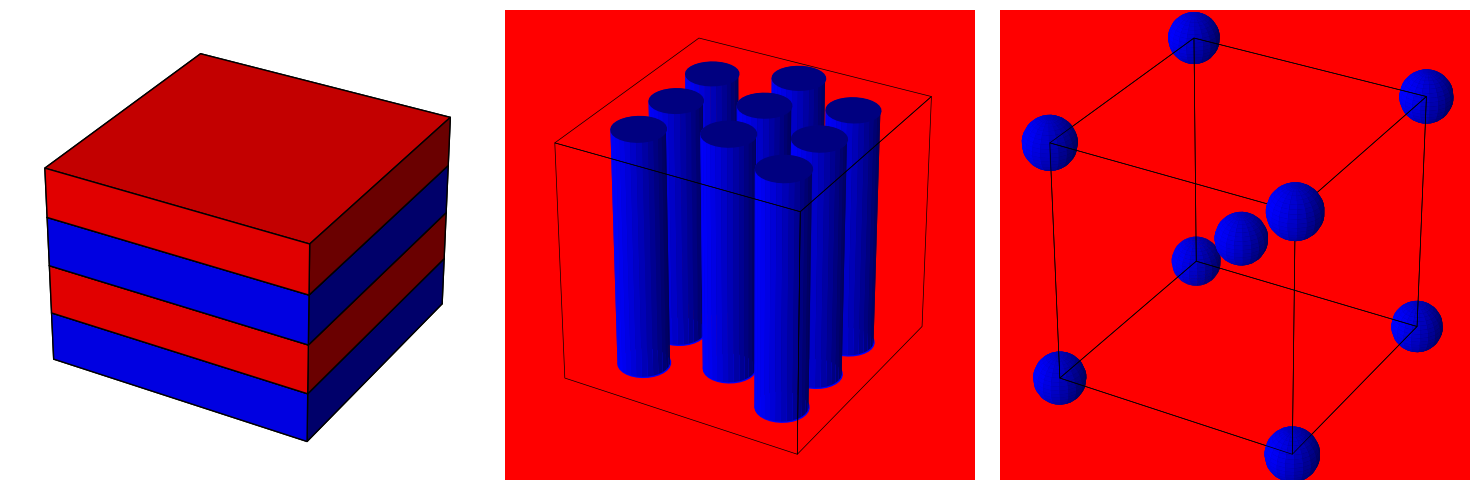

In [44]:
# fig = plt.figure(figsize=(15, 5))
fig = plt.figure(figsize=(15, 5), constrained_layout=True)

# Lamellar
ax1 = fig.add_subplot(131, projection='3d')
plot_lamellar(ax1)
# ax1.set_title("Lamellar Structure")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_zlim(0, 1)
set_axes_equal(ax1)

# Hexagonal/Cylindrical
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_box_aspect([1,1,1])
# plot_box(ax2, [0, 0, 0], size=2, color='red', alpha=0.1)
# plot_box_back(ax2, [0, 0, -0.5], size=2, color='red', alpha=0.0)
plot_hex_cylindrical(ax2)
plot_box_front(ax2, [0, 0, -0.5], size=2, color='red', alpha=0.0)

# ax2.set_title("Hexagonal (Cylindrical) Structure")
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 2)
ax2.set_zlim(0, 1)
set_axes_equal(ax2)
ax2.set_facecolor((1, 0, 0, 1)) 

# BCC
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_box_aspect([1,1,1])
# plot_box(ax3, [0, 0, 0], size=1, color='red', alpha=0.3)
plot_box_back(ax3, [0, 0, 0], size=1, color='red', alpha=0)

# plot_bcc_back(ax3)
# plot_box_back(ax3, [0, 0, 0], size=1, color='red', alpha=1)
plot_box_front(ax3, [0, 0, 0], size=1, color='red', alpha=0.0)

plot_bcc_front(ax3)

plot_bcc(ax3)
ax3.set_facecolor((1, 0, 0, 1)) 

# ax3.set_title("Body-Centered Cubic (BCC)")
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_zlim(0, 1)

clean_3d_axes(ax1)
clean_3d_axes(ax2)
clean_3d_axes(ax3)
set_axes_equal(ax3)

# plt.clf()
plt.tight_layout()
plt.show()


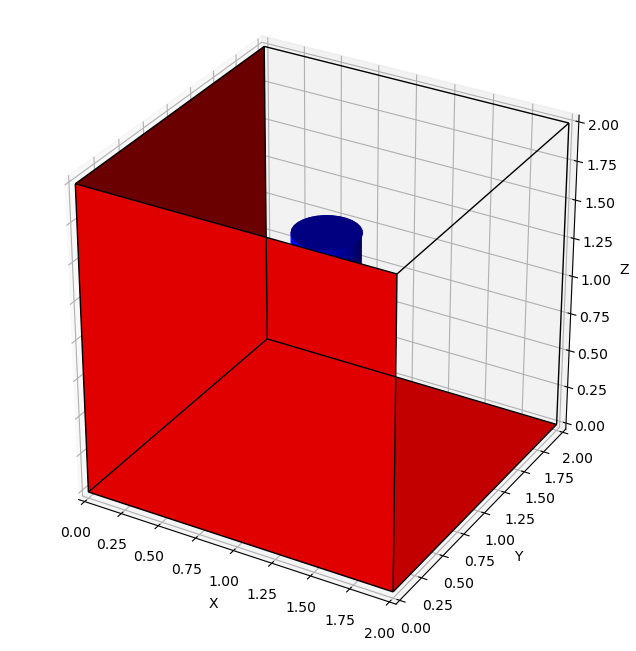

In [156]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

# def plot_cylinders(ax):
#     # Just a simple example cylinder
#     # (You can adapt from your code)
#     x_center, y_center, z_start = 1, 1, 0
#     radius, height = 0.2, 1.5
#     resolution = 30

#     theta = np.linspace(0, 2*np.pi, resolution)
#     x_circle = radius * np.cos(theta) + x_center
#     y_circle = radius * np.sin(theta) + y_center
#     z = np.linspace(z_start, z_start + height, 2)

#     Xc, Zc = np.meshgrid(x_circle, z)
#     Yc, _ = np.meshgrid(y_circle, z)
#     ax.plot_surface(Xc, Yc, Zc, color='blue', alpha=1.0)

#     # Top face
#     top_z = z_start + height
#     verts_top = list(zip(x_circle, y_circle, np.full_like(x_circle, top_z)))
#     ax.add_collection3d(Poly3DCollection([verts_top], color='navy'))

# def plot_back_faces(ax, origin, size, color='red', alpha=0.3):
#     x, y, z = origin
#     # Define the 3 back walls:
#     # x=0 wall (y-z plane)
#     x0 = np.array([[x, x], [x, x]])
#     y0 = np.array([[y, y+size], [y, y+size]])
#     z0 = np.array([[z, z], [z+size, z+size]])
#     ax.plot_surface(x0, y0, z0, color=color, alpha=alpha)

#     # y=0 wall (x-z plane)
#     x1 = np.array([[x, x+size], [x, x+size]])
#     y1 = np.array([[y, y], [y, y]])
#     z1 = np.array([[z, z], [z+size, z+size]])
#     ax.plot_surface(x1, y1, z1, color=color, alpha=alpha)

#     # z=0 wall (x-y plane)
#     x2 = np.array([[x, x+size], [x, x+size]])
#     y2 = np.array([[y, y], [y+size, y+size]])
#     z2 = np.array([[z, z], [z, z]])
#     ax.plot_surface(x2, y2, z2, color=color, alpha=alpha)

# def plot_cube_edges(ax, origin, size, edge_color='k', linewidth=1):
#     x, y, z = origin
#     # Cube vertices
#     verts = np.array([
#         [x, y, z],
#         [x+size, y, z],
#         [x+size, y+size, z],
#         [x, y+size, z],
#         [x, y, z+size],
#         [x+size, y, z+size],
#         [x+size, y+size, z+size],
#         [x, y+size, z+size]
#     ])

#     # Edges defined by pairs of vertices
#     edges = [
#         [verts[0], verts[1]], [verts[1], verts[2]], [verts[2], verts[3]], [verts[3], verts[0]],  # bottom square
#         [verts[4], verts[5]], [verts[5], verts[6]], [verts[6], verts[7]], [verts[7], verts[4]],  # top square
#         [verts[0], verts[4]], [verts[1], verts[5]], [verts[2], verts[6]], [verts[3], verts[7]]   # vertical edges
#     ]

#     edge_collection = Line3DCollection(edges, colors=edge_color, linewidths=linewidth)
#     ax.add_collection3d(edge_collection)

# # --- Plotting ---

# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_box_aspect([1,1,1])
# origin = (0,0,0)
# size = 2

# # Plot cylinders first
# plot_cylinders(ax)

# # Plot red back faces
# plot_back_faces(ax, origin, size, color='red', alpha=1)

# # Plot cube edges on top
# plot_cube_edges(ax, origin, size, edge_color='black', linewidth=1)

# # Set limits and labels
# ax.set_xlim(origin[0], origin[0] + size)
# ax.set_ylim(origin[1], origin[1] + size)
# ax.set_zlim(origin[2], origin[2] + size)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# plt.show()


# schematic

## gen

### binding functions

In [94]:
def eval_tmat(mu_a, mu_b, ea1 = 0, ea2 = 0, eb1 = 0, eb2 = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    # boltzmann weightings of all possible binding states of the two nucleosommes. essentially all possible non-normalized joint probabilities
    tmat = np.zeros((3,3))
    for n1 in range(3):
        for n2 in range(3):
            if (n1 == 0 and n2 == 0):
                f_tot = 0.
            elif (n1 == 0 and n2 == 1):
                f_tot = 0.5 * (-mu_a + ea2)
            elif (n1 == 1 and n2 == 0):
                f_tot = 0.5 * (-mu_a + ea1)
            elif (n1 == 0 and n2 == 2):
                f_tot = 0.5 * (-mu_b + eb2)
            elif (n1 == 2 and n2 == 0):
                f_tot = 0.5 * (-mu_b + eb1)
            elif (n1 == 1 and n2 == 1):
                f_tot = 0.5 * (-2 * mu_a + ea1 + ea2) + j_aa
            elif (n1 == 1 and n2 == 2):
                f_tot = 0.5 * (-mu_a - mu_b + ea1 + eb2) + j_ab
            elif (n1 == 2 and n2 == 1):
                f_tot = 0.5 * (-mu_a - mu_b + ea2 + eb1) + j_ab
            elif (n1 == 2 and n2 == 2):
                f_tot = 0.5 * (-2 * mu_b + eb1 + eb2) + j_bb

            f_tot -= f_ref
            tmat[n1, n2] = np.exp(-f_tot)
                    
    return tmat
    
def eval_tend(mu_a, mu_b, ea = 0, eb = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    tend = np.zeros((3))
    tend[0] = 1
    
    f_tot = 0.5 * (-mu_a + ea)
    f_tot -= f_ref
    tend[1] = np.exp(-f_tot)

    f_tot = 0.5 * (-mu_b + eb)
    f_tot -= f_ref
    tend[2] = np.exp(-f_tot)
                    
    return tend    

def eval_dtdmu(mu_a, mu_b, ea1 = 0, ea2 = 0, eb1 = 0, eb2 = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    dtda1 = np.zeros((3,3))
    dtda2 = np.zeros((3,3))
    dtdb1 = np.zeros((3,3))
    dtdb2 = np.zeros((3,3))
    for n1 in range(3):
        for n2 in range(3):
            if (n1 == 0 and n2 == 0):
                f_tot = 0.
                f_tot -= f_ref
            elif (n1 == 0 and n2 == 1):
                f_tot = 0.5 * (-mu_a + ea2)
                f_tot -= f_ref
                dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 1 and n2 == 0):
                f_tot = 0.5 * (-mu_a + ea1)
                f_tot -= f_ref
                dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 0 and n2 == 2):
                f_tot = 0.5 * (-mu_b + eb2)
                f_tot -= f_ref
                dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 2 and n2 == 0):
                f_tot = 0.5 * (-mu_b + eb1)
                f_tot -= f_ref
                dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 1 and n2 == 1):
                f_tot = 0.5 * (-2 * mu_a + ea1 + ea2) + j_aa
                f_tot -= f_ref
                dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
                dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 1 and n2 == 2):
                f_tot = 0.5 * (-mu_a - mu_b + ea1 + eb2) + j_ab
                f_tot -= f_ref
                dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
                dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 2 and n2 == 1):
                f_tot = 0.5 * (-mu_a - mu_b + ea2 + eb1) + j_ab
                f_tot -= f_ref
                dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
                dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 2 and n2 == 2):
                f_tot = 0.5 * (-2 * mu_b + eb1 + eb2) + j_bb
                f_tot -= f_ref
                dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
                dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
        
    return dtda1, dtda2, dtdb1, dtdb2

def eval_dtenddmu(mu_a, mu_b, ea = 0, eb = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    dtendda = np.zeros((3))
    dtenddb = np.zeros((3))
    
    f_tot = 0.5 * (-mu_a + ea)
    f_tot -= f_ref
    dtendda[1] = 0.5 * np.exp(-f_tot)

    f_tot = 0.5 * (-mu_b + eb)
    f_tot -= f_ref
    dtenddb[2] = 0.5 * np.exp(-f_tot)
                    
    return dtendda, dtenddb

def eval_phi(sig, mu_a = 0, mu_b = 0, ea = 0, eb = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    
    nm = len(sig)
    phiva = np.zeros((nm, 3))
    phivb = np.zeros((nm, 3))
    phia = np.zeros((nm))
    phib = np.zeros((nm))
    
    # Evaluate binding for the first bead
    # print("first bead binding:")
    ea2 = (1 - sig[0]) * ea
    eb2 = sig[0] * eb
    tend = eval_tend(mu_a, mu_b, ea2, eb2, f_ref)
    # print("tend: ", tend)
    dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, ea2, eb2, f_ref)
    # print("dtend/dmu_a :", dtendda)
    # print("dtend/dmu_b :", dtenddb)
    
    q_vec = tend
    # print("q_vec: ", q_vec)
    
    phiva[0, :] = dtendda
    phivb[0, :] = dtenddb
    for j in range(1, nm):
        phiva[j, :] = tend
        phivb[j, :] = tend

    # print("phiva: ", phiva)
    # print("phivb: ", phivb)
    
    # Evaluate binding for the intermediate beads
    # print("intermediate bead binding:")
    for i in range(0, nm - 1):
        # print(" --- nucleosome %s ---" % str(i+1))
        ea1 = ea2
        eb1 = eb2
        ea2 = (1 - sig[i + 1]) * ea
        eb2 = sig[i + 1] * eb
        
        tmat = eval_tmat(mu_a, mu_b, ea1, ea2, eb1, eb2, j_aa, j_bb, j_ab, f_ref)
        # print("tmat: ", tmat)
        dtda1, dtda2, dtdb1, dtdb2 = eval_dtdmu(mu_a, mu_b, ea1, ea2, eb1, eb2, j_aa, j_bb, j_ab, f_ref)
        
        # print("dt/dmu_a1: ", dtda1)
        # print("dt/dmu_a2: ", dtda2)
        # print("dt/dmu_b1: ", dtdb1)
        # print("dt/dmu_b2: ", dtdb2)
        
        q_vec = np.matmul(q_vec, tmat) # collecting all possibilites for eventual full partition function

        # print("updated q_vec (matmul q_vec and tmat): ", q_vec)
        
        # # print(q_vec)
        # print("old phiva: ", phiva)
        # print("old phivb: ", phivb)
        
        for j in range(0, nm):
            if j == i:
                phiva[j, :] = np.matmul(phiva[j, :], tmat) + np.matmul(phiva[i + 1, :], dtda1)
                phivb[j, :] = np.matmul(phivb[j, :], tmat) + np.matmul(phivb[i + 1, :], dtdb1)
            elif j == (i + 1):
                phiva[j, :] = np.matmul(phiva[j, :], dtda2)
                phivb[j, :] = np.matmul(phivb[j, :], dtdb2)
            else:
                phiva[j, :] = np.matmul(phiva[j, :], tmat)
                phivb[j, :] = np.matmul(phivb[j, :], tmat)

        # print("new phiva: ", phiva)
        # print("new phivb: ", phivb)
    
    # Evaluate binding for the last bead

    # print("last bead binding:")
    
    ea1 = ea2
    eb1 = eb2

    tend = eval_tend(mu_a, mu_b, ea1, eb1, f_ref)
    dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, ea1, eb1, f_ref)

    # print("tend: ", tend)
    # print("dtendda, dtendda: ", dtendda, dtendda)

    q = np.matmul(q_vec, tend)
    phia[nm - 1] = (np.matmul(q_vec, dtendda) + np.matmul(phiva[nm - 1, :], tend)) / q
    phib[nm - 1] = (np.matmul(q_vec, dtenddb) + np.matmul(phivb[nm - 1, :], tend)) / q
    for j in range(0, nm - 1):
        phia[j] = np.matmul(phiva[j, :], tend) / q
        phib[j] = np.matmul(phivb[j, :], tend) / q
    
    return phia, phib

### code

In [ ]:
num_mon = nm
steps = np.random.randn(num_mon,3)
# Compute cumulative sum to get positions
poly = np.cumsum(steps, axis=0)

In [117]:
nm = 100
ea = -1.52
eb = -1.52
j_aa = -4
j_bb = -4
j_ab = 4

mu_a = -5.5
mu_b = -5.5

f_ref = np.min(np.array([j_aa, j_bb, j_ab, ea, eb]))

sig = np.zeros((nm))
for i in range(nm):
    pb = i / (nm - 1)    
    if np.random.uniform() < pb:
        sig[i] = 1
    else:
        sig[i] = 0

phia, phib = eval_phi(sig, mu_a, mu_b, ea, eb, j_aa, j_bb, j_ab, f_ref)
phiu = 1-phia-phib

identity_44 = np.zeros(nm)
for i in range(nm):
    draw = np.random.rand()
    if draw<phia[i]:
        identity_44[i] = 2
    elif draw>phia[i] and draw<phib[i]:
        identity_44[i] = 1
    else:
        identity_44[i] = 0
identity_44 = identity_44.astype(int)

mu_a = -4.5
mu_b = -4.5

phia, phib = eval_phi(sig, mu_a, mu_b, ea, eb, j_aa, j_bb, j_ab, f_ref)
phiu = 1-phia-phib

identity_33 = np.zeros(nm)
for i in range(nm):
    draw = np.random.rand()
    if draw<phia[i]:
        identity_33[i] = 2
    elif draw>phia[i] and draw<phib[i]:
        identity_33[i] = 1
    else:
        identity_33[i] = 0
identity_33 = identity_33.astype(int)

mu_a = -3.5
mu_b = -4.5

phia, phib = eval_phi(sig, mu_a, mu_b, ea, eb, j_aa, j_bb, j_ab, f_ref)
phiu = 1-phia-phib

identity_295_3 = np.zeros(nm)
for i in range(nm):
    draw = np.random.rand()
    if draw<phia[i]:
        identity_295_3[i] = 2
    elif draw>phia[i] and draw<phib[i]:
        identity_295_3[i] = 1
    else:
        identity_295_3[i] = 0
identity_295_3 = identity_295_3.astype(int)


In [123]:
# np.save("poly_100mons_schem2.npy", poly)
np.save("identity_n3.5n4.5_schem2.npy", identity_295_3)
np.save("identity_n4.5n4.5_schem2.npy", identity_33)
np.save("identity_n5.5n5.5_schem2.npy", identity_44)

## load

In [2]:

poly = np.load("poly_100mons_schem2.npy")
identity_295_3 = np.load("identity_n3.5n4.5_schem2.npy")
identity_33 = np.load("identity_n4.5n4.5_schem2.npy")
identity_44 = np.load("identity_n5.5n5.5_schem2.npy")


## figure

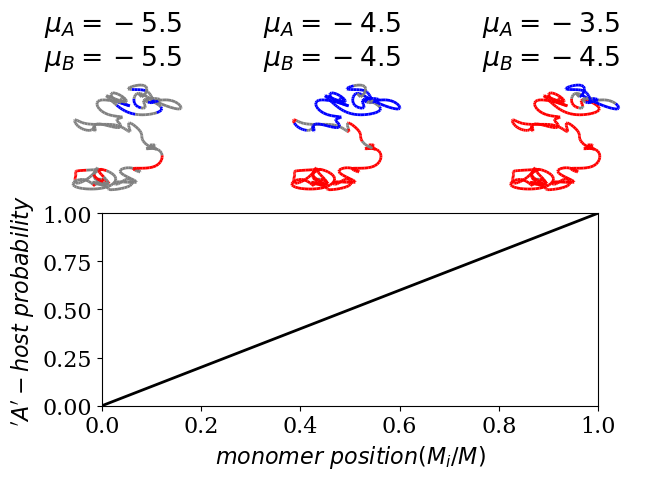

In [6]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

def plot_colored_curve(ax, points, identities, title):
    tck, u = splprep([points[:, 0], points[:, 1], points[:, 2]], s=2)
    u_fine = np.linspace(0, 1, 500)
    x_smooth, y_smooth, z_smooth = splev(u_fine, tck)

    identity_interp = interp1d(u, identities, kind='nearest', bounds_error=False, fill_value='extrapolate')
    identities_fine = identity_interp(u_fine)

    color_map = {0: 'grey', 1: 'blue', 2: 'red'} # original, correct
    # color_map = {0: 'grey', 1: 'red', 2: 'blue'} # for biophysics pres
    points_smooth = np.array([x_smooth, y_smooth, z_smooth]).T
    segments = np.array([points_smooth[:-1], points_smooth[1:]]).transpose(1, 0, 2)

    colors = [color_map.get(val, 'black') for val in identities_fine[:-1]]
    lc = Line3DCollection(segments, colors=colors, linewidth=2)
    ax.add_collection(lc)

    ax.set_xlim(points[:, 0].min(), points[:, 0].max())
    ax.set_ylim(points[:, 1].min(), points[:, 1].max())
    ax.set_zlim(points[:, 2].min(), points[:, 2].max())
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(title, y=0.95)

# Example: your data
points = poly  # shape (N, 3)
identity_1 = identity_295_3
identity_2 = identity_33
identity_3 = identity_44

fig = plt.figure(figsize=(8, 5))
font = {'family' : 'serif', 'weight':'normal', 'size': 16}
plt.rc('font', **font)

# Setup GridSpec: 2 rows, 3 columns
gs = gridspec.GridSpec(2, 3, height_ratios=[5, 5], hspace=-.0)  # Top row taller

# Top 3 plots
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
plot_colored_curve(ax1, points, identity_44, r"$\mu_A = -5.5$" +"\n" + "$\mu_B = -5.5$")

ax2 = fig.add_subplot(gs[0, 1], projection='3d')
plot_colored_curve(ax2, points, identity_33,  r"$\mu_A = -4.5$" +"\n" + "$\mu_B = -4.5$")#) r"$\mu = [-3.25, -3.25]$")

ax3 = fig.add_subplot(gs[0, 2], projection='3d')
plot_colored_curve(ax3, points, identity_295_3,  r"$\mu_A = -3.5$" +"\n" + "$\mu_B = -4.5$")#r"$\mu = [-2.95, -3.25]$")

# Bottom plot: span all 3 columns
ax_bottom = fig.add_subplot(gs[1, :])  # ":" means span all columns

# Plot linear profile from (0,0) to (1,1)
ax_bottom.plot([0, 1], [0, 1], color='black', linewidth=2)
pos = ax_bottom.get_position()  # Get current position
ax_bottom.set_position([pos.x0 + 0.1, pos.y0+0.05, pos.width *0.8, pos.height])
# Make the bottom plot rectangular and clean
ax_bottom.set_xlim(0, 1)
ax_bottom.set_ylim(0, 1)
ax_bottom.set_xlabel(r"$monomer \  position (M_i / M)$")
ax_bottom.set_ylabel(r"$ 'A'-host \ probability$")
ax_bottom.grid(False)

# plt.savefig('schematic2_alt.eps', format='eps')
# plt.savefig('schematic2.svg', format='svg')
plt.savefig('schematic2_alt.pdf', format='pdf')

plt.show()


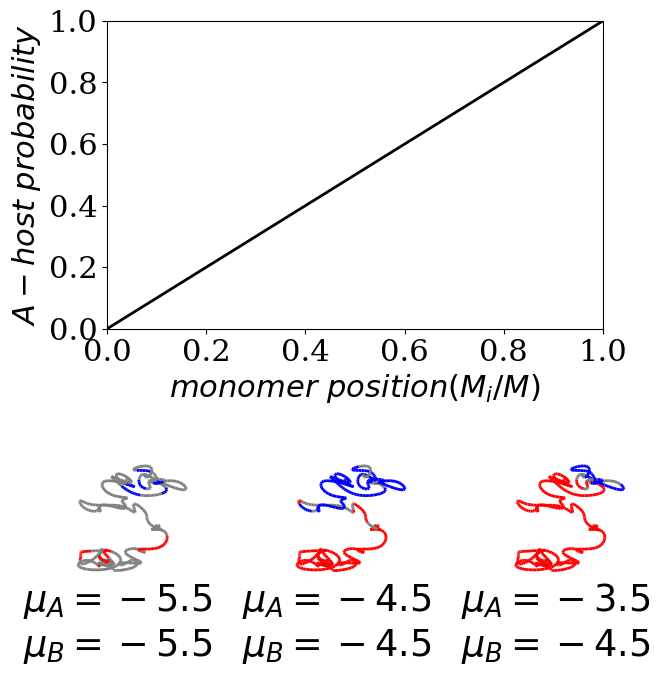

In [86]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

def plot_colored_curve(ax, points, identities, title):
    tck, u = splprep([points[:, 0], points[:, 1], points[:, 2]], s=2)
    u_fine = np.linspace(0, 1, 500)
    x_smooth, y_smooth, z_smooth = splev(u_fine, tck)

    identity_interp = interp1d(u, identities, kind='nearest', bounds_error=False, fill_value='extrapolate')
    identities_fine = identity_interp(u_fine)

    color_map = {0: 'grey', 1: 'blue', 2: 'red'} # original, correct
    # color_map = {0: 'grey', 1: 'red', 2: 'blue'} # for biophysics pres
    points_smooth = np.array([x_smooth, y_smooth, z_smooth]).T
    segments = np.array([points_smooth[:-1], points_smooth[1:]]).transpose(1, 0, 2)

    colors = [color_map.get(val, 'black') for val in identities_fine[:-1]]
    lc = Line3DCollection(segments, colors=colors, linewidth=2)
    ax.add_collection(lc)

    ax.set_xlim(points[:, 0].min(), points[:, 0].max())
    ax.set_ylim(points[:, 1].min(), points[:, 1].max())
    ax.set_zlim(points[:, 2].min(), points[:, 2].max())
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(title, y=-0.3)

# Example: your data
points = poly  # shape (N, 3)
identity_1 = identity_295_3
identity_2 = identity_33
identity_3 = identity_44

fig = plt.figure(figsize=(8, 8))
# fig = plt.figure(figsize=(16, 10))

font = {'family' : 'serif', 'weight':'normal', 'size': 22}
plt.rc('font', **font)

# Setup GridSpec: 2 rows, 3 columns
gs = gridspec.GridSpec(2, 3, height_ratios=[5, 5], hspace=.0)  # Top row taller
# gs = gridspec.GridSpec(2, 3, height_ratios=[5, 15], hspace=.0)  # Top row taller

# Top 3 plots
ax1 = fig.add_subplot(gs[1, 0], projection='3d')
plot_colored_curve(ax1, points, identity_44, r"$\mu_A = -5.5$" +"\n" + "$\mu_B = -5.5$")

ax2 = fig.add_subplot(gs[1, 1], projection='3d')
plot_colored_curve(ax2, points, identity_33,  r"$\mu_A = -4.5$" +"\n" + "$\mu_B = -4.5$")#) r"$\mu = [-3.25, -3.25]$")

ax3 = fig.add_subplot(gs[1, 2], projection='3d')
plot_colored_curve(ax3, points, identity_295_3,  r"$\mu_A = -3.5$" +"\n" + "$\mu_B = -4.5$")#r"$\mu = [-2.95, -3.25]$")

# Bottom plot: span all 3 columns
ax_bottom = fig.add_subplot(gs[0, :])  # ":" means span all columns

# Plot linear profile from (0,0) to (1,1)
ax_bottom.plot([0, 1], [0, 1], color='black', linewidth=2)
pos = ax_bottom.get_position()  # Get current position
ax_bottom.set_position([pos.x0 + 0.1, pos.y0+0.05, pos.width *0.8, pos.height])
# ax_bottom.set_position([pos.x0 + 0.1, pos.y0-0.1, pos.width *0.8, pos.height])

# Make the bottom plot rectangular and clean
ax_bottom.set_xlim(0, 1)
ax_bottom.set_ylim(0, 1)
ax_bottom.set_xlabel(r"$monomer \  position (M_i / M)$")
ax_bottom.set_ylabel(r"$ A-host \ probability$")
ax_bottom.grid(False)

plt.savefig('schematic2_alt_final.eps', format='eps')
plt.savefig('schematic2_alt_final.svg', format='svg')
plt.savefig('schematic2_alt_final.pdf', format='pdf')

plt.show()


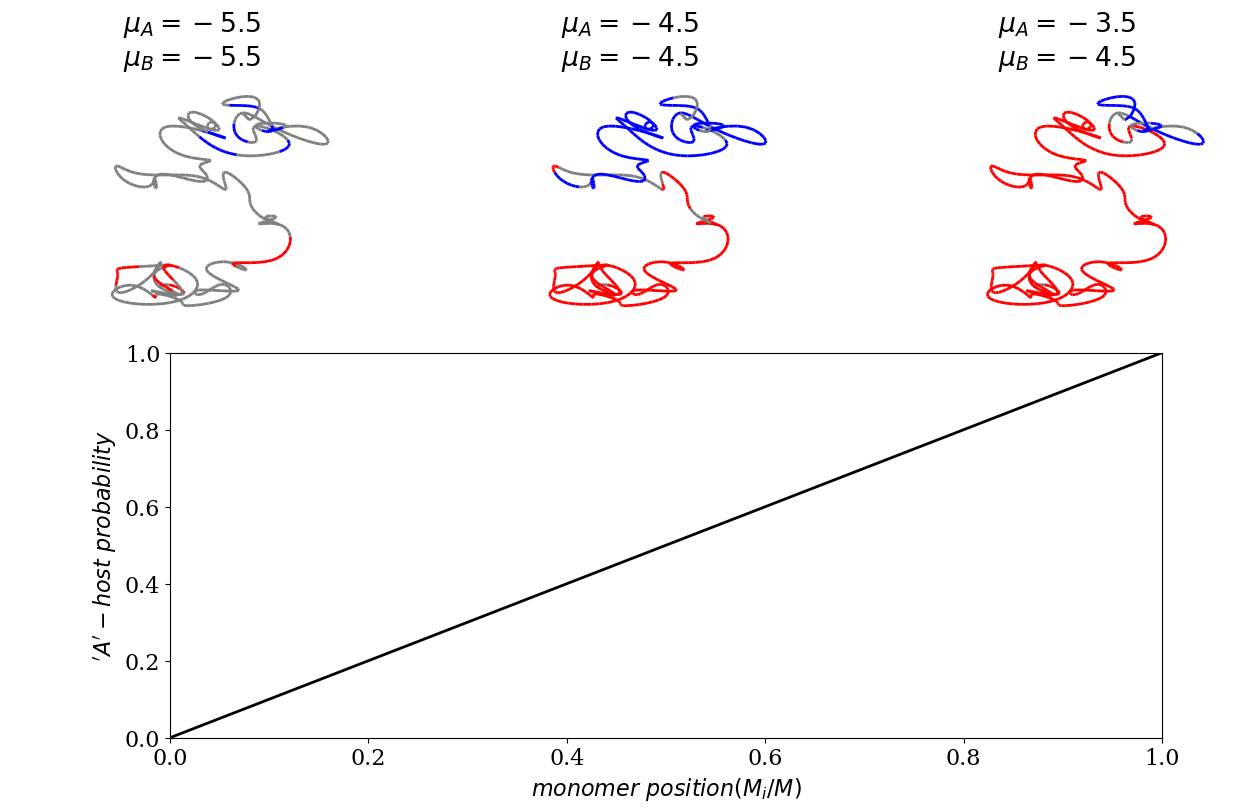

In [50]:
# from scipy.interpolate import splprep, splev
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Line3DCollection
# from scipy.interpolate import interp1d
# import matplotlib.gridspec as gridspec

# def plot_colored_curve(ax, points, identities, title):
#     tck, u = splprep([points[:, 0], points[:, 1], points[:, 2]], s=2)
#     u_fine = np.linspace(0, 1, 500)
#     x_smooth, y_smooth, z_smooth = splev(u_fine, tck)

#     identity_interp = interp1d(u, identities, kind='nearest', bounds_error=False, fill_value='extrapolate')
#     identities_fine = identity_interp(u_fine)

#     color_map = {0: 'grey', 1: 'blue', 2: 'red'}
#     points_smooth = np.array([x_smooth, y_smooth, z_smooth]).T
#     segments = np.array([points_smooth[:-1], points_smooth[1:]]).transpose(1, 0, 2)

#     colors = [color_map.get(val, 'black') for val in identities_fine[:-1]]
#     lc = Line3DCollection(segments, colors=colors, linewidth=2)
#     ax.add_collection(lc)

#     ax.set_xlim(points[:, 0].min(), points[:, 0].max())
#     ax.set_ylim(points[:, 1].min(), points[:, 1].max())
#     ax.set_zlim(points[:, 2].min(), points[:, 2].max())
#     ax.grid(False)
#     ax.set_axis_off()
#     ax.set_title(title, y=0.95)

# # Example: your data
# points = poly  # shape (N, 3)
# identity_1 = identity_295_3
# identity_2 = identity_33
# identity_3 = identity_44

# fig = plt.figure(figsize=(16, 10))
# font = {'family' : 'serif', 'weight':'normal', 'size': 16}
# plt.rc('font', **font)

# # Setup GridSpec: 2 rows, 3 columns
# gs = gridspec.GridSpec(2, 3, height_ratios=[5, 5], hspace=-.0)  # Top row taller

# # Top 3 plots
# ax1 = fig.add_subplot(gs[0, 0], projection='3d')
# plot_colored_curve(ax1, points, identity_44, r"$\mu_A = -5.5$" +"\n" + "$\mu_B = -5.5$")

# ax2 = fig.add_subplot(gs[0, 1], projection='3d')
# plot_colored_curve(ax2, points, identity_33,  r"$\mu_A = -4.5$" +"\n" + "$\mu_B = -4.5$")#) r"$\mu = [-3.25, -3.25]$")

# ax3 = fig.add_subplot(gs[0, 2], projection='3d')
# plot_colored_curve(ax3, points, identity_295_3,  r"$\mu_A = -3.5$" +"\n" + "$\mu_B = -4.5$")#r"$\mu = [-2.95, -3.25]$")

# # Bottom plot: span all 3 columns
# ax_bottom = fig.add_subplot(gs[1, :])  # ":" means span all columns

# # Plot linear profile from (0,0) to (1,1)
# ax_bottom.plot([0, 1], [0, 1], color='black', linewidth=2)
# pos = ax_bottom.get_position()  # Get current position
# ax_bottom.set_position([pos.x0 + 0.1, pos.y0+0.05, pos.width *0.8, pos.height])
# # Make the bottom plot rectangular and clean
# ax_bottom.set_xlim(0, 1)
# ax_bottom.set_ylim(0, 1)
# ax_bottom.set_xlabel(r"$monomer \  position (M_i / M)$")
# ax_bottom.set_ylabel(r"$ 'A'-host \ probability$")
# ax_bottom.grid(False)

# # plt.savefig('schematic2_alt.eps', format='eps')
# # plt.savefig('schematic2.svg', format='svg')
# # plt.savefig('schematic2_alt.pdf', format='pdf')

# plt.show()


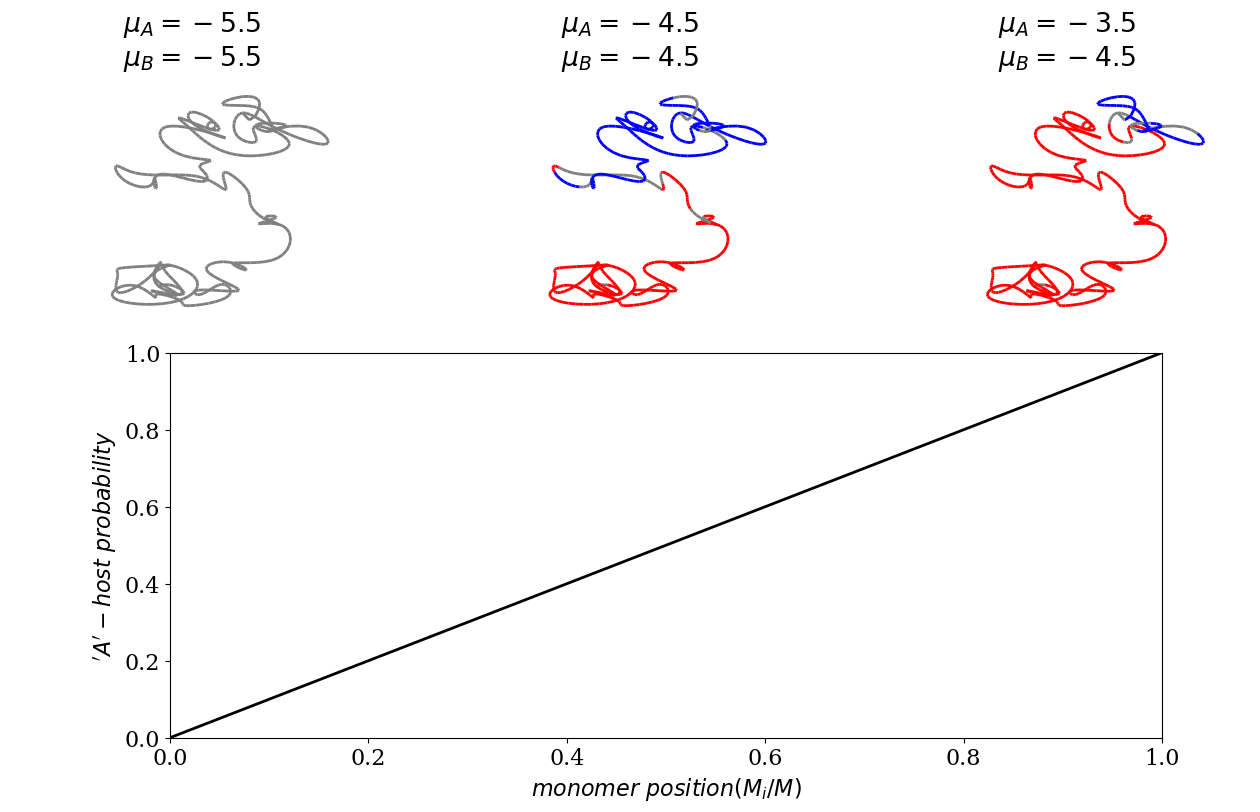

In [56]:
# fig = plt.figure(figsize=(16, 10))
# font = {'family' : 'serif', 'weight':'normal', 'size': 16}
# plt.rc('font', **font)

# # Setup GridSpec: 2 rows, 3 columns
# gs = gridspec.GridSpec(2, 3, height_ratios=[5, 5], hspace=-.0)  # Top row taller

# # Top 3 plots
# ax1 = fig.add_subplot(gs[0, 0], projection='3d')
# plot_colored_curve(ax1, points, np.zeros_like(identity_44), r"$\mu_A = -5.5$" +"\n" + "$\mu_B = -5.5$")

# ax2 = fig.add_subplot(gs[0, 1], projection='3d')
# plot_colored_curve(ax2, points, identity_33,  r"$\mu_A = -4.5$" +"\n" + "$\mu_B = -4.5$")#) r"$\mu = [-3.25, -3.25]$")

# ax3 = fig.add_subplot(gs[0, 2], projection='3d')
# plot_colored_curve(ax3, points, identity_295_3,  r"$\mu_A = -3.5$" +"\n" + "$\mu_B = -4.5$")#r"$\mu = [-2.95, -3.25]$")

# # Bottom plot: span all 3 columns
# ax_bottom = fig.add_subplot(gs[1, :])  # ":" means span all columns

# # Plot linear profile from (0,0) to (1,1)
# ax_bottom.plot([0, 1], [0, 1], color='black', linewidth=2)
# pos = ax_bottom.get_position()  # Get current position
# ax_bottom.set_position([pos.x0 + 0.1, pos.y0+0.05, pos.width *0.8, pos.height])
# # Make the bottom plot rectangular and clean
# ax_bottom.set_xlim(0, 1)
# ax_bottom.set_ylim(0, 1)
# ax_bottom.set_xlabel(r"$monomer \  position (M_i / M)$")
# ax_bottom.set_ylabel(r"$ 'A'-host \ probability$")
# ax_bottom.grid(False)

# # plt.savefig('schematic2_alt.eps', format='eps')
# # plt.savefig('schematic2.svg', format='svg')
# plt.savefig('schematic2_alt.pdf', format='pdf')

# plt.show()

# binding map

In [2]:
n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

#  density map
mu_max_1 = -1.999 - 1.5#1.52*2
mu_min_1 = -5 - 1.5#1.52*2
# del_mu_1 = .01#.5 #0.25
# # # EDITTTTTTTTTTTTTTTTTTTTTTTTTT FOR FASTER JUST CHECK HO WBIND AFF CHANGES THINGS
# # # CHAGNE BACKKKK
del_mu_1 = .01#.5 #0.25

mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

# #  density map using xn50
# mu_max_1xn = -2#8#0.1 #10
# mu_min_1xn = -4#-9
# del_mu_1xn = .0025#.5 #0.25
# mu_max_2xn = mu_max_1xn
# mu_min_2xn = mu_min_1xn
# del_mu_2xn = del_mu_1xn

# mu1_arr_xn = np.arange(mu_min_1xn, mu_max_1xn, del_mu_1xn)
# mu2_arr_xn = np.arange(mu_min_2xn, mu_max_2xn, del_mu_2xn)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

## gen

In [73]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)

CPU times: total: 1h 4min 34s
Wall time: 1h 7min 17s


In [74]:
#REAL
fa_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1
fb_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1
fab_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1
fo_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1

for i, mu1 in enumerate(mu1_arr[:]):
    for j, mu2 in enumerate(mu2_arr[:]):
        s_Abnd_ar = s_bind_A_ALL[i,j]
        s_Bbnd_ar = s_bind_B_ALL[i,j]
        f_a, f_b, f_ab, f_o = calc_fas(s_Abnd_ar, s_Bbnd_ar)
        fa_mat[i,j] = f_a
        fb_mat[i,j] = f_b
        fab_mat[i,j] = f_ab
        fo_mat[i,j] = f_o

In [85]:
np.save("s_bind_A_densitymap_ALT.npy", s_bind_A_ALL)
np.save("s_bind_B_densitymap_ALT.npy", s_bind_B_ALL)

In [87]:
np.save("fa_mat_densitymap_highres_ALT.npy", fa_mat)
np.save("fb_mat_densitymap_highres_ALT.npy", fb_mat)

## load

In [5]:
fa_mat = np.load("fa_mat_densitymap_highres_ALT.npy")
fb_mat = np.load("fb_mat_densitymap_highres_ALT.npy")

s_bind_A_ALL = np.load("s_bind_A_densitymap_ALT.npy")
s_bind_B_ALL = np.load("s_bind_B_densitymap_ALT.npy")

## figure

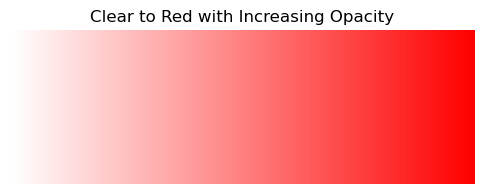

In [8]:
# Define colors: white (fully transparent) to bright red (fully opaque)
colors = [(1, 0, 0, 0), (1, 0, 0, 1)]  # RGBA: white (transparent) to red (opaque)

# Create a colormap
cmap_name = 'clear_to_red_alpha'
red_cmap = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

colors = [(0, 0, 1, 0), (0, 0, 1, 1)]  # RGBA: white (transparent) to red (opaque)

# Create a colormap
cmap_name = 'clear_to_blue_alpha'
blue_cmap = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

# Display the colormap as a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=red_cmap)
ax.set_axis_off()
plt.title("Clear to Red with Increasing Opacity")
plt.show()

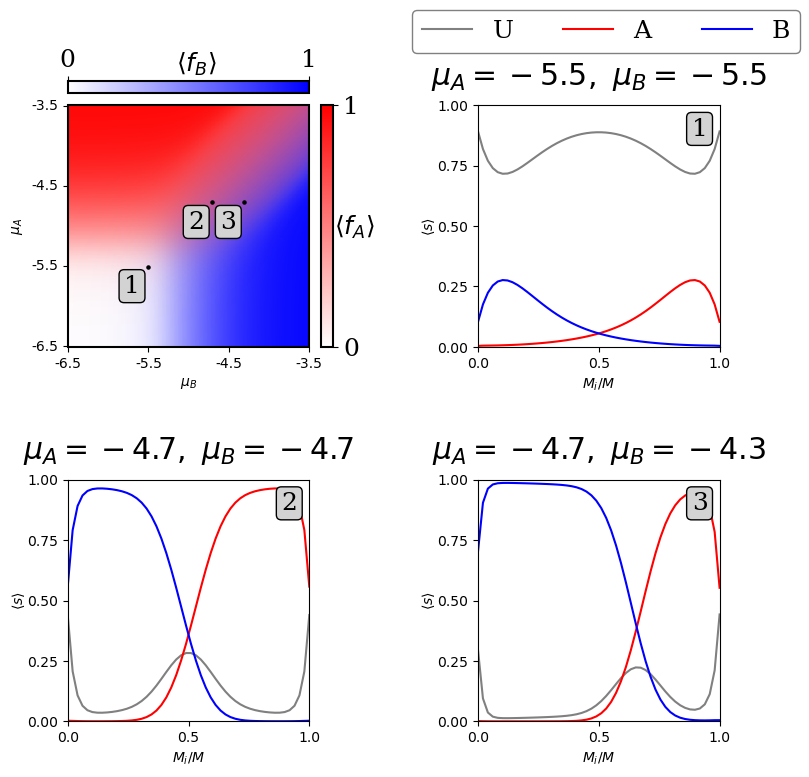

In [10]:
# EDIT FORNLOWER RES!!
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 layout

# Flatten axes array for easier access
ax1, ax2, ax3, ax4 = axes.flatten()

# Plot 1: heatmap on top-left
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

mu2_array = np.round(mu2_arr,2)
mu1_array = np.round(mu1_arr,2)

# fig, ax = plt.subplots(figsize=(4, 5))
ax = ax1
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
fontsize=18
plt.rc('font', **font)
vmin=0
vmax=1
# First heatmap
hm1 = sns.heatmap(fb_mat, linewidth=0.0, cmap=blue_cmap,
                  xticklabels=mu2_array, yticklabels=mu1_array,
                  cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax, rasterized=True)
# pos = ax.get_position()  # get the position of the axes in figure coordinates
# rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
#                          linewidth=1.5, edgecolor='black', facecolor='none',
#                          transform=fig.transFigure, zorder=10)

# fig.patches.append(rect)

# Manually add colorbar 1
cax1 = inset_axes(ax, width="100%", height="5%", loc='upper right',
                  bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
                  bbox_transform=ax.transAxes, borderpad=0)

cb1 = fig.colorbar(hm1.collections[0], cax=cax1, orientation='horizontal', ticks=[0,  1])

# cb1.set_label(r'$ \langle f_B \rangle $')
cb1.outline.set_edgecolor('black')
cb1.outline.set_linewidth(1.5)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb1.ax.text(.45, 1.25, r'$ \langle f_B \rangle $',
            transform=cb1.ax.transAxes,
            fontsize=fontsize, ha='left', va='bottom')
# # Manually add colorbar 1
# cax1 = inset_axes(ax, width="5%", height="50%", loc='upper left',
#                   bbox_to_anchor=(1, 0.1, 1, 1),  # adjust left/right with -0.15
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb1 = fig.colorbar(hm2.collections[0], cax=cax1)
# cb1.set_label(r'$ \langle f_B \rangle $')
# cb1.outline.set_edgecolor('black')
# cb1.outline.set_linewidth(1.5)

# Second heatmap (overlayed)
hm2 = sns.heatmap(fa_mat, linewidth=0.0, cmap=red_cmap,
                  xticklabels=np.round(mu2_array, 3), yticklabels=np.round(mu1_array,3),
                  cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax, rasterized=True)

# # Manually add colorbar 2
# cax2 = inset_axes(ax, width="100%", height="5%", loc='upper right',
#                   bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, orientation='horizontal')
# cb2.set_label(r'$ \langle f_A \rangle $')
# cb2.outline.set_edgecolor('black')
# cb2.outline.set_linewidth(1.5)


# Manually add colorbar 2
cax2 = inset_axes(ax, width="5%", height="100%", loc='upper left',
                  bbox_to_anchor=(1.05, 0.0, 1, 1),  # adjust left/right with -0.15
                  bbox_transform=ax.transAxes, borderpad=0)

cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, ticks=[0, 1])
# cb2.set_label(r'$ \langle f_A \rangle $')
cb2.outline.set_edgecolor('black')
cb2.outline.set_linewidth(1.5)
cb2.ax.text(1.08, 0.55, r'$ \langle f_A \rangle $',
            transform=cb2.ax.transAxes,
            fontsize=fontsize, ha='left', va='top', rotation=0)


# Parameters for the box (adjust these to highlight your region)
x_start = 200       # column index (left edge)
y_start = 200       # row index (top edge)
width = 35         # number of columns to span
height = 35        # number of rows to span

# # Create and add the rectangle
# rect = patches.Rectangle(
#     (x_start, y_start),     # bottom-left corner (note: heatmap coords go left-right, bottom-top)
#     width,
#     height,
#     linewidth=2,
#     edgecolor='black',
#     linestyle='--',
#     facecolor='none', alpha = 0.5
# )

# Add to the same axes as the heatmap
# ax.add_patch(rect)


spacing = 100
# spacing = 10

hm1.set_xticks(hm1.get_xticks()[::spacing])
hm1.set_xticklabels(np.round(mu2_arr[::spacing], 3))
hm1.set_yticks(hm1.get_yticks()[::spacing])
hm1.set_yticklabels(np.round(mu1_arr[::spacing],3))
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=0)  # <- Set labels horizontal here
# ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")
low = [-4-1.5, -4-1.5]
sym = [-3.2-1.5, -3.2-1.5]
cyl = [-3.2-1.5, -2.8-1.5]

#orig
mu1_ind = np.where(np.round(mu1_arr,4) == low[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == low[1])[0][0]
p1 = [mu1_ind, mu2_ind]
mu1_ind = np.where(np.round(mu1_arr,4) == sym[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == sym[1])[0][0]
p2 = [mu1_ind, mu2_ind]
mu1_ind = np.where(np.round(mu1_arr,4) == cyl[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == cyl[1])[0][0]
p3 = [mu1_ind, mu2_ind]

# p1 = [100,100]
# p2 = [175,175]
# p3 = [175, 215]

# ofst=2
# hm1.text(p1[1]-ofst,p1[0]-ofst, "1")
# hm1.text(p2[1]-ofst,p2[0]-ofst, "2")
# hm1.text(p3[1]-ofst,p3[0]-ofst, "3")

# hm1.scatter(100,100, color = "black", s = 5) #1
# hm1.scatter(175,175, color = "black", s = 5) #2
# hm1.scatter(205,175, color = "black", s = 5) #3
# crc = 100
# hm1.scatter(p1[1]+crc,p1[0]+crc, color = "black", s = 5) #1
# hm1.scatter(p2[1]+crc,p2[0]+crc, color = "black", s = 5) #2
# hm1.scatter(p3[1]+crc,p3[0]+crc, color = "black", s = 5) #3

p1x = np.where(np.round(mu2_arr,4) == low[1])[0][0]
p1y = np.where(np.round(mu1_arr,4) == low[0])[0][0]

p2x = np.where(np.round(mu2_arr,4) == sym[1])[0][0]
p2y = np.where(np.round(mu1_arr,4) == sym[0])[0][0]

p3x = np.where(np.round(mu2_arr,4) == cyl[1])[0][0]
p3y = np.where(np.round(mu1_arr,4) == cyl[0])[0][0]

hm1.scatter(p1x,p1y, color = "black", s = 5) #1
hm1.scatter(p2x,p2y, color = "black", s = 5) #2
hm1.scatter(p3x,p3y, color = "black", s = 5) #3

ofst=10
hm1.text(p1x-ofst,p1y-ofst, "1",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
hm1.text(p2x-ofst,p2y-ofst, "2",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
hm1.text(p3x-ofst,p3y-ofst, "3",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# ax.scatter(10,10, marker = "*")
# ax.scatter(10,10, marker = "*")
hm1.invert_yaxis()

hm1.set_ylabel("$\mu_A$")
hm1.set_xlabel("$\mu_B$")



# plt.tight_layout()
# plt.show()

# Plot 2: e.g. line plot on top-right
# mu1 = -4
# mu2 = -4
mu1 = np.round(mu1_arr[p1[0]],2)
mu2 = np.round(mu2_arr[p1[1]],2)

# mu1_ind = np.where(mu1_array == mu1)[0][0]
# mu2_ind = np.where(mu2_array == mu2)[0][0]
mu1_ind = p1[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p1[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]
s_unbnd = 1 - (s_bnd_A+s_bnd_B)

xvals = np.linspace(0,1,len(s_bnd_A))


ax2.plot(xvals, s_unbnd, color = "grey", label = "U")

ax2.plot(xvals, s_bnd_A, color = "red", label = "A")
ax2.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax2.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax2.set_xlim(0,1)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax2.set_xticks([0, 0.25, 0.5, 0.75, 1])

# ax2.set_xlabel("M")
ax2.set_xlabel(r"$M_i/M$")

ax2.set_ylabel(r"$\langle s \rangle$", labelpad=0)
# ax2.plot(x_vals, y_vals, color='red')
ax2.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 15)

# Plot 3: e.g. bar plot bottom-left

mu1 = np.round(mu1_arr[p2[0]],2)
mu2 = np.round(mu2_arr[p2[1]],2)

# mu1_ind = np.where(np.round(mu1_array,2) == mu1)[0][0]
# mu2_ind = np.where(np.round(mu2_array,2) == mu2)[0][0]
mu1_ind = p2[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p2[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]

s_unbnd = 1 - (s_bnd_A+s_bnd_B)

ax3.plot(xvals, s_unbnd, color = "grey", label = "U")

ax3.plot(xvals, s_bnd_A, color = "red", label = "A")
ax3.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax3.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax3.set_xlim(0,1)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax3.set_xticks([0, 0.25, 0.5, 0.75, 1])

ax3.set_xlabel(r"$M_i/M$")
ax3.set_ylabel(r"$\langle s \rangle$" ,labelpad = 0)
ax3.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 15)
# Plot 4: e.g. scatter plot bottom-right

# mu1 = np.round(mu1_arr[175],2)
# mu2 = np.round(mu2_arr[205],2)
mu1 = np.round(mu1_arr[p3[0]],2)
mu2 = np.round(mu2_arr[p3[1]],2)

mu1_ind = p3[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p3[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]


s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]

s_unbnd = 1 - (s_bnd_A+s_bnd_B)

ax4.plot(xvals, s_unbnd, color = "grey", label = "U")

ax4.plot(xvals, s_bnd_A, color = "red", label = "A")
ax4.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax4.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax4.set_xlim(0,1)
ax4.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax4.set_xticks([0, 0.25, 0.5, 0.75, 1])


# ax4.set_xlabel("M")
ax4.set_xlabel(r"$M_i/M$")

ax4.set_ylabel(r"$\langle s \rangle$", labelpad = 0)
# ax4.scatter(x_scatter, y_scatter)
# ax4.set_title("Scatter Plot")
ax4.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 15)

# plt.tight_layout()

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.125, hspace=0.55)

# Gather legend handles from one plot (they're identical)
handles, labels = ax2.get_legend_handles_labels()

# # Add a single legend on the right side of the figure
# # fig.legend(handles, labels, loc='center right', title="States", fontsize=fontsize, title_fontsize=fontsize+1, bbox_to_anchor=(1.08, 0.5))
# fig.legend(handles, labels, loc='center right', fontsize=fontsize, bbox_to_anchor=(1.08, 0.5))

# fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
# Shift the figure layout to make room for the legend
# fig.subplots_adjust(right=0.95)  # adjust as needed

pos = ax.get_position()  # get the position of the axes in figure coordinates
rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
                         linewidth=1.5, edgecolor='black', facecolor='none',
                         transform=fig.transFigure, zorder=10)

fig.patches.append(rect)

fig.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.725, .93),  # (x, y)
           ncol=3,
           frameon=True,
           framealpha=1,
           edgecolor='grey',
           fontsize=fontsize)

# Add "1" inside ax2 (top-right)
ax2.text(0.95, 0.95, "1", transform=ax2.transAxes,
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# Add "2" inside ax3 (bottom-left)
ax3.text(0.95, 0.95, "2", transform=ax3.transAxes,
     
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# Add "3" inside ax4 (bottom-right)
ax4.text(0.95, 0.95, "3", transform=ax4.transAxes,
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
# plt.show()
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

# plt.savefig('bindingmap_fig3_ALT.eps', format='eps')
# plt.savefig('bingingmap_fig3.pdf', format='pdf')

# plt.savefig('bindingmap_fig3_ALT.png')
plt.savefig('bindingmap_fig3_ALT.pdf', format = "pdf")

plt.show()

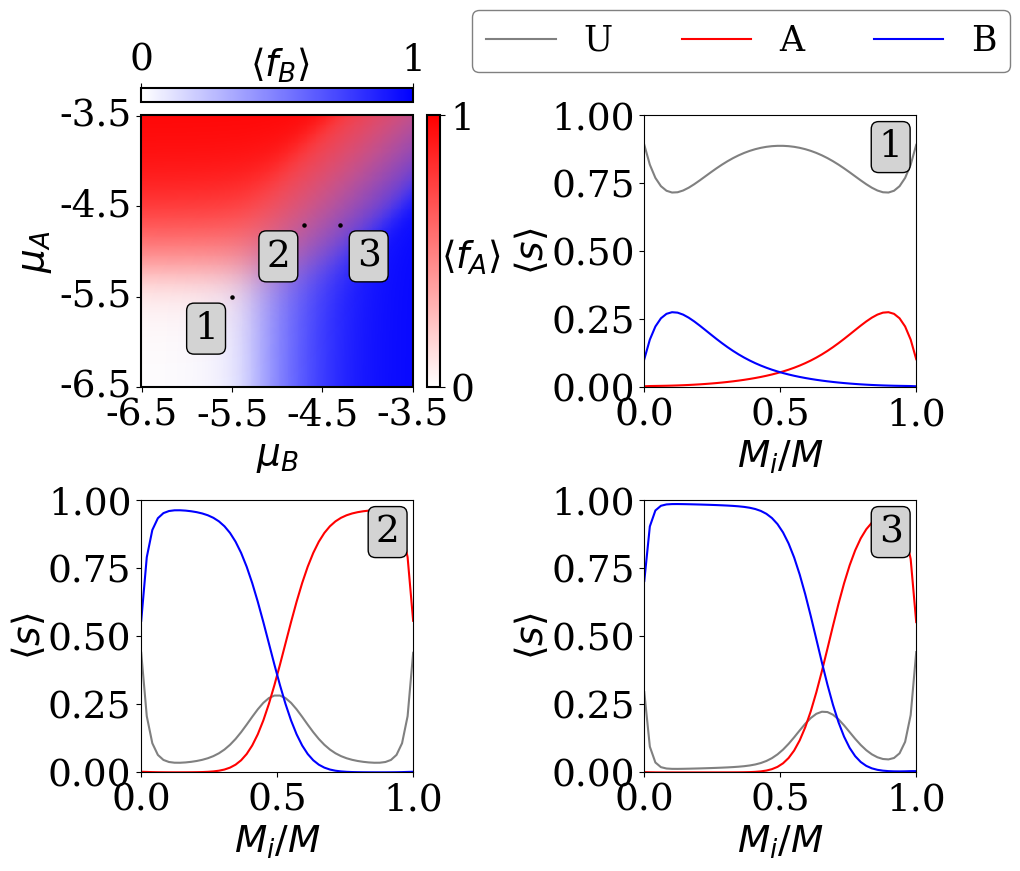

In [48]:
# LARGE FONT
fontsize=27

font = {'family' : 'serif',
        'weight':'normal',
        'size': fontsize}
plt.rc('font', **font)

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 layout

# fig, axes = plt.subplots(2, 2, figsize=(8, 10))  # 2x2 layout

# fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 layout

# Flatten axes array for easier access
ax1, ax2, ax3, ax4 = axes.flatten()

# Plot 1: heatmap on top-left
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

mu2_array = np.round(mu2_arr,2)
mu1_array = np.round(mu1_arr,2)

# fig, ax = plt.subplots(figsize=(4, 5))
ax = ax1

vmin=0
vmax=1
# First heatmap
hm1 = sns.heatmap(fb_mat, linewidth=0.0, cmap=blue_cmap,
                  xticklabels=mu2_array, yticklabels=mu1_array,
                  cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax, rasterized=True)
# pos = ax.get_position()  # get the position of the axes in figure coordinates
# rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
#                          linewidth=1.5, edgecolor='black', facecolor='none',
#                          transform=fig.transFigure, zorder=10)

# fig.patches.append(rect)

# Manually add colorbar 1
cax1 = inset_axes(ax, width="100%", height="5%", loc='upper right',
                  bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
                  bbox_transform=ax.transAxes, borderpad=0)

cb1 = fig.colorbar(hm1.collections[0], cax=cax1, orientation='horizontal', ticks=[0,  1])

# cb1.set_label(r'$ \langle f_B \rangle $')
cb1.outline.set_edgecolor('black')
cb1.outline.set_linewidth(1.5)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb1.ax.text(.4, 1.25, r'$ \langle f_B \rangle $',
            transform=cb1.ax.transAxes,
            fontsize=fontsize, ha='left', va='bottom')
# # Manually add colorbar 1
# cax1 = inset_axes(ax, width="5%", height="50%", loc='upper left',
#                   bbox_to_anchor=(1, 0.1, 1, 1),  # adjust left/right with -0.15
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb1 = fig.colorbar(hm2.collections[0], cax=cax1)
# cb1.set_label(r'$ \langle f_B \rangle $')
# cb1.outline.set_edgecolor('black')
# cb1.outline.set_linewidth(1.5)

# Second heatmap (overlayed)
hm2 = sns.heatmap(fa_mat, linewidth=0.0, cmap=red_cmap,
                  xticklabels=np.round(mu2_array, 3), yticklabels=np.round(mu1_array,3),
                  cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax, rasterized=True)

# # Manually add colorbar 2
# cax2 = inset_axes(ax, width="100%", height="5%", loc='upper right',
#                   bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, orientation='horizontal')
# cb2.set_label(r'$ \langle f_A \rangle $')
# cb2.outline.set_edgecolor('black')
# cb2.outline.set_linewidth(1.5)


# Manually add colorbar 2
cax2 = inset_axes(ax, width="5%", height="100%", loc='upper left',
                  bbox_to_anchor=(1.05, 0.0, 1, 1),  # adjust left/right with -0.15
                  bbox_transform=ax.transAxes, borderpad=0)

cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, ticks=[0, 1])
# cb2.set_label(r'$ \langle f_A \rangle $')
cb2.outline.set_edgecolor('black')
cb2.outline.set_linewidth(1.5)
cb2.ax.text(1.08, 0.55, r'$ \langle f_A \rangle $',
            transform=cb2.ax.transAxes,
            fontsize=fontsize, ha='left', va='top', rotation=0)


# Parameters for the box (adjust these to highlight your region)
x_start = 200       # column index (left edge)
y_start = 200       # row index (top edge)
width = 35         # number of columns to span
height = 35        # number of rows to span

# # Create and add the rectangle
# rect = patches.Rectangle(
#     (x_start, y_start),     # bottom-left corner (note: heatmap coords go left-right, bottom-top)
#     width,
#     height,
#     linewidth=2,
#     edgecolor='black',
#     linestyle='--',
#     facecolor='none', alpha = 0.5
# )

# Add to the same axes as the heatmap
# ax.add_patch(rect)


spacing = 100
# spacing = 1000

# spacing = 10

hm1.set_xticks(hm1.get_xticks()[::spacing])
hm1.set_xticklabels(np.round(mu2_arr[::spacing], 3))
hm1.set_yticks(hm1.get_yticks()[::spacing])
hm1.set_yticklabels(np.round(mu1_arr[::spacing],3))
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=0)  # <- Set labels horizontal here
# ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")
low = [-4-1.5, -4-1.5]
sym = [-3.2-1.5, -3.2-1.5]
cyl = [-3.2-1.5, -2.8-1.5]

#orig
mu1_ind = np.where(np.round(mu1_arr,4) == low[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == low[1])[0][0]
p1 = [mu1_ind, mu2_ind]
mu1_ind = np.where(np.round(mu1_arr,4) == sym[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == sym[1])[0][0]
p2 = [mu1_ind, mu2_ind]
mu1_ind = np.where(np.round(mu1_arr,4) == cyl[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == cyl[1])[0][0]
p3 = [mu1_ind, mu2_ind]

# p1 = [100,100]
# p2 = [175,175]
# p3 = [175, 215]

# ofst=2
# hm1.text(p1[1]-ofst,p1[0]-ofst, "1")
# hm1.text(p2[1]-ofst,p2[0]-ofst, "2")
# hm1.text(p3[1]-ofst,p3[0]-ofst, "3")

# hm1.scatter(100,100, color = "black", s = 5) #1
# hm1.scatter(175,175, color = "black", s = 5) #2
# hm1.scatter(205,175, color = "black", s = 5) #3
# crc = 100
# hm1.scatter(p1[1]+crc,p1[0]+crc, color = "black", s = 5) #1
# hm1.scatter(p2[1]+crc,p2[0]+crc, color = "black", s = 5) #2
# hm1.scatter(p3[1]+crc,p3[0]+crc, color = "black", s = 5) #3

p1x = np.where(np.round(mu2_arr,4) == low[1])[0][0]
p1y = np.where(np.round(mu1_arr,4) == low[0])[0][0]

p2x = np.where(np.round(mu2_arr,4) == sym[1])[0][0]
p2y = np.where(np.round(mu1_arr,4) == sym[0])[0][0]

p3x = np.where(np.round(mu2_arr,4) == cyl[1])[0][0]
p3y = np.where(np.round(mu1_arr,4) == cyl[0])[0][0]

hm1.scatter(p1x,p1y, color = "black", s = 5) #1
hm1.scatter(p2x,p2y, color = "black", s = 5) #2
hm1.scatter(p3x,p3y, color = "black", s = 5) #3

# ofst=10
ofst=15

hm1.text(p1x-ofst,p1y-ofst, "1",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
hm1.text(p2x-ofst,p2y-ofst, "2",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
hm1.text(p3x+ofst*3,p3y-ofst, "3",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# ax.scatter(10,10, marker = "*")
# ax.scatter(10,10, marker = "*")
hm1.invert_yaxis()

hm1.set_ylabel("$\mu_A$")
hm1.set_xlabel("$\mu_B$")



# plt.tight_layout()
# plt.show()

# Plot 2: e.g. line plot on top-right
# mu1 = -4
# mu2 = -4
mu1 = np.round(mu1_arr[p1[0]],2)
mu2 = np.round(mu2_arr[p1[1]],2)

# mu1_ind = np.where(mu1_array == mu1)[0][0]
# mu2_ind = np.where(mu2_array == mu2)[0][0]
mu1_ind = p1[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p1[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]
s_unbnd = 1 - (s_bnd_A+s_bnd_B)

xvals = np.linspace(0,1,len(s_bnd_A))


ax2.plot(xvals, s_unbnd, color = "grey", label = "U")

ax2.plot(xvals, s_bnd_A, color = "red", label = "A")
ax2.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax2.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax2.set_xlim(0,1)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax2.set_xticks([0, 0.25, 0.5, 0.75, 1])

# ax2.set_xlabel("M")
ax2.set_xlabel(r"$M_i/M$")

ax2.set_ylabel(r"$\langle s \rangle$", labelpad=0)
# ax2.plot(x_vals, y_vals, color='red')
# ax2.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 17)

# Plot 3: e.g. bar plot bottom-left

mu1 = np.round(mu1_arr[p2[0]],2)
mu2 = np.round(mu2_arr[p2[1]],2)

# mu1_ind = np.where(np.round(mu1_array,2) == mu1)[0][0]
# mu2_ind = np.where(np.round(mu2_array,2) == mu2)[0][0]
mu1_ind = p2[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p2[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]

s_unbnd = 1 - (s_bnd_A+s_bnd_B)

ax3.plot(xvals, s_unbnd, color = "grey", label = "U")

ax3.plot(xvals, s_bnd_A, color = "red", label = "A")
ax3.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax3.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax3.set_xlim(0,1)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax3.set_xticks([0, 0.25, 0.5, 0.75, 1])

ax3.set_xlabel(r"$M_i/M$")
ax3.set_ylabel(r"$\langle s \rangle$" ,labelpad = 0)
# ax3.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 17)
# Plot 4: e.g. scatter plot bottom-right

# mu1 = np.round(mu1_arr[175],2)
# mu2 = np.round(mu2_arr[205],2)
mu1 = np.round(mu1_arr[p3[0]],2)
mu2 = np.round(mu2_arr[p3[1]],2)

mu1_ind = p3[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p3[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]


s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]

s_unbnd = 1 - (s_bnd_A+s_bnd_B)

ax4.plot(xvals, s_unbnd, color = "grey", label = "U")

ax4.plot(xvals, s_bnd_A, color = "red", label = "A")
ax4.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax4.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax4.set_xlim(0,1)
ax4.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax4.set_xticks([0, 0.25, 0.5, 0.75, 1])


# ax4.set_xlabel("M")
ax4.set_xlabel(r"$M_i/M$")

ax4.set_ylabel(r"$\langle s \rangle$", labelpad = 0)
# ax4.scatter(x_scatter, y_scatter)
# ax4.set_title("Scatter Plot")
# ax4.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 17)

# plt.tight_layout()

# Adjust spacing between subplots
# fig.subplots_adjust(wspace=0.125, hspace=0.55)

fig.subplots_adjust(wspace=0.85, hspace=0.)


# Gather legend handles from one plot (they're identical)
handles, labels = ax2.get_legend_handles_labels()

# # Add a single legend on the right side of the figure
# # fig.legend(handles, labels, loc='center right', title="States", fontsize=fontsize, title_fontsize=fontsize+1, bbox_to_anchor=(1.08, 0.5))
# fig.legend(handles, labels, loc='center right', fontsize=fontsize, bbox_to_anchor=(1.08, 0.5))

# fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
# Shift the figure layout to make room for the legend
# fig.subplots_adjust(right=0.95)  # adjust as needed

pos = ax.get_position()  # get the position of the axes in figure coordinates
rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
                         linewidth=1.5, edgecolor='black', facecolor='none',
                         transform=fig.transFigure, zorder=10)

fig.patches.append(rect)

fig.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.725, .85),  # (x, y)
           ncol=3,
           frameon=True,
           framealpha=1,
           edgecolor='grey',
           fontsize=fontsize-2)

# Add "1" inside ax2 (top-right)
ax2.text(0.95, 0.95, "1", transform=ax2.transAxes,
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# Add "2" inside ax3 (bottom-left)
ax3.text(0.95, 0.95, "2", transform=ax3.transAxes,
     
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# Add "3" inside ax4 (bottom-right)
ax4.text(0.95, 0.95, "3", transform=ax4.transAxes,
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
# plt.show()
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

# plt.savefig('bindingmap_fig3_ALT.eps', format='eps')
# plt.savefig('bingingmap_fig3.pdf', format='pdf')

# plt.savefig('bindingmap_fig3_ALT.png')
plt.savefig('bindingmap_fig3_ALT_final.pdf', format = "pdf")
plt.savefig('bindingmap_fig3_ALT_final.png')
plt.show()

In [115]:
plt.savefig('bindingmap_fig3_ALT_final.png')

<Figure size 640x480 with 0 Axes>

# Phase diag + binding proflies

In [2]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # XN50zoom
# mu_max_1 = -2#8#0.1 #10
# mu_min_1 = -4#-9
# del_mu_1 = .1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# XN50zoom
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_eigvecrest_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_eigvecrest_chiABphipNeq49N=5000.npy")

N = 5000
phi_p = 0.7
chi_AB_loaded = 50 / (phi_p * N)
result_arr = np.load("OABS_phases_arr_ALT_XN50_eigvect_fine_chiABphipNeq49N=5000.npy")
phases = np.array([])#np.zeros((len(mu1_arr), len(mu2_arr))) - 1
# phz = np.array([])
for i, result in enumerate(result_arr):
    if len(phases)==0:
        phases = result
    else:
        phases = np.vstack((phases, result))

phases = phases.astype(int)
# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")


## spinodal

In [6]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # XN50zoom
# mu_max_1 = -2#8#0.1 #10
# mu_min_1 = -4#-9
# del_mu_1 = .1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# XN50zoom veryfine
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = 0.0025 # 0.0025
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

In [108]:
mu1_arr.shape

(800,)

### calc spinodal

In [186]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)

CPU times: total: 8h 1min 20s
Wall time: 8h 13min 59s


In [187]:
np.save("xn50_spin_ALT_sbindA.npy", s_bind_A_ALL)
np.save("xn50_spin_ALT_sbindB.npy", s_bind_B_ALL)

In [188]:
%%time
# k* stability analysis NUMBER DENSITY THEORY
assert competitive == True
# chi = 0#5*N/N

min_eigval_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))

min_eigvec_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_arr[:]), len(mu2_arr[:]))) 

cond_num_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))

# # PRETTY GOOD but no spinodal, just all macro seps
# chi_AB = 200 / (rho_p*N) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
# chi_AS = 910 / N #834 / N


# # same as above :(
# chi_AB = 00 / (rho_p*N) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
# chi_AS = 910 / N #834 / N

# 
chi_AB = 50 / (phi_p*N) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
chi_AS = 00 / N #834 / N
chis = [chi_AB, chi_AS]
for i, mu1 in enumerate(mu1_arr):
    for j, mu2 in enumerate(mu2_arr):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):

            # S2_mat = (M**2 / N**2) * s2_mats[i][j][ik].copy()
            # S2_mat[3,3] /= (M**2 / N**2)
            # print("M2 FACTOR!!!")

            

            s_bnd_A = s_bind_A_ALL[i, j]
            s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, k, chis, competitive)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

CPU times: total: 4h 41min 8s
Wall time: 4h 48min 44s


In [189]:
np.save("spin_kstar_xn50_ALT_eigvecrest_N=5k_XN=13.npy", k_star_arr_DENS)
np.save("spin_mineigval_xn50_ALT_eigvecrest_N=5k_XN=13.npy", min_eigval_arr_allk_DENS)

### load spinodal

In [8]:
k_star_arr_DENS = np.load("spin_kstar_xn50_ALT_eigvecrest_N=5k_XN=13.npy")
min_eigval_arr_allk_DENS = np.load("spin_mineigval_xn50_ALT_eigvecrest_N=5k_XN=13.npy")

### plot spinodal

In [10]:
# spinodal_phases_shift = np.copy(phases)
# spinodal_phases_shift[np.where(phases!=0)] = -1

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1
spinodal_phases_shift = np.copy(k_star_arr_DENS)
spinodal_phases_shift[np.where(k_star_arr_DENS<0)] = 0
spinodal_phases_shift[np.where(k_star_arr_DENS>0)] = -1

X = spinodal_phases_shift

upper = np.triu(X)
# upper[np.where(upper == 0)] = 0

lower = np.tril(X)
# lower[np.where(lower == 0)] = 0

# WORKS!
mu1_array= mu1_arr
mu2_array= mu2_arr

spin_right = np.zeros((X.shape[0],2))
spin_left = np.zeros((X.shape[0],2))

for i in range(X.shape[0]): # for each row in spinodal diagram (mu1 row)
    #find crossover arr
    mu1 = mu1_array[i]
    # print("mu1: ", mu1)
    # a = upper[i]
    a = X[i]
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    # print(signchange)

    if np.sum(signchange) == 0: # no boundary at this 
        mu2_vals = [np.nan]
        # spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, mu2_vals[0]] 
        spin_left[i] = [mu1, mu2_vals[0]]

    elif np.sum(signchange) == 1: # outer boundary cut off
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, np.nan] 
    else:
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, np.min(mu2_vals)]
        spin_right[i] = [mu1, np.max(mu2_vals)] 

# a = cyl_right_inner
spin_left = spin_left[~np.isnan(spin_left).any(axis=1)]    
# cyl_right_outer = spin_left[~np.isnan(spin_left).any(axis=1)]    
spin_right = spin_right[~np.isnan(spin_right).any(axis=1)]    
# cyl_left_outer = cyl_left_outer[~np.isnan(cyl_left_outer).any(axis=1)]  

spin_right_app = np.vstack([spin_left[0], spin_right])
spin_left_app = np.vstack([spin_right[0], spin_left])


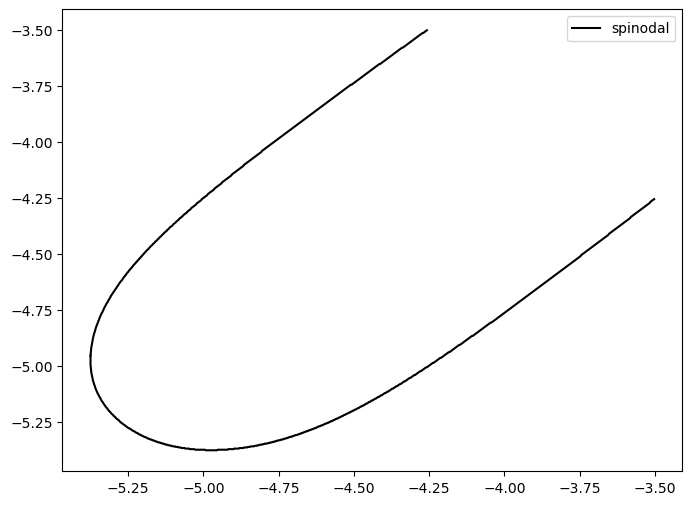

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
# import numpy as np


plt.figure(figsize=(8, 6))


plt.plot(spin_left_app[:,0], spin_left_app[:,1], color = "black", label = "spinodal")
plt.plot(spin_right[:,0], spin_right[:,1], color = "black")
# plt.scatter(9,8)
plt.legend()
plt.show()


## phases

In [14]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # XN50zoom
# mu_max_1 = -2#8#0.1 #10
# mu_min_1 = -4#-9
# del_mu_1 = .1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# XN50zoom
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_eigvecrest_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_eigvecrest_chiABphipNeq49N=5000.npy")

N = 5000
phi_p = 0.7
chi_AB_loaded = 50 / (phi_p * N)
result_arr = np.load("OABS_phases_arr_ALT_XN50_eigvect_fine_chiABphipNeq49N=5000.npy")
phases = np.array([])#np.zeros((len(mu1_arr), len(mu2_arr))) - 1
# phz = np.array([])
for i, result in enumerate(result_arr):
    if len(phases)==0:
        phases = result
    else:
        phases = np.vstack((phases, result))

phases = phases.astype(int)
# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")


In [16]:
len(mu1_arr)

80

Text(0.5, 1.0, '$OABS \\ phases, unres, $N = 5000,  $N \\phi_p \\chi_{AB} = $50.0, $N\\chi_{OS} = N\\chi_{AS} = N\\chi_{BS} =$0, $v_{int} = $ [[-4  4],[ 4 -4]]\n')

<Figure size 640x480 with 0 Axes>

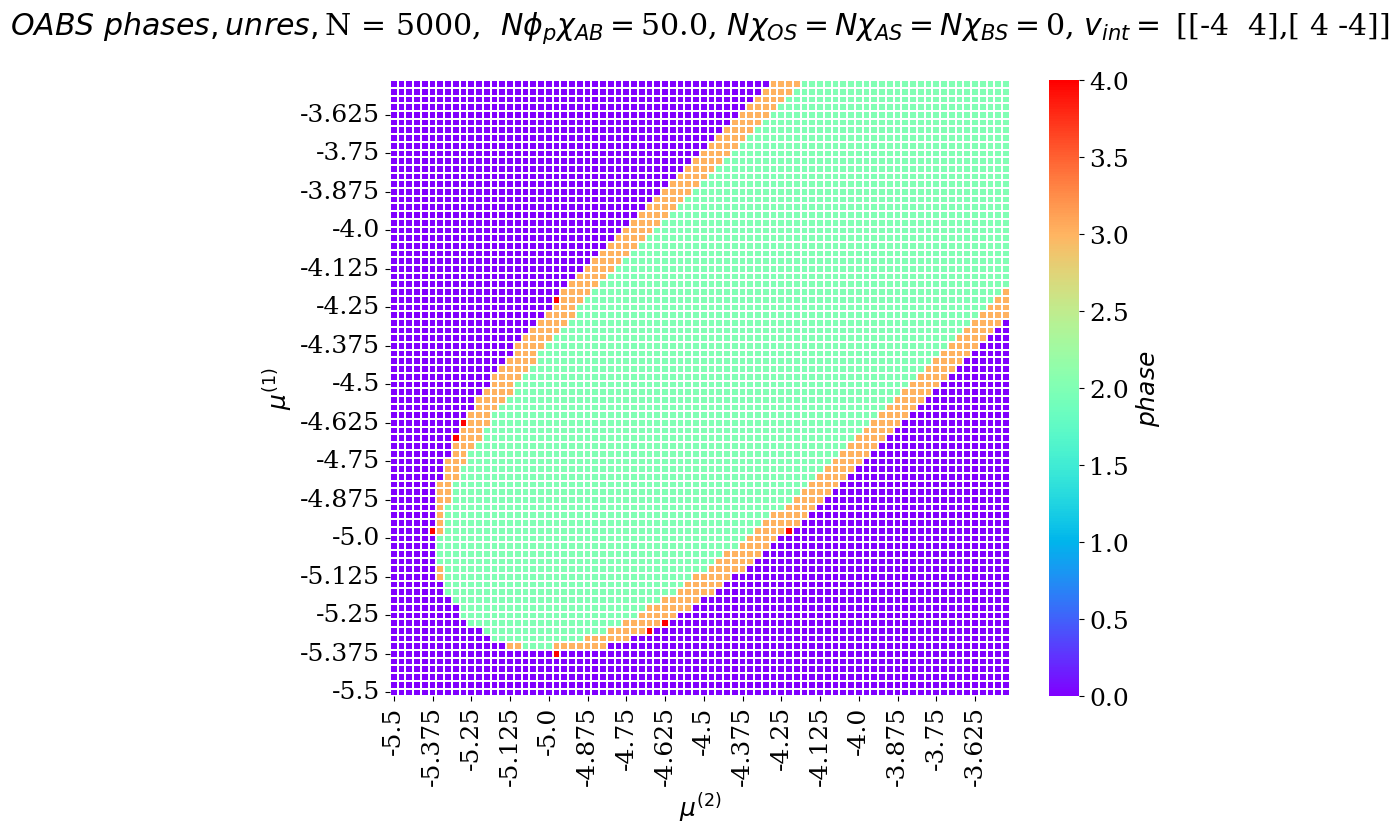

In [18]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

mu1_array = np.round(mu1_arr, 4)
mu2_array = np.round(mu2_arr, 4)
# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array, yticklabels=mu1_array,\
                 cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=4)

spacing = 5
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$OABS \ phases, unres, $" +  "N = %s, " % N + " $N \phi_p \chi_{AB} = $" + \
          str(chi_AB_loaded*N*phi_p) \
          + ", $N\chi_{OS} = N\chi_{AS} = N\chi_{BS} =$" + str(N*0)  
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")

# plt.savefig('OABS_phases.png')

In [20]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)

CPU times: total: 3min 53s
Wall time: 4min 2s


In [49]:
mu1

-3.5024999999996878

In [50]:
mu1_array[8]

-5.3

In [51]:
np.where(mu1_array == mu1)

(array([], dtype=int64),)

Text(0, 0.5, '$\\langle s \\rangle$')

<Figure size 640x480 with 0 Axes>

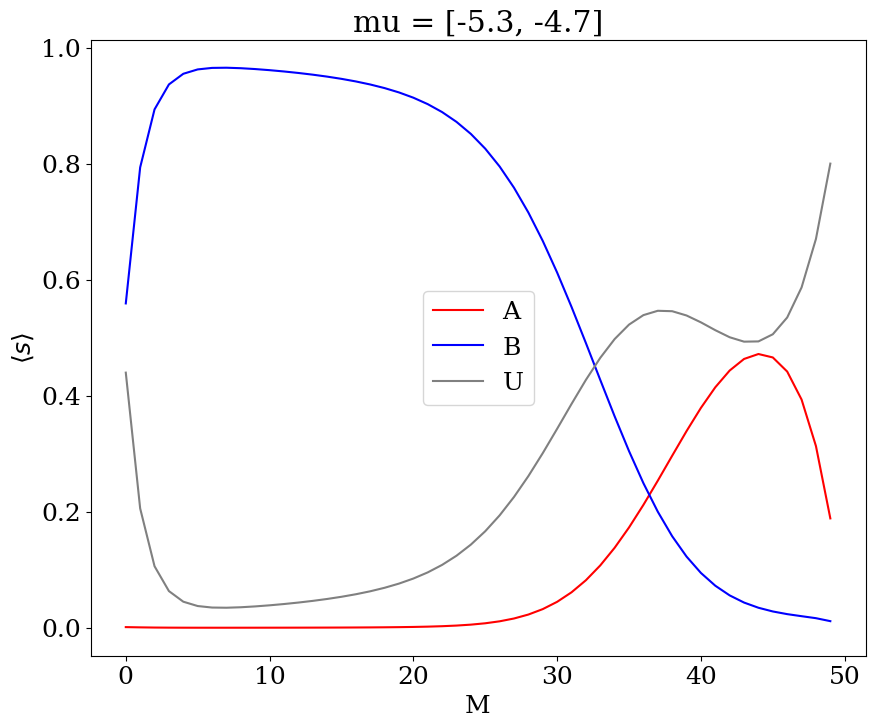

In [52]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

mu1 = np.round(-3.8-1.5, 1)
mu2 = -3.2-1.5

mu1_ind = np.where(mu1_array == mu1)[0][0]
mu2_ind = np.where(mu2_array == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]
s_unbnd = 1 - (s_bnd_A+s_bnd_B)

plt.plot(np.arange(len(s_bnd_A)), s_bnd_A, color = "red", label = "A")
plt.plot(np.arange(len(s_bnd_A)), s_bnd_B, color = "blue", label = "B")
plt.plot(np.arange(len(s_bnd_A)), s_unbnd, color = "grey", label = "U")
plt.legend()
plt.title(r"mu = [%s, %s]" % (mu1, mu2))
plt.xlabel("M")
plt.ylabel(r"$\langle s \rangle$")

-5.074999999999994


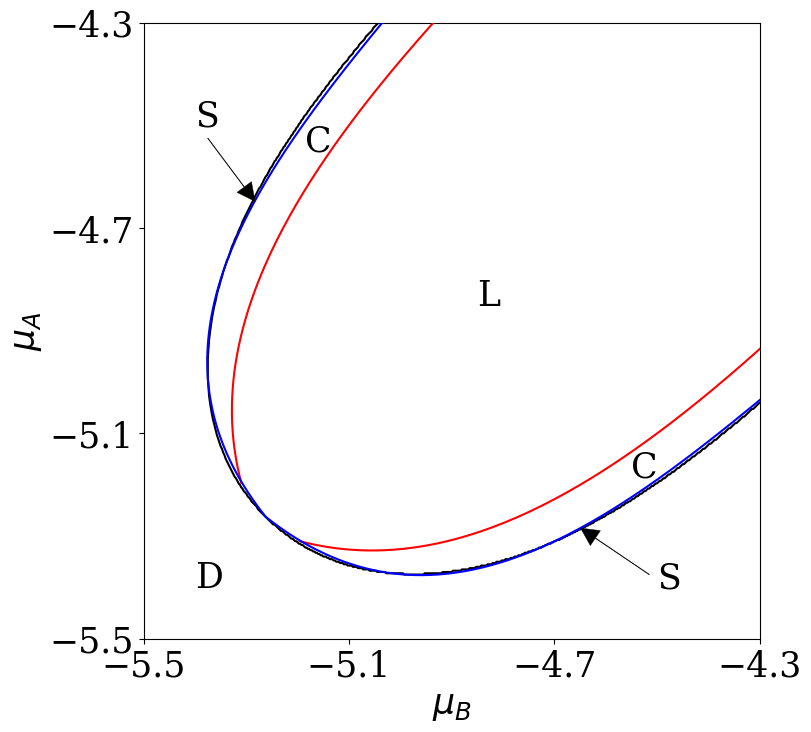

In [21]:


# IMPROVED


import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
# ax.scatter(-5.261, -5.261)
# ax.scatter(-5.231, -5.291)
# ax.scatter(-5.201, -5.309)
# ax.scatter(-5.171, -5.329)

font = {'family' : 'serif',
        'weight':'normal',
        'size': 25}
plt.rc('font', **font)
# plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(10, 8))


manual_points = {
    2: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)],  # (mu_B, mu_A)
    4: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)]
}

phase_map = phases

# Get boundaries
boundaries = find_boundaries(phase_map, mode='outer')
boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)

# Get unique nonzero phases
unique_phases = np.unique(phase_map)
unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0



# fig.patch.set_facecolor('white')   # Figure background
# ax.set_facecolor('white')          # Axes background
color_set = ["red", "blue", "red", "blue", "blue"]
for phase in unique_phases:
    if phase == 3:
        continue

    # Mask of the current phase
    mask = phase_map == phase

    # Get boundary coords that belong to this phase
    phase_boundary_pts = []
    for y, x in boundary_coords:
        if mask[y, x]:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                    if phase_map[ny, nx] != phase:
                        if y < x:  # upper diagonal condition
                            phase_boundary_pts.append((y, x))
                        break

    if len(phase_boundary_pts) == 0:
        continue

    phase_boundary_pts = np.array(phase_boundary_pts)
    rows = phase_boundary_pts[:, 0]
    cols = phase_boundary_pts[:, 1]

    # Convert to coordinate values
    mu1_vals = mu1_arr[rows]
    mu2_vals = mu2_arr[cols]

        # Add manual points if available
    if phase in manual_points:
        extra = np.array(manual_points[phase])
        mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
        mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])

    sort_idx = np.argsort(mu2_vals)
    mu2_vals = mu2_vals[sort_idx]
    mu1_vals = mu1_vals[sort_idx]
    if phase ==2: 
        print(mu2_vals[7]) 
        mu1_vals[7]+=0.02
        mu1_vals[8]+=0.02


    x = mu2_vals
    y = mu1_vals
    
    from scipy.interpolate import UnivariateSpline
    # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
    spline = UnivariateSpline(x, y, s=1e-2)  # Try s=1e-4 to s=1e-2
    
    # Evaluate smoothed curve
    if phase ==2:
        x_fit = np.linspace(x.min()+.065, x.max(), 300)
    else:
        x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = spline(x_fit)
    if phase ==4:
        y_fit += 0.0025
    ax.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    ax.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    
    # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)


ax.set_xlabel('$\mu_B$')
ax.set_ylabel('$\mu_A$')
ax.axis('equal')
# ax.grid(True)
# ax.legend()
# ax.set_title("Fitted & Reflected Phase Boundaries")
# plt.show()
ax.grid(False)
ax.plot(spin_left_app[:,0], spin_left_app[:,1], color = "black", label = "spinodal")
ax.plot(spin_right[:,0], spin_right[:,1], color = "black")
ax.set_xlim(-4-1.5, -2.8-1.5)
ax.set_ylim(-4-1.5, -2.8-1.5)

ticks = np.linspace(-4-1.5, -2.8-1.5, 4)  # 6 ticks, or adjust as you want

# Set identical ticks
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# ax.legend()

plt.text(-4.55, -5.185, "C")
plt.text(-4.85, -4.85, "L")
plt.text(-5.185, -4.55, "C")
plt.text(-5.4, -5.4, "D")
# plt.arrow(-2.935, -2.875, 0.05, 0.05)
plt.text(-3.9-1.5, -3-1.5, "S")
plt.text(-3-1.5, -3.9-1.5, "S")
arrow1_origx = -3.875-1.5
arrow1_origy = -3.025-1.5
plt.arrow(arrow1_origx, arrow1_origy, .071, -0.125+0.03, zorder=10, linewidth = .3,\
          color = "black", head_width=0.035, head_length=0.035)
plt.arrow(arrow1_origy+0.01, arrow1_origx, -0.125+0.02,.071, zorder=10, linewidth = .3,\
          color = "black", head_width=0.035, head_length=0.035)
# plt.arrow(arrow1_origy, arrow1_origx,-0.025+0.01,  2.85 -2.935 +0.02, zorder=10,  linewidth = .3, color = "black")
# ax.scatter(-5.261, -5.261)


ax.set_adjustable('box')  # Maintain aspect ratio if needed
ax.set_aspect('equal')    # Force 1:1 aspect ratio

plt.show()


-5.074999999999994


C:\Users\tmhab\AppData\Local\Temp\ipykernel_30672\749760108.py:246: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leaves 5% at the bottom for the legend


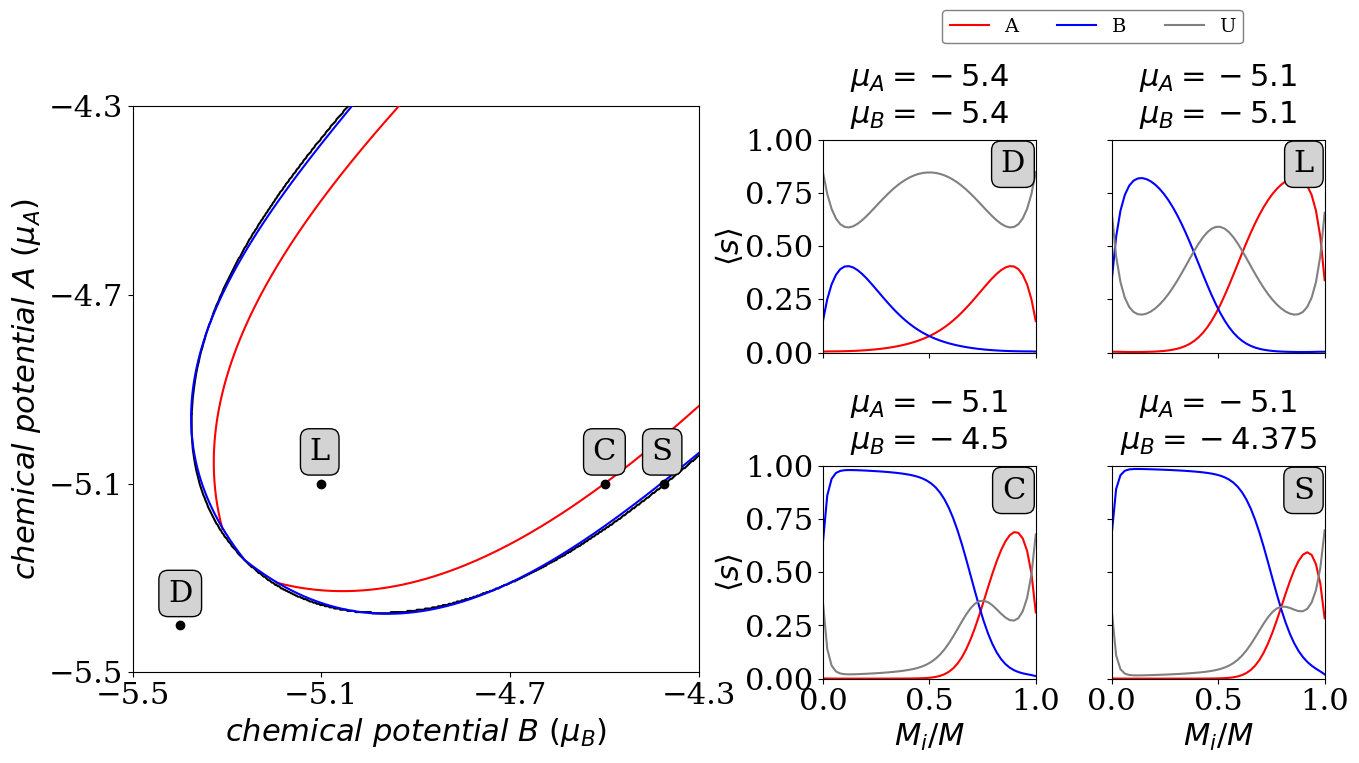

In [22]:


###### #TESTING


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from skimage.segmentation import find_boundaries

font_size = 22
# Set font globally
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': font_size
})

# Create figure and GridSpec layout
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[2.66, 1, 1], wspace=0.375, hspace=0.125)
mu1_array = mu1_arr
mu2_array = mu2_arr

# ========== Phase diagram (left half) ==========
ax_phase = fig.add_subplot(gs[:, 0])

manual_points = {
    2: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)],  # (mu_B, mu_A)
    4: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)]
}

phase_map = phases

# Get boundaries
boundaries = find_boundaries(phase_map, mode='outer')
boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)

# Get unique nonzero phases
unique_phases = np.unique(phase_map)
unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0



# fig.patch.set_facecolor('white')   # Figure background
# ax.set_facecolor('white')          # Axes background
color_set = ["red", "blue", "red", "blue", "blue"]
for phase in unique_phases:
    if phase == 3:
        continue

    # Mask of the current phase
    mask = phase_map == phase

    # Get boundary coords that belong to this phase
    phase_boundary_pts = []
    for y, x in boundary_coords:
        if mask[y, x]:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                    if phase_map[ny, nx] != phase:
                        if y < x:  # upper diagonal condition
                            phase_boundary_pts.append((y, x))
                        break

    if len(phase_boundary_pts) == 0:
        continue

    phase_boundary_pts = np.array(phase_boundary_pts)
    rows = phase_boundary_pts[:, 0]
    cols = phase_boundary_pts[:, 1]

    # Convert to coordinate values
    mu1_vals = mu1_arr[rows]
    mu2_vals = mu2_arr[cols]

        # Add manual points if available
    if phase in manual_points:
        extra = np.array(manual_points[phase])
        mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
        mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])

    sort_idx = np.argsort(mu2_vals)
    mu2_vals = mu2_vals[sort_idx]
    mu1_vals = mu1_vals[sort_idx]
    if phase ==2: 
        print(mu2_vals[7]) 
        mu1_vals[7]+=0.02
        mu1_vals[8]+=0.02


    x = mu2_vals
    y = mu1_vals
    
    from scipy.interpolate import UnivariateSpline
    # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
    spline = UnivariateSpline(x, y, s=1e-2)  # Try s=1e-4 to s=1e-2
    
    # Evaluate smoothed curve
    if phase ==2:
        x_fit = np.linspace(x.min()+.065, x.max(), 300)
    else:
        x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = spline(x_fit)
    if phase ==4:
        y_fit += 0.0025
    ax_phase.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    ax_phase.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    
    # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)


ax_phase.set_xlabel('$\mu_B$')
ax_phase.set_ylabel('$\mu_A$')
# ax.grid(True)
# ax.legend()
# ax.set_title("Fitted & Reflected Phase Boundaries")
# plt.show()
ax_phase.grid(False)
ax_phase.plot(spin_left_app[:,0], spin_left_app[:,1], color = "black", label = "spinodal")
ax_phase.plot(spin_right[:,0], spin_right[:,1], color = "black")
points = {
    "S": [-3.8, -3.2],
    "C": [-3.8, -3.3],
    "L": [-3.8, -3.55],
    "D": [-3.9, -3.9],
}

points = {
    "S": [-3.6-1.5, -2.875-1.5],
    "C": [-3.6-1.5, -2.975-1.5-0.025],
    "L": [-3.6-1.5, -3.6-1.5],
    "D": [-3.9-1.5, -3.9-1.5],
}

for label, (mu1, mu2) in points.items():
    ax_phase.scatter(mu2, mu1, label=label, color = "black", zorder = 10)
    # if label == "S":
    #     ax_phase.text(mu2-0.05, mu1+0.05, label, zorder = 10)
    # else:    
    ax_phase.text(mu2-0.025, mu1+0.05, label, zorder = 10,\
                  bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.3'))
ax_phase.set_xlabel(r'$chemical \ potential \ B \ (\mu_B)$')
ax_phase.set_ylabel(r'$chemical \ potential \ A \ (\mu_A)$')

ax_phase.set_yticks(ax_phase.get_xticks())

ax_phase.set_xlim(-4-1.5, -2.8-1.5)
ax_phase.set_ylim(-4-1.5, -2.8-1.5)
ticks = np.linspace(-4-1.5, -2.8-1.5, 4)  # 6 ticks, or adjust as you want

# Set identical ticks
ax_phase.set_xticks(ticks)
ax_phase.set_yticks(ticks)

# ax_phase.axis('equal')
# ax_phase.set_aspect('equal')
# ax_phase.set_box_aspect(1)

ax_phase.set_adjustable('box')  # Maintain aspect ratio if needed
ax_phase.set_aspect('equal')    # Force 1:1 aspect ratio


ax_phase.grid(False)
# ax_phase.legend()
# Set same number of ticks (4 each)
# x_ticks = np.linspace(-3, -2.65, 7)
# y_ticks = np.linspace(-3, -2.65, 7)
# ax_phase.set_xticks(x_ticks)
# ax_phase.set_yticks(y_ticks)
# ax_phase.text(
# ========== Binding profiles ==========
# New order: D, C, B, A
labels = ['D', 'L', 'C', 'S']
point_list = [points['D'], points['L'], points['C'], points['S']]

for i in range(4):
    row, col = divmod(i, 2)
    ax = fig.add_subplot(gs[row, col+1])
    pos = ax.get_position()
    if col == 1:
        ax.set_position([pos.x0 - 0.03, pos.y0 - 0.025, pos.width, pos.height])
    else:
        ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])
    # ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])  # shift down by 0.05 in figure coords
    mu1, mu2 = point_list[i]
    mu1_ind = np.where(np.round(mu1_array, 4) == mu1)[0][0]
    mu2_ind = np.where(np.round(mu2_array, 4) == mu2)[0][0]

    s_bnd_A = s_bind_A_ALL[mu1_ind, mu2_ind, :]
    s_bnd_B = s_bind_B_ALL[mu1_ind, mu2_ind, :]
    s_unbnd = 1 - (s_bnd_A + s_bnd_B)

    xvals = np.linspace(0,1,len(s_bnd_A))

    ax.plot(xvals, s_bnd_A, color='red', label="A")#, linestyle = "dashed")
    ax.plot(xvals, s_bnd_B, color='blue', label="B")#, linestyle = "dashed")
    ax.plot(xvals, s_unbnd, color='grey', label="U")#, linestyle = "dashed")
    # ax.set_title(r"$\mu = [%s, %s]$" % (mu1, mu2),  pad=12)
    # ax.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 12)
    ax.set_title(r"$\mu_A = %s$" % mu1 + "\n" + "$\mu_B = %s$" % (mu2), pad = 12, fontsize=font_size)

    ax.set_xlabel("M")
    ax.set_ylabel(r"$\langle s \rangle$")
    # ax.legend()
    # Set y axis from 0 to 1
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    # Set x-axis limits to data range (e.g., length of your binding data)
    # ax.set_xlim(0, len(s_bnd_A) - 1)
    ax.set_xlim(0, 1)

    # Make the plot square
    ax.set_box_aspect(1)
    # ax.set_aspect('equal', adjustable='box')
    # ax.set_aspect('equal', adjustable='box')
    # Set y label only on left plots
    if col == 0:
        ax.set_ylabel(r"$\langle s \rangle$", labelpad = 0)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel("")
        

    # Set x label only on bottom plots
    if row == 1:
        # ax.set_xlabel("$M$")
        ax.set_xlabel(r"$M_i/M$")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    # Add grey box label
    ax.text(0.95, 0.95, labels[i], ha='right', va='top',
            transform=ax.transAxes,
            bbox=dict(facecolor='lightgrey', boxstyle='round,pad=0.3'))
# After binding profile subplots
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, fontsize=14)
fig.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.725, .915),  # (x, y)
           ncol=3,
           frameon=True,
           framealpha=1,
           edgecolor='grey',
           fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leaves 5% at the bottom for the legend
# plt.savefig("phase_diag_binding_fig4_ALT.eps", format = "eps")
# plt.savefig("phase_diag_binding_fig4_ALT.png")
plt.savefig("phase_diag_binding_fig4_ALT.pdf", format = "pdf")

plt.show()


-5.074999999999994


C:\Users\tmhab\AppData\Local\Temp\ipykernel_30672\3989719756.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leaves 5% at the bottom for the legend


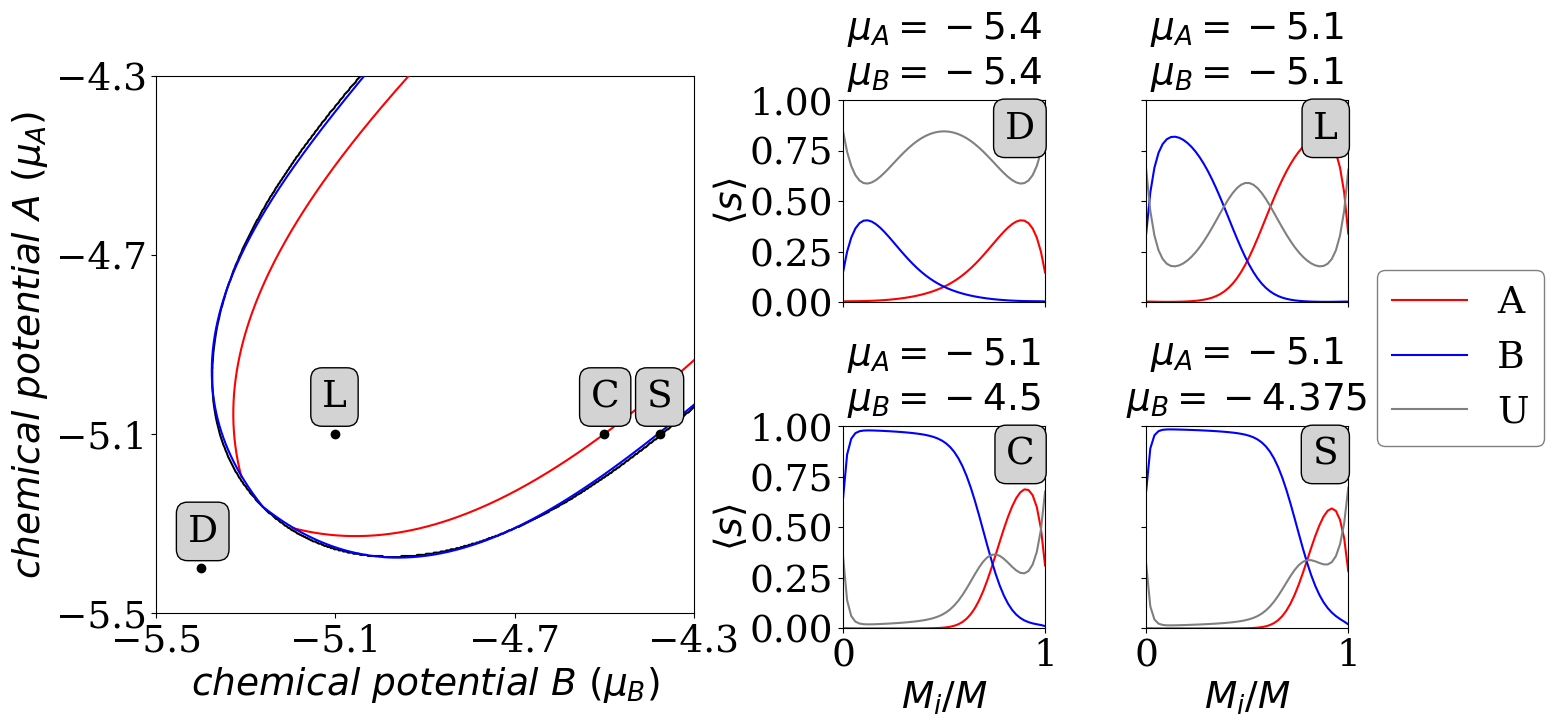

In [60]:


###### LARGE FONT


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from skimage.segmentation import find_boundaries

font_size = 27
# Set font globally
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': font_size
})

# Create figure and GridSpec layout
fig = plt.figure(figsize=(16, 8))
# gs = fig.add_gridspec(2, 3, width_ratios=[2.66, 1, 1], wspace=0.375, hspace=0.125)
gs = fig.add_gridspec(2, 3, width_ratios=[2.66, 1, 1], wspace=0.475, hspace=0.125)
mu1_array = mu1_arr
mu2_array = mu2_arr

# ========== Phase diagram (left half) ==========
ax_phase = fig.add_subplot(gs[:, 0])

manual_points = {
    2: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)],  # (mu_B, mu_A)
    4: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)]
}

phase_map = phases

# Get boundaries
boundaries = find_boundaries(phase_map, mode='outer')
boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)

# Get unique nonzero phases
unique_phases = np.unique(phase_map)
unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0



# fig.patch.set_facecolor('white')   # Figure background
# ax.set_facecolor('white')          # Axes background
color_set = ["red", "blue", "red", "blue", "blue"]
for phase in unique_phases:
    if phase == 3:
        continue

    # Mask of the current phase
    mask = phase_map == phase

    # Get boundary coords that belong to this phase
    phase_boundary_pts = []
    for y, x in boundary_coords:
        if mask[y, x]:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                    if phase_map[ny, nx] != phase:
                        if y < x:  # upper diagonal condition
                            phase_boundary_pts.append((y, x))
                        break

    if len(phase_boundary_pts) == 0:
        continue

    phase_boundary_pts = np.array(phase_boundary_pts)
    rows = phase_boundary_pts[:, 0]
    cols = phase_boundary_pts[:, 1]

    # Convert to coordinate values
    mu1_vals = mu1_arr[rows]
    mu2_vals = mu2_arr[cols]

        # Add manual points if available
    if phase in manual_points:
        extra = np.array(manual_points[phase])
        mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
        mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])

    sort_idx = np.argsort(mu2_vals)
    mu2_vals = mu2_vals[sort_idx]
    mu1_vals = mu1_vals[sort_idx]
    if phase ==2: 
        print(mu2_vals[7]) 
        mu1_vals[7]+=0.02
        mu1_vals[8]+=0.02


    x = mu2_vals
    y = mu1_vals
    
    from scipy.interpolate import UnivariateSpline
    # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
    spline = UnivariateSpline(x, y, s=1e-2)  # Try s=1e-4 to s=1e-2
    
    # Evaluate smoothed curve
    if phase ==2:
        x_fit = np.linspace(x.min()+.065, x.max(), 300)
    else:
        x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = spline(x_fit)
    if phase ==4:
        y_fit += 0.0025
    ax_phase.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    ax_phase.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    
    # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)


ax_phase.set_xlabel('$\mu_B$')
ax_phase.set_ylabel('$\mu_A$')
# ax.grid(True)
# ax.legend()
# ax.set_title("Fitted & Reflected Phase Boundaries")
# plt.show()
ax_phase.grid(False)
ax_phase.plot(spin_left_app[:,0], spin_left_app[:,1], color = "black", label = "spinodal")
ax_phase.plot(spin_right[:,0], spin_right[:,1], color = "black")
points = {
    "S": [-3.8, -3.2],
    "C": [-3.8, -3.3],
    "L": [-3.8, -3.55],
    "D": [-3.9, -3.9],
}

points = {
    "S": [-3.6-1.5, -2.875-1.5],
    "C": [-3.6-1.5, -2.975-1.5-0.025],
    "L": [-3.6-1.5, -3.6-1.5],
    "D": [-3.9-1.5, -3.9-1.5],
}

for label, (mu1, mu2) in points.items():
    ax_phase.scatter(mu2, mu1, label=label, color = "black", zorder = 10)
    # if label == "S":
    #     ax_phase.text(mu2-0.05, mu1+0.05, label, zorder = 10)
    # else:    
    ax_phase.text(mu2-0.025-0.005, mu1+0.05+0.01, label, zorder = 10,\
                  bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.3'))
ax_phase.set_xlabel(r'$chemical \ potential \ B \ (\mu_B)$')
ax_phase.set_ylabel(r'$chemical \ potential \ A \ (\mu_A)$')

ax_phase.set_yticks(ax_phase.get_xticks())

ax_phase.set_xlim(-4-1.5, -2.8-1.5)
ax_phase.set_ylim(-4-1.5, -2.8-1.5)
ticks = np.linspace(-4-1.5, -2.8-1.5, 4)  # 6 ticks, or adjust as you want

# Set identical ticks
ax_phase.set_xticks(ticks)
ax_phase.set_yticks(ticks)

# ax_phase.axis('equal')
# ax_phase.set_aspect('equal')
# ax_phase.set_box_aspect(1)

ax_phase.set_adjustable('box')  # Maintain aspect ratio if needed
ax_phase.set_aspect('equal')    # Force 1:1 aspect ratio


ax_phase.grid(False)
# ax_phase.legend()
# Set same number of ticks (4 each)
# x_ticks = np.linspace(-3, -2.65, 7)
# y_ticks = np.linspace(-3, -2.65, 7)
# ax_phase.set_xticks(x_ticks)
# ax_phase.set_yticks(y_ticks)
# ax_phase.text(
# ========== Binding profiles ==========
# New order: D, C, B, A
labels = ['D', 'L', 'C', 'S']
point_list = [points['D'], points['L'], points['C'], points['S']]

for i in range(4):
    row, col = divmod(i, 2)
    ax = fig.add_subplot(gs[row, col+1])
    pos = ax.get_position()
    if col == 1:
        ax.set_position([pos.x0 - 0.03, pos.y0 - 0.025, pos.width, pos.height])
    else:
        ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])
    # ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])  # shift down by 0.05 in figure coords
    mu1, mu2 = point_list[i]
    mu1_ind = np.where(np.round(mu1_array, 4) == mu1)[0][0]
    mu2_ind = np.where(np.round(mu2_array, 4) == mu2)[0][0]

    s_bnd_A = s_bind_A_ALL[mu1_ind, mu2_ind, :]
    s_bnd_B = s_bind_B_ALL[mu1_ind, mu2_ind, :]
    s_unbnd = 1 - (s_bnd_A + s_bnd_B)

    xvals = np.linspace(0,1,len(s_bnd_A))

    ax.plot(xvals, s_bnd_A, color='red', label="A")#, linestyle = "dashed")
    ax.plot(xvals, s_bnd_B, color='blue', label="B")#, linestyle = "dashed")
    ax.plot(xvals, s_unbnd, color='grey', label="U")#, linestyle = "dashed")
    # ax.set_title(r"$\mu = [%s, %s]$" % (mu1, mu2),  pad=12)
    # ax.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 12)
    ax.set_title(r"$\mu_A = %s$" % mu1 + "\n" + "$\mu_B = %s$" % (mu2), pad = 12, fontsize=font_size)

    ax.set_xlabel("M")
    ax.set_ylabel(r"$\langle s \rangle$")
    # ax.legend()
    # Set y axis from 0 to 1
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    # Set x-axis limits to data range (e.g., length of your binding data)
    # ax.set_xlim(0, len(s_bnd_A) - 1)
    ax.set_xlim(0, 1)

    # Make the plot square
    ax.set_box_aspect(1)
    # ax.set_aspect('equal', adjustable='box')
    # ax.set_aspect('equal', adjustable='box')
    # Set y label only on left plots
    if col == 0:
        ax.set_ylabel(r"$\langle s \rangle$", labelpad = 0)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel("")
        

    # Set x label only on bottom plots
    if row == 1:
        # ax.set_xlabel("$M$")
        ax.set_xlabel(r"$M_i/M$")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    # Add grey box label
    ax.text(0.95, 0.95, labels[i], ha='right', va='top',
            transform=ax.transAxes,
            bbox=dict(facecolor='lightgrey', boxstyle='round,pad=0.3'))
# After binding profile subplots
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, fontsize=14)
fig.legend(handles, labels,
           loc='lower center',
           # bbox_to_anchor=(0.725, .915),  # (x, y)
           bbox_to_anchor=(0.94, .345),  # (x, y)
           ncol=1,
           # ncol=3,
           frameon=True,
           framealpha=1,
           edgecolor='grey',
           fontsize=font_size)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leaves 5% at the bottom for the legend
plt.savefig("phase_diag_binding_fig4_ALT_final.eps", format = "eps")
plt.savefig("phase_diag_binding_fig4_ALT_final.png")
plt.savefig("phase_diag_binding_fig4_ALT_final.pdf", format = "pdf")

plt.show()


# XN comparison

## XN = 13 (shifted previous)

In [193]:
# ultrazmd

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# vryzmd
mu_max_1 = -2.6#8#0.1 #10
mu_min_1 = -3#-9
del_mu_1 = .001#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

# mu_max_1 = -3.099#8#0.1 #10
# mu_min_1 = -3.1#-9
# del_mu_1 = .01#.5 #0.25
# mu_max_2 = -3.699
# mu_min_2 = -3.7
# del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 13 / (phi_p * N)
# phases = np.load("OABS_phases_arr_vryzmd_chiABphipNeq13N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_vryzmd_chiABphipNeq13N=5000.npy")

k_star_arr_DENS = np.load("spin_kstar_ultrafine_N=5k_XN=13.npy")
min_eigval_arr_allk_DENS = np.load("spin_mineigval_ultrafine_N=5k_XN=13.npy")
# spinodal_phases_shift = np.copy(phases)
# spinodal_phases_shift[np.where(phases!=0)] = -1

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1
spinodal_phases_shift = np.copy(k_star_arr_DENS)
spinodal_phases_shift[np.where(k_star_arr_DENS<0)] = 0
spinodal_phases_shift[np.where(k_star_arr_DENS>0)] = -1

X = spinodal_phases_shift

upper = np.triu(X)
# upper[np.where(upper == 0)] = 0

lower = np.tril(X)
# lower[np.where(lower == 0)] = 0

# WORKS!
mu1_array= mu1_arr
mu2_array= mu2_arr

spin_right = np.zeros((X.shape[0],2))
spin_left = np.zeros((X.shape[0],2))

for i in range(X.shape[0]): # for each row in spinodal diagram (mu1 row)
    #find crossover arr
    mu1 = mu1_array[i]
    # print("mu1: ", mu1)
    # a = upper[i]
    a = X[i]
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    # print(signchange)

    if np.sum(signchange) == 0: # no boundary at this 
        mu2_vals = [np.nan]
        # spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, mu2_vals[0]] 
        spin_left[i] = [mu1, mu2_vals[0]]

    elif np.sum(signchange) == 1: # outer boundary cut off
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, np.nan] 
    else:
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, np.min(mu2_vals)]
        spin_right[i] = [mu1, np.max(mu2_vals)] 

# a = cyl_right_inner
spin_left = spin_left[~np.isnan(spin_left).any(axis=1)]    
# cyl_right_outer = spin_left[~np.isnan(spin_left).any(axis=1)]    
spin_right = spin_right[~np.isnan(spin_right).any(axis=1)]    
# cyl_left_outer = cyl_left_outer[~np.isnan(cyl_left_outer).any(axis=1)]  

spin_right_app = np.vstack([spin_left[0], spin_right])
spin_left_app = np.vstack([spin_right[0], spin_left])

spin_left_app_xn13 = spin_left_app
spin_right_xn13 = spin_right

In [195]:
# vryzmd

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # vryzmd
# mu_max_1 = -2.6#8#0.1 #10
# mu_min_1 = -3#-9
# del_mu_1 = .01#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# vryzmd fine
mu_max_1 = -2.6#8#0.1 #10
mu_min_1 = -3#-9
del_mu_1 = .005#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

# mu_max_1 = -3.099#8#0.1 #10
# mu_min_1 = -3.1#-9
# del_mu_1 = .01#.5 #0.25
# mu_max_2 = -3.699
# mu_min_2 = -3.7
# del_mu_2 = del_mu_1

# # tipzoom fine
# mu_max_1 = -2.849#8#0.1 #10
# mu_min_1 = -2.95#-9
# del_mu_1 = .0025#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b


N = 5000
phi_p = 0.7
chi_AB_loaded = 13 / (phi_p * N)
result_arr = np.load("OABS_phases_arr_veryzoom_fine_chiABphipNeq13N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_vryzmd_chiABphipNeq13N=5000.npy")
phases = np.array([])#np.zeros((len(mu1_arr), len(mu2_arr))) - 1
# phz = np.array([])
for i, result in enumerate(result_arr):
    if len(phases)==0:
        phases = result
    else:
        phases = np.vstack((phases, result))

phases_xn13 = phases.astype(int)

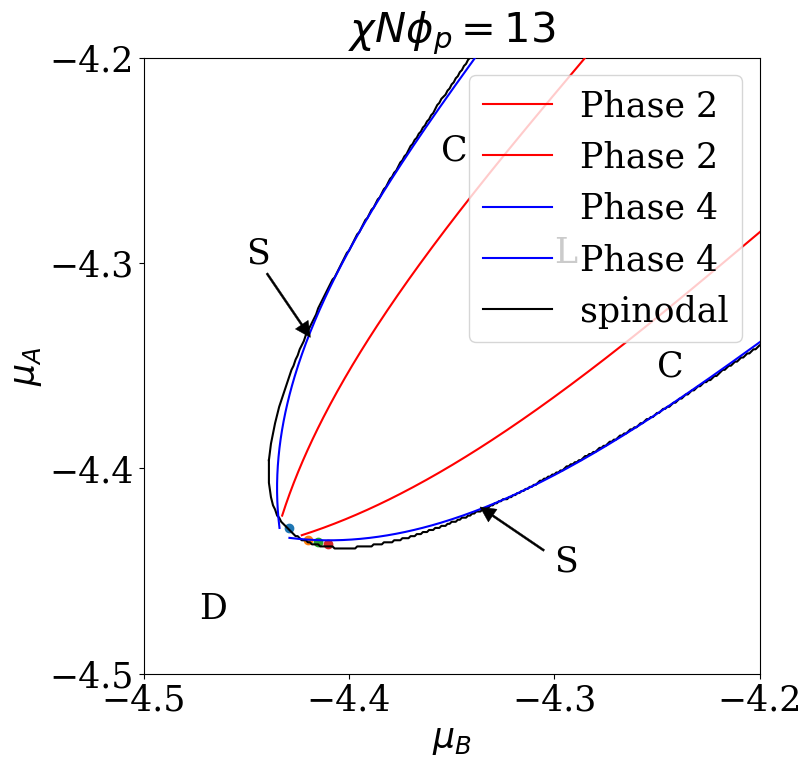

In [531]:
# TSTING

import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries


mu_max_1 = -2.6-1.5#8#0.1 #10
mu_min_1 = -3-1.5#-9
del_mu_1 = .005#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

mu1_array = mu1_arr
mu2_array = mu2_arr

font = {'family' : 'serif',
        'weight':'normal',
        'size': 25}
plt.rc('font', **font)
# plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(10, 8))



manual_points = {
    2: [(-4.429, -4.429)],  # (mu_B, mu_A)
    4: [(-4.429, -4.429), (-4.42, -4.435), (-4.415, -4.436), (-4.41, -4.437)]
    # 4: [ (-4.42, -4.435), (-4.415, -4.436), (-4.41, -4.437)]
    
}

# phase_map = phases
phase_map = phases_xn13

# Get boundaries
boundaries = find_boundaries(phase_map, mode='outer')
boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)

# Get unique nonzero phases
unique_phases = np.unique(phase_map)
unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0



# fig.patch.set_facecolor('white')   # Figure background
# ax.set_facecolor('white')          # Axes background
color_set = ["red", "blue", "red", "blue", "blue"]
for phase in unique_phases:
    if phase == 3:
        continue

    # Mask of the current phase
    mask = phase_map == phase

    # Get boundary coords that belong to this phase
    phase_boundary_pts = []
    for y, x in boundary_coords:
        if mask[y, x]:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                    if phase_map[ny, nx] != phase:
                        if y < x:  # upper diagonal condition
                            phase_boundary_pts.append((y, x))
                        break

    if len(phase_boundary_pts) == 0:
        continue

    phase_boundary_pts = np.array(phase_boundary_pts)
    rows = phase_boundary_pts[:, 0]
    cols = phase_boundary_pts[:, 1]

    # Convert to coordinate values
    mu1_vals = mu1_arr[rows]
    mu2_vals = mu2_arr[cols]

        # Add manual points if available
    if phase in manual_points:
        extra = np.array(manual_points[phase])
        mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
        mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])

    sort_idx = np.argsort(mu2_vals)
    mu2_vals = mu2_vals[sort_idx]
    mu1_vals = mu1_vals[sort_idx]
    # if phase ==2: 
    #     print(mu2_vals[7]) 
    #     mu1_vals[7]+=0.02
    #     mu1_vals[8]+=0.02


    x = mu2_vals
    y = mu1_vals
    
    from scipy.interpolate import UnivariateSpline
    # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
    spline = UnivariateSpline(x, y, s=1e-3)  # Try s=1e-4 to s=1e-2
    
    # Evaluate smoothed curve
    if phase ==2:
        x_fit = np.linspace(x.min()+.006, x.max(), 300)
    else:
        x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = spline(x_fit)
    # if phase ==4:
    #     y_fit += 0.0025
    ax.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    ax.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    
    # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)

ax.set_xlabel('$\mu_B$')
ax.set_ylabel('$\mu_A$')
ax.axis('equal')
ax.grid(True)
# ax.legend()
# ax.set_title("Fitted & Reflected Phase Boundaries")
# plt.show()
ax.grid(False)
ax.plot(spin_left_app_xn13[:,0]-1.5, spin_left_app_xn13[:,1]-1.5, color = "black", label = "spinodal")
ax.plot(spin_right_xn13[:,0]-1.5, spin_right_xn13[:,1]-1.5, color = "black")
x_ticks = ax.get_xticks()
ax.set_yticks(x_ticks)
ax.set_xlim(-3-1.5, -2.7-1.5)
ax.set_ylim(-3-1.5, -2.7-1.5)
# plt.scatter(9,8)

# ax.set_autoscale_on(False)
# ax.margins(0)  # No margins around the data
# plt.legend()


# bcc_point = [-2.84, -2.7] # [mu1, mu2]
# cyl_point = [-2.84, -2.73] # [mu1, mu2]
# lam_point = [-2.84, -2.84] # [mu1, mu2]
# dis_point = [-2.95, -2.95] # [mu1, mu2]

# plt.scatter(bcc_point[1], bcc_point[0])
# plt.scatter(cyl_point[1], cyl_point[0])
# plt.scatter(lam_point[1], lam_point[0])
# plt.scatter(dis_point[1], dis_point[0])

plt.scatter(-4.429, -4.429) # -2.77, -2.77
plt.scatter(-4.42, -4.435) # -2.77, -2.77
plt.scatter(-4.415, -4.436) # -2.77, -2.77
plt.scatter(-4.41, -4.437) # -2.77, -2.77

# plt.scatter(-4.42, -4.435) # -2.77, -2.77


# plt.scatter(28.5,18.5, color = "black") # -2.82, -2.72
# plt.scatter(30.5,16.5, color = "black") # -2.84, -2.7
plt.text(-2.835-0.02-1.5, -2.72-0.03-1.5, "C")
plt.text(-2.775-0.025-1.5, -2.775-0.025-1.5, "L")
plt.text(-2.72-0.03-1.5, -2.835-0.02-1.5, "C")

# plt.text(-2.85, -2.85, "S")
plt.text(-2.973-1.5, -2.973-1.5, "D")
# plt.arrow(-2.935, -2.875, 0.05, 0.05)

plt.text(-2.95-1.5, -2.8-1.5, "S")
plt.text(-2.8-1.5, -2.95-1.5, "S")

arrow1_origx = -2.94-1.5
arrow1_origy = -2.805-1.5

plt.arrow(arrow1_origx, arrow1_origy, 0.017, -0.025, zorder=10, linewidth = .3,\
          color = "black", head_width=0.0075, head_length=0.0075)
plt.arrow(arrow1_origy, arrow1_origx, -0.025, 0.017, zorder=10, linewidth = .3,\
          color = "black", head_width=0.0075, head_length=0.0075)
# plt.arrow(arrow1_origy, arrow1_origx,-0.025+0.01,  2.85 -2.935 +0.02, zorder=10,  linewidth = .3, color = "black")

ax.set_adjustable('box')  # Maintain aspect ratio if needed
ax.set_aspect('equal')    # Force 1:1 aspect ratio
plt.title(r"$\chi N \phi_p = 13$")
plt.legend()
plt.show()


## XN=15

### spinodal

In [2]:
# ultrazmd

n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# vryzmd
mu_max_1 = -3-1.5005#8#0.1 #10
mu_min_1 = -3.4-1.5#-9
del_mu_1 = 0.001# .001#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

# mu_max_1 = -3.099#8#0.1 #10
# mu_min_1 = -3.1#-9
# del_mu_1 = .01#.5 #0.25
# mu_max_2 = -3.699
# mu_min_2 = -3.7
# del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 13 / (phi_p * N)
# phases = np.load("OABS_phases_arr_vryzmd_chiABphipNeq13N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_vryzmd_chiABphipNeq13N=5000.npy")

In [5]:
len(mu1_arr)

400

#### calc spin

In [9]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)

KeyboardInterrupt: 

In [86]:
np.save("xn15_spin_ALT_sbindA.npy", s_bind_A_ALL)
np.save("xn15_spin_ALT_sbindB.npy", s_bind_B_ALL)

In [87]:
# %%time
# k* stability analysis NUMBER DENSITY THEORY
assert competitive == True
# chi = 0#5*N/N

min_eigval_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))

min_eigvec_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_arr[:]), len(mu2_arr[:]))) 

cond_num_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))

# # PRETTY GOOD but no spinodal, just all macro seps
# chi_AB = 200 / (rho_p*N) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
# chi_AS = 910 / N #834 / N


# # same as above :(
# chi_AB = 00 / (rho_p*N) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
# chi_AS = 910 / N #834 / N

# 
chi_AB = 15 / (phi_p*N) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
chi_AS = 00 / N #834 / N
chis = [chi_AB, chi_AS]
for i, mu1 in enumerate(mu1_arr):
    for j, mu2 in enumerate(mu2_arr):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):

            # S2_mat = (M**2 / N**2) * s2_mats[i][j][ik].copy()
            # S2_mat[3,3] /= (M**2 / N**2)
            # print("M2 FACTOR!!!")

            

            s_bnd_A = s_bind_A_ALL[i, j]
            s_bnd_B = s_bind_B_ALL[i, j]

            M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, k, chis, competitive)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [88]:
np.save("spin_kstar_xn15_ALT_eigvecrest_N=5k_XN=13.npy", k_star_arr_DENS)
np.save("spin_mineigval_xn15_ALT_eigvecrest_N=5k_XN=13.npy", min_eigval_arr_allk_DENS)

#### load spin

In [7]:
k_star_arr_DENS = np.load("spin_kstar_xn15_ALT_eigvecrest_N=5k_XN=13.npy")
min_eigval_arr_allk_DENS = np.load("spin_mineigval_xn15_ALT_eigvecrest_N=5k_XN=13.npy")

#### plot

In [10]:
# spinodal_phases_shift = np.copy(phases)
# spinodal_phases_shift[np.where(phases!=0)] = -1

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1
spinodal_phases_shift = np.copy(k_star_arr_DENS)
spinodal_phases_shift[np.where(k_star_arr_DENS<0)] = 0
spinodal_phases_shift[np.where(k_star_arr_DENS>0)] = -1

X = spinodal_phases_shift

upper = np.triu(X)
# upper[np.where(upper == 0)] = 0

lower = np.tril(X)
# lower[np.where(lower == 0)] = 0

# WORKS!
mu1_array= mu1_arr
mu2_array= mu2_arr

spin_right = np.zeros((X.shape[0],2))
spin_left = np.zeros((X.shape[0],2))

for i in range(X.shape[0]): # for each row in spinodal diagram (mu1 row)
    #find crossover arr
    mu1 = mu1_array[i]
    # print("mu1: ", mu1)
    # a = upper[i]
    a = X[i]
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    # print(signchange)

    if np.sum(signchange) == 0: # no boundary at this 
        mu2_vals = [np.nan]
        # spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, mu2_vals[0]] 
        spin_left[i] = [mu1, mu2_vals[0]]

    elif np.sum(signchange) == 1: # outer boundary cut off
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, np.nan] 
    else:
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, np.min(mu2_vals)]
        spin_right[i] = [mu1, np.max(mu2_vals)] 

# a = cyl_right_inner
spin_left = spin_left[~np.isnan(spin_left).any(axis=1)]    
# cyl_right_outer = spin_left[~np.isnan(spin_left).any(axis=1)]    
spin_right = spin_right[~np.isnan(spin_right).any(axis=1)]    
# cyl_left_outer = cyl_left_outer[~np.isnan(cyl_left_outer).any(axis=1)]  

spin_right_app = np.vstack([spin_left[0], spin_right])
spin_left_app = np.vstack([spin_right[0], spin_left])

spin_left_app_xn15 = spin_left_app
spin_right_xn15 = spin_right

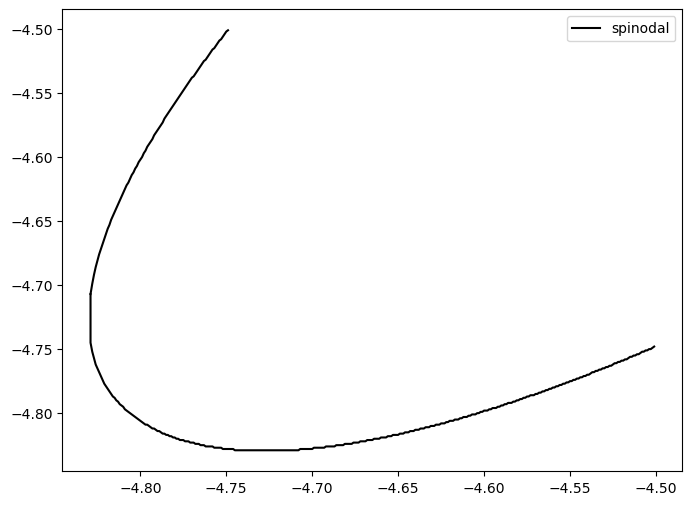

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
# import numpy as np


plt.figure(figsize=(8, 6))


plt.plot(spin_left_app_xn15[:,0], spin_left_app_xn15[:,1], color = "black", label = "spinodal")
plt.plot(spin_right_xn15[:,0], spin_right_xn15[:,1], color = "black")
# plt.scatter(9,8)

x = spin_right[:,0]
y = spin_right[:,1]


plt.legend()
plt.show()


### phases

In [14]:
# ultrazmd

n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# vryzmd
mu_max_1 = -3-1.5005#8#0.1 #10
mu_min_1 = -3.4-1.5#-9
del_mu_1 = 0.005# .001#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

# mu_max_1 = -3.099#8#0.1 #10
# mu_min_1 = -3.1#-9
# del_mu_1 = .01#.5 #0.25
# mu_max_2 = -3.699
# mu_min_2 = -3.7
# del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

N = 5000
phi_p = 0.7
chi_AB_loaded = 15 / (phi_p * N)
result_arr = np.load("OABS_phases_arr_ALT_xn15_eigvecres_chiABphipNeq15N=5000.npy")
phases = np.array([])#np.zeros((len(mu1_arr), len(mu2_arr))) - 1
# phz = np.array([])
for i, result in enumerate(result_arr):
    if len(phases)==0:
        phases = result
    else:
        phases = np.vstack((phases, result))

phases = phases.astype(int)
phases_xn15 = phases

Text(0.5, 1.0, '$OABS \\ phases, unres, $N = 5000,  $N \\phi_p \\chi_{AB} = $15.0, $N\\chi_{OS} = N\\chi_{AS} = N\\chi_{BS} =$0, $v_{int} = $ [[-4  4],[ 4 -4]]\n')

<Figure size 640x480 with 0 Axes>

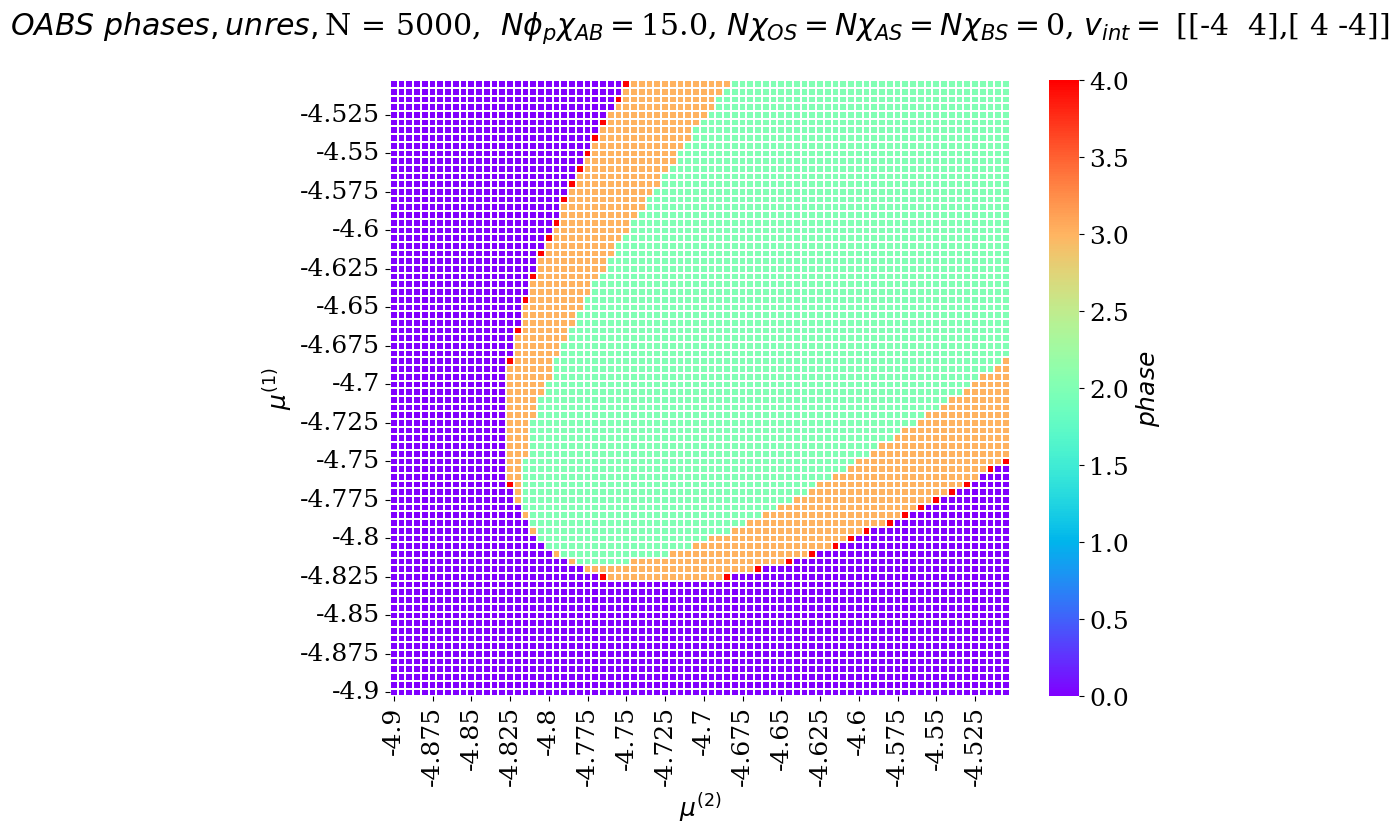

In [15]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

mu1_array = np.round(mu1_arr, 4)
mu2_array = np.round(mu2_arr, 4)
# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array, yticklabels=mu1_array,\
                 cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=4)

spacing = 5
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$OABS \ phases, unres, $" +  "N = %s, " % N + " $N \phi_p \chi_{AB} = $" + \
          str(chi_AB_loaded*N*phi_p) \
          + ", $N\chi_{OS} = N\chi_{AS} = N\chi_{BS} =$" + str(N*0)  
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")

# plt.savefig('OABS_phases.png')

### plot

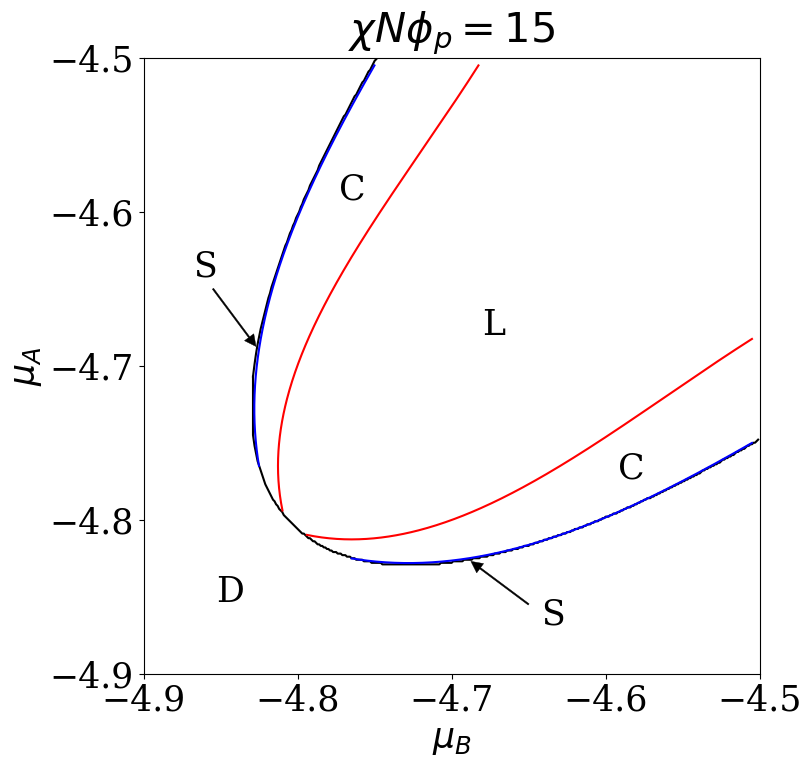

In [17]:
# TSTING

import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries


mu_max_1 = -3-1.5005#8#0.1 #10
mu_min_1 = -3.4-1.5#-9
del_mu_1 = 0.005# .001#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

mu1_array = mu1_arr
mu2_array = mu2_arr

font = {'family' : 'serif',
        'weight':'normal',
        'size': 25}
plt.rc('font', **font)
# plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(10, 8))



manual_points = {
    # 2: [(-4.429, -4.429)],  # (mu_B, mu_A)
    # 4: [(-4.429, -4.429), (-4.42, -4.435), (-4.415, -4.436), (-4.41, -4.437)]
}

# phase_map = phases
phase_map = phases_xn15

# Get boundaries
boundaries = find_boundaries(phase_map, mode='outer')
boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)

# Get unique nonzero phases
unique_phases = np.unique(phase_map)
unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0



# fig.patch.set_facecolor('white')   # Figure background
# ax.set_facecolor('white')          # Axes background
color_set = ["red", "blue", "red", "blue", "blue"]
for phase in unique_phases:
    if phase == 3:
        continue

    # Mask of the current phase
    mask = phase_map == phase

    # Get boundary coords that belong to this phase
    phase_boundary_pts = []
    for y, x in boundary_coords:
        if mask[y, x]:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                    if phase_map[ny, nx] != phase:
                        if y < x:  # upper diagonal condition
                            phase_boundary_pts.append((y, x))
                        break

    if len(phase_boundary_pts) == 0:
        continue

    phase_boundary_pts = np.array(phase_boundary_pts)
    rows = phase_boundary_pts[:, 0]
    cols = phase_boundary_pts[:, 1]

    # Convert to coordinate values
    mu1_vals = mu1_arr[rows]
    mu2_vals = mu2_arr[cols]

        # Add manual points if available
    if phase in manual_points:
        extra = np.array(manual_points[phase])
        mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
        mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])

    sort_idx = np.argsort(mu2_vals)
    mu2_vals = mu2_vals[sort_idx]
    mu1_vals = mu1_vals[sort_idx]
    # if phase ==2: 
    #     print(mu2_vals[7]) 
    #     mu1_vals[7]+=0.02
    #     mu1_vals[8]+=0.02


    x = mu2_vals
    y = mu1_vals
    # plt.scatter(x, y)
    from scipy.interpolate import UnivariateSpline
    # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
    spline = UnivariateSpline(x, y, s=1e-3)  # Try s=1e-4 to s=1e-2
    
    # Evaluate smoothed curve
    if phase ==2:
        x_fit = np.linspace(x.min()+.006, x.max(), 300)
    else:
        x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = spline(x_fit)
    # if phase ==4:
    #     y_fit += 0.0025
    ax.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    ax.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    
    # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)

ax.set_xlabel('$\mu_B$')
ax.set_ylabel('$\mu_A$')
ax.axis('equal')
ax.grid(True)
# ax.legend()
# ax.set_title("Fitted & Reflected Phase Boundaries")
# plt.show()
ax.grid(False)
ax.plot(spin_left_app_xn15[:,0], spin_left_app_xn15[:,1], color = "black", label = "spinodal")
ax.plot(spin_right_xn15[:,0], spin_right_xn15[:,1], color = "black")
x_ticks = ax.get_xticks()
ax.set_yticks(x_ticks)
ax.set_xlim(-3.4-1.5, -3-1.5)
ax.set_ylim(-3.4-1.5, -3-1.5)
# plt.scatter(9,8)

# ax.set_autoscale_on(False)
# ax.margins(0)  # No margins around the data
# plt.legend()


# bcc_point = [-2.84, -2.7] # [mu1, mu2]
# cyl_point = [-2.84, -2.73] # [mu1, mu2]
# lam_point = [-2.84, -2.84] # [mu1, mu2]
# dis_point = [-2.95, -2.95] # [mu1, mu2]

# plt.scatter(bcc_point[1], bcc_point[0])
# plt.scatter(cyl_point[1], cyl_point[0])
# plt.scatter(lam_point[1], lam_point[0])
# plt.scatter(dis_point[1], dis_point[0])

plt.scatter(-4.429, -4.429) # -2.77, -2.77
plt.scatter(-4.42, -4.435) # -2.77, -2.77
plt.scatter(-4.415, -4.436) # -2.77, -2.77
plt.scatter(-4.41, -4.437) # -2.77, -2.77

# plt.scatter(-4.42, -4.435) # -2.77, -2.77

fact = 0.38
# plt.scatter(28.5,18.5, color = "black") # -2.82, -2.72
# plt.scatter(30.5,16.5, color = "black") # -2.84, -2.7
plt.text(-2.835-0.02-1.5-fact-0.038, -2.72-0.03-1.5-fact+0.038, "C")
plt.text(-2.775-0.025-1.5-fact, -2.775-0.025-1.5-fact, "L")
plt.text(-2.72-0.03-1.5-fact+0.038, -2.835-0.02-1.5-fact-0.038, "C")

# plt.text(-2.85, -2.85, "S")
plt.text(-2.973-1.5-fact, -2.973-1.5-fact, "D")
# plt.arrow(-2.935, -2.875, 0.05, 0.05)

plt.text(-2.95-1.5-fact-0.038, -2.8-1.5-fact+0.038, "S")
plt.text(-2.8-1.5-fact+0.038, -2.95-1.5-fact-0.038, "S")

arrow1_origx = -2.94-1.5-fact-0.035
arrow1_origy = -2.805-1.5-fact+0.035

plt.arrow(arrow1_origx, arrow1_origy, 0.017+0.0065, -0.025-0.0065, zorder=10, linewidth = .3,\
          color = "black", head_width=0.0075, head_length=0.0075)
plt.arrow(arrow1_origy, arrow1_origx, -0.025-0.0065, 0.017+0.0065, zorder=10, linewidth = .3,\
          color = "black", head_width=0.0075, head_length=0.0075)
# plt.arrow(arrow1_origy, arrow1_origx,-0.025+0.01,  2.85 -2.935 +0.02, zorder=10,  linewidth = .3, color = "black")

ax.set_adjustable('box')  # Maintain aspect ratio if needed
ax.set_aspect('equal')    # Force 1:1 aspect ratio
plt.title(r"$\chi N \phi_p = 15$")
# plt.legend()
plt.show()


## XN = 50

In [19]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # XN50zoom
# mu_max_1 = -2#8#0.1 #10
# mu_min_1 = -4#-9
# del_mu_1 = .1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# XN50zoom
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_eigvecrest_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_eigvecrest_chiABphipNeq49N=5000.npy")

N = 5000
phi_p = 0.7
chi_AB_loaded = 50 / (phi_p * N)
result_arr = np.load("OABS_phases_arr_ALT_XN50_eigvect_fine_chiABphipNeq49N=5000.npy")
phases = np.array([])#np.zeros((len(mu1_arr), len(mu2_arr))) - 1
# phz = np.array([])
for i, result in enumerate(result_arr):
    if len(phases)==0:
        phases = result
    else:
        phases = np.vstack((phases, result))

phases = phases.astype(int)
# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")


### spinodal

In [21]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # XN50zoom
# mu_max_1 = -2#8#0.1 #10
# mu_min_1 = -4#-9
# del_mu_1 = .1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# XN50zoom veryfine
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = 0.0025 # 0.0025
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

In [23]:
k_star_arr_DENS = np.load("spin_kstar_xn50_ALT_eigvecrest_N=5k_XN=13.npy")
min_eigval_arr_allk_DENS = np.load("spin_mineigval_xn50_ALT_eigvecrest_N=5k_XN=13.npy")

In [24]:
# spinodal_phases_shift = np.copy(phases)
# spinodal_phases_shift[np.where(phases!=0)] = -1

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1
spinodal_phases_shift = np.copy(k_star_arr_DENS)
spinodal_phases_shift[np.where(k_star_arr_DENS<0)] = 0
spinodal_phases_shift[np.where(k_star_arr_DENS>0)] = -1

X = spinodal_phases_shift

upper = np.triu(X)
# upper[np.where(upper == 0)] = 0

lower = np.tril(X)
# lower[np.where(lower == 0)] = 0

# WORKS!
mu1_array= mu1_arr
mu2_array= mu2_arr

spin_right = np.zeros((X.shape[0],2))
spin_left = np.zeros((X.shape[0],2))

for i in range(X.shape[0]): # for each row in spinodal diagram (mu1 row)
    #find crossover arr
    mu1 = mu1_array[i]
    # print("mu1: ", mu1)
    # a = upper[i]
    a = X[i]
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    # print(signchange)

    if np.sum(signchange) == 0: # no boundary at this 
        mu2_vals = [np.nan]
        # spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, mu2_vals[0]] 
        spin_left[i] = [mu1, mu2_vals[0]]

    elif np.sum(signchange) == 1: # outer boundary cut off
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, np.nan] 
    else:
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, np.min(mu2_vals)]
        spin_right[i] = [mu1, np.max(mu2_vals)] 

# a = cyl_right_inner
spin_left = spin_left[~np.isnan(spin_left).any(axis=1)]    
# cyl_right_outer = spin_left[~np.isnan(spin_left).any(axis=1)]    
spin_right = spin_right[~np.isnan(spin_right).any(axis=1)]    
# cyl_left_outer = cyl_left_outer[~np.isnan(cyl_left_outer).any(axis=1)]  

spin_right_app = np.vstack([spin_left[0], spin_right])
spin_left_app = np.vstack([spin_right[0], spin_left])

spin_left_app_xn50 = spin_left_app
spin_right_xn50 = spin_right

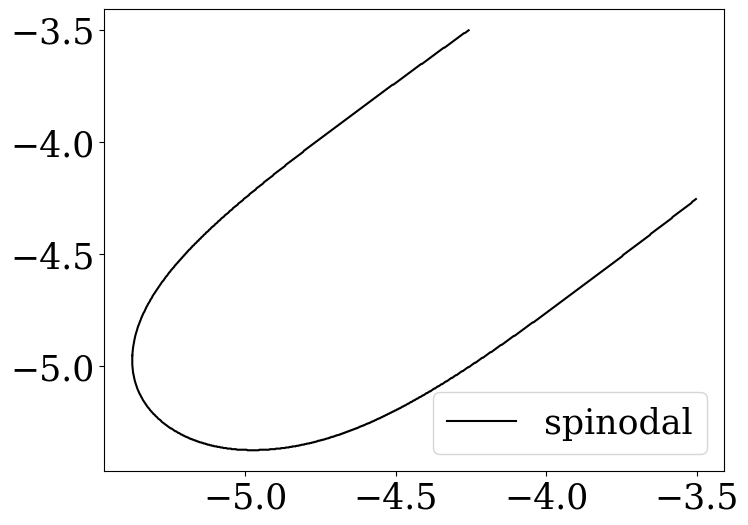

In [25]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
# import numpy as np


plt.figure(figsize=(8, 6))


plt.plot(spin_left_app_xn50[:,0], spin_left_app_xn50[:,1], color = "black", label = "spinodal")
plt.plot(spin_right_xn50[:,0], spin_right_xn50[:,1], color = "black")
# plt.scatter(9,8)
plt.legend()
plt.show()


### phases

In [27]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# # XN50zoom
# mu_max_1 = -2#8#0.1 #10
# mu_min_1 = -4#-9
# del_mu_1 = .1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# XN50zoom
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
v_s = 1
v_m = 1
N = 5000
b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_eigvecrest_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_eigvecrest_chiABphipNeq49N=5000.npy")

N = 5000
phi_p = 0.7
chi_AB_loaded = 50 / (phi_p * N)
result_arr = np.load("OABS_phases_arr_ALT_XN50_eigvect_fine_chiABphipNeq49N=5000.npy")
phases = np.array([])#np.zeros((len(mu1_arr), len(mu2_arr))) - 1
# phz = np.array([])
for i, result in enumerate(result_arr):
    if len(phases)==0:
        phases = result
    else:
        phases = np.vstack((phases, result))

phases = phases.astype(int)
phases_xn50 = phases.astype(int)

# N = 5000
# phi_p = 0.7
# chi_AB_loaded = 50 / (phi_p * N)
# phases = np.load("OABS_phases_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")
# minF_arr = np.load("OABS_min_F_arr_physbound_zoomed_chiABphipNeq49N=5000.npy")


Text(0.5, 1.0, '$OABS \\ phases, unres, $N = 5000,  $N \\phi_p \\chi_{AB} = $50.0, $N\\chi_{OS} = N\\chi_{AS} = N\\chi_{BS} =$0, $v_{int} = $ [[-4  4],[ 4 -4]]\n')

<Figure size 640x480 with 0 Axes>

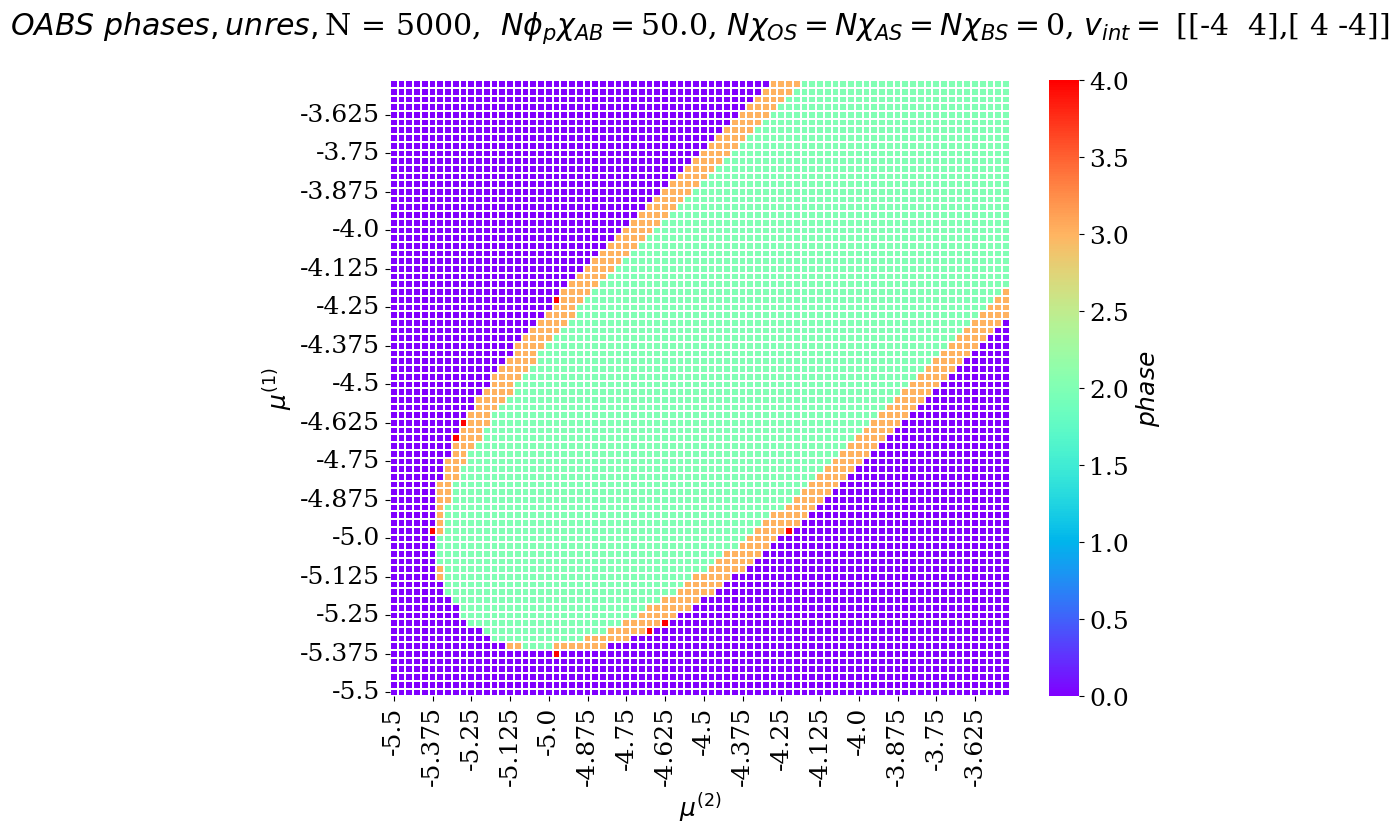

In [29]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

mu1_array = np.round(mu1_arr, 4)
mu2_array = np.round(mu2_arr, 4)
# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array, yticklabels=mu1_array,\
                 cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=4)

spacing = 5
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$OABS \ phases, unres, $" +  "N = %s, " % N + " $N \phi_p \chi_{AB} = $" + \
          str(chi_AB_loaded*N*phi_p) \
          + ", $N\chi_{OS} = N\chi_{AS} = N\chi_{BS} =$" + str(N*0)  
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")

# plt.savefig('OABS_phases.png')

-5.074999999999994


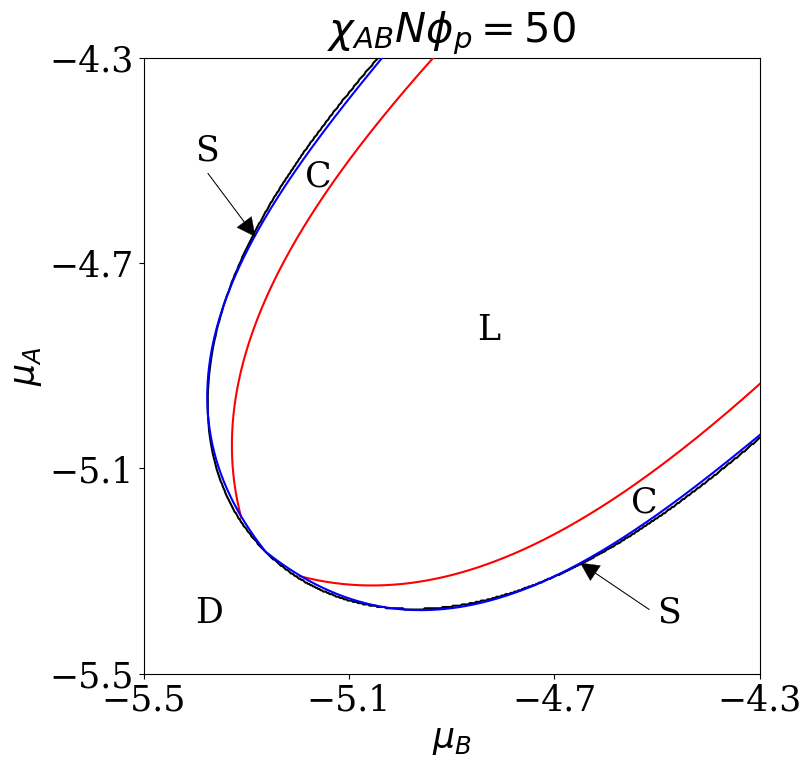

In [30]:


# IMPROVED


import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
# ax.scatter(-5.261, -5.261)
# ax.scatter(-5.231, -5.291)
# ax.scatter(-5.201, -5.309)
# ax.scatter(-5.171, -5.329)

font = {'family' : 'serif',
        'weight':'normal',
        'size': 25}
plt.rc('font', **font)
# plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(10, 8))


mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1


mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

mu1_array = mu1_arr
mu2_array = mu2_arr

manual_points = {
    2: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)],  # (mu_B, mu_A)
    4: [(-5.261, -5.261), (-5.231, -5.291),(-5.201, -5.309), (-5.171, -5.329)]
}

# phase_map = phases
phase_map = phases_xn50

# Get boundaries
boundaries = find_boundaries(phase_map, mode='outer')
boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)

# Get unique nonzero phases
unique_phases = np.unique(phase_map)
unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0



# fig.patch.set_facecolor('white')   # Figure background
# ax.set_facecolor('white')          # Axes background
color_set = ["red", "blue", "red", "blue", "blue"]
for phase in unique_phases:
    if phase == 3:
        continue

    # Mask of the current phase
    mask = phase_map == phase

    # Get boundary coords that belong to this phase
    phase_boundary_pts = []
    for y, x in boundary_coords:
        if mask[y, x]:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                    if phase_map[ny, nx] != phase:
                        if y < x:  # upper diagonal condition
                            phase_boundary_pts.append((y, x))
                        break

    if len(phase_boundary_pts) == 0:
        continue

    phase_boundary_pts = np.array(phase_boundary_pts)
    rows = phase_boundary_pts[:, 0]
    cols = phase_boundary_pts[:, 1]

    # Convert to coordinate values
    mu1_vals = mu1_arr[rows]
    mu2_vals = mu2_arr[cols]

        # Add manual points if available
    if phase in manual_points:
        extra = np.array(manual_points[phase])
        mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
        mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])

    sort_idx = np.argsort(mu2_vals)
    mu2_vals = mu2_vals[sort_idx]
    mu1_vals = mu1_vals[sort_idx]
    if phase ==2: 
        print(mu2_vals[7]) 
        mu1_vals[7]+=0.02
        mu1_vals[8]+=0.02


    x = mu2_vals
    y = mu1_vals
    
    from scipy.interpolate import UnivariateSpline
    # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
    spline = UnivariateSpline(x, y, s=1e-2)  # Try s=1e-4 to s=1e-2
    
    # Evaluate smoothed curve
    if phase ==2:
        x_fit = np.linspace(x.min()+.065, x.max(), 300)
    else:
        x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = spline(x_fit)
    if phase ==4:
        y_fit += 0.0025
    ax.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    ax.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    
    # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
    # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)


ax.set_xlabel('$\mu_B$')
ax.set_ylabel('$\mu_A$')
ax.axis('equal')
# ax.grid(True)
# ax.legend()
# ax.set_title("Fitted & Reflected Phase Boundaries")
# plt.show()
ax.grid(False)
ax.plot(spin_left_app[:,0], spin_left_app[:,1], color = "black", label = "spinodal")
ax.plot(spin_right[:,0], spin_right[:,1], color = "black")
ax.set_xlim(-4-1.5, -2.8-1.5)
ax.set_ylim(-4-1.5, -2.8-1.5)

ticks = np.linspace(-4-1.5, -2.8-1.5, 4)  # 6 ticks, or adjust as you want

# Set identical ticks
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# ax.legend()

plt.text(-4.55, -5.185, "C")
plt.text(-4.85, -4.85, "L")
plt.text(-5.185, -4.55, "C")
plt.text(-5.4, -5.4, "D")
# plt.arrow(-2.935, -2.875, 0.05, 0.05)
plt.text(-3.9-1.5, -3-1.5, "S")
plt.text(-3-1.5, -3.9-1.5, "S")
arrow1_origx = -3.875-1.5
arrow1_origy = -3.025-1.5
plt.arrow(arrow1_origx, arrow1_origy, .071, -0.125+0.03, zorder=10, linewidth = .3,\
          color = "black", head_width=0.035, head_length=0.035)
plt.arrow(arrow1_origy+0.01, arrow1_origx, -0.125+0.02,.071, zorder=10, linewidth = .3,\
          color = "black", head_width=0.035, head_length=0.035)
# plt.arrow(arrow1_origy, arrow1_origx,-0.025+0.01,  2.85 -2.935 +0.02, zorder=10,  linewidth = .3, color = "black")
# ax.scatter(-5.261, -5.261)


ax.set_adjustable('box')  # Maintain aspect ratio if needed
ax.set_aspect('equal')    # Force 1:1 aspect ratio

plt.title(r"$\chi_{AB} N \phi_p = 50$")
plt.show()


## comparison

In [32]:
def plot_phase_diagram_xn13(ax, mu1_arr, mu2_arr, phases_xn13, spin_left_app_xn13, spin_right_xn13):
    from scipy.interpolate import UnivariateSpline
    from skimage.segmentation import find_boundaries
    import numpy as np

    manual_points = {
        2: [(-4.429, -4.429)],  # (mu_B, mu_A)
        # 4: [(-4.429, -4.429)]
        4: [(-4.415, -4.436), (-4.41, -4.437)]
    }

    phase_map = phases_xn13
    boundaries = find_boundaries(phase_map, mode='outer')
    boundary_coords = np.array(np.where(boundaries)).T

    unique_phases = np.unique(phase_map)
    unique_phases = unique_phases[unique_phases != 0]
    color_set = ["red", "blue", "red", "blue", "blue"]

    for phase in unique_phases:
        if phase == 3:
            continue
        mask = phase_map == phase
        phase_boundary_pts = []
        for y, x in boundary_coords:
            if mask[y, x]:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                        if phase_map[ny, nx] != phase:
                            if y < x:
                                phase_boundary_pts.append((y, x))
                            break
        if not phase_boundary_pts:
            continue
        phase_boundary_pts = np.array(phase_boundary_pts)
        rows, cols = phase_boundary_pts[:, 0], phase_boundary_pts[:, 1]
        mu1_vals = mu1_arr[rows]
        mu2_vals = mu2_arr[cols]
        if phase in manual_points:
            extra = np.array(manual_points[phase])
            mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
            mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])
        sort_idx = np.argsort(mu2_vals)
        mu2_vals, mu1_vals = mu2_vals[sort_idx], mu1_vals[sort_idx]
        x, y = mu2_vals, mu1_vals
        spline = UnivariateSpline(x, y, s=1e-2)
        x_fit = np.linspace(x.min() + (0.005 if phase == 2 else 0.002), x.max(), 300)
        y_fit = spline(x_fit)
        ax.plot(x_fit, y_fit, color=color_set[phase], zorder=5)
        ax.plot(y_fit, x_fit, color=color_set[phase], zorder=5)

    ax.set_xlabel('$\mu_B$')
    ax.set_ylabel('$\mu_A$')
    ax.axis('equal')
    ax.grid(False)
    ax.plot(spin_left_app_xn13[:,0]-1.5, spin_left_app_xn13[:,1]-1.5, color="black")
    ax.plot(spin_right_xn13[:,0]-1.5, spin_right_xn13[:,1]-1.5, color="black")
    x_ticks = ax.get_xticks()
    ax.set_yticks(x_ticks)
    ax.set_xlim(-4.5, -4.2)
    ax.set_ylim(-4.5, -4.2)

    ax.set_adjustable('box')  # Maintain aspect ratio if needed
    ax.set_aspect('equal')    # Force 1:1 aspect ratio
    ticks = np.linspace(-4.5, -4.2, 4)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.text(-4.335-.025, -4.22-0.04, "C")
    ax.text(-4.305, -4.305, "L")
    ax.text(-4.22-0.04, -4.335-.025, "C")
    ax.text(-4.473, -4.473, "D")
    ax.text(-4.45, -4.3, "S")
    ax.text(-4.3, -4.45, "S")
    ax.arrow(-4.44, -4.305, 0.017, -0.025, zorder=10, linewidth=0.3, color="black", head_width=0.0075, head_length=0.0075)
    ax.arrow(-4.305, -4.44, -0.025, 0.017, zorder=10, linewidth=0.3, color="black", head_width=0.0075, head_length=0.0075)
    ax.set_title(r"$\chi_{AB} N \phi_p = 13$")


In [56]:
def plot_phase_diagram_xn15(ax, mu1_arr, mu2_arr, phases_xn15, spin_left_app_xn15, spin_right_xn15):
    # TSTING
    
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.segmentation import find_boundaries
    
    
    mu_max_1 = -3-1.5005#8#0.1 #10
    mu_min_1 = -3.4-1.5#-9
    del_mu_1 = 0.005# .001#.5 #0.25
    mu_max_2 = mu_max_1
    mu_min_2 = mu_min_1
    del_mu_2 = del_mu_1
    
    mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
    mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
    
    mu1_array = mu1_arr
    mu2_array = mu2_arr
    
    # font = {'family' : 'serif',
    #         'weight':'normal',
    #         'size': 25}
    # plt.rc('font', **font)
    # # plt.figure(figsize=(8, 6))
    # fig, ax = plt.subplots(figsize=(10, 8))
    
    
    
    manual_points = {
        # 2: [(-4.429, -4.429)],  # (mu_B, mu_A)
        # 4: [(-4.429, -4.429), (-4.42, -4.435), (-4.415, -4.436), (-4.41, -4.437)]
    }
    
    # phase_map = phases
    phase_map = phases_xn15
    
    # Get boundaries
    boundaries = find_boundaries(phase_map, mode='outer')
    boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)
    
    # Get unique nonzero phases
    unique_phases = np.unique(phase_map)
    unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0
    
    
    
    # fig.patch.set_facecolor('white')   # Figure background
    # ax.set_facecolor('white')          # Axes background
    color_set = ["red", "blue", "red", "blue", "blue"]
    for phase in unique_phases:
        if phase == 3:
            continue
    
        # Mask of the current phase
        mask = phase_map == phase
    
        # Get boundary coords that belong to this phase
        phase_boundary_pts = []
        for y, x in boundary_coords:
            if mask[y, x]:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                        if phase_map[ny, nx] != phase:
                            if y < x:  # upper diagonal condition
                                phase_boundary_pts.append((y, x))
                            break
    
        if len(phase_boundary_pts) == 0:
            continue
    
        phase_boundary_pts = np.array(phase_boundary_pts)
        rows = phase_boundary_pts[:, 0]
        cols = phase_boundary_pts[:, 1]
    
        # Convert to coordinate values
        mu1_vals = mu1_arr[rows]
        mu2_vals = mu2_arr[cols]
    
            # Add manual points if available
        if phase in manual_points:
            extra = np.array(manual_points[phase])
            mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
            mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])
    
        sort_idx = np.argsort(mu2_vals)
        mu2_vals = mu2_vals[sort_idx]
        mu1_vals = mu1_vals[sort_idx]
        # if phase ==2: 
        #     print(mu2_vals[7]) 
        #     mu1_vals[7]+=0.02
        #     mu1_vals[8]+=0.02
    
    
        x = mu2_vals
        y = mu1_vals
        # plt.scatter(x, y)
        from scipy.interpolate import UnivariateSpline
        # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
        spline = UnivariateSpline(x, y, s=1e-3)  # Try s=1e-4 to s=1e-2
        
        # Evaluate smoothed curve
        if phase ==2:
            x_fit = np.linspace(x.min()+.006, x.max()+0.005, 300)
        else:
            x_fit = np.linspace(x.min(), x.max()+0.005, 300)
        y_fit = spline(x_fit)
        # if phase ==4:
        #     y_fit += 0.0025
        ax.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
        ax.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
        
        # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
        # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)
    
    ax.set_xlabel('$\mu_B$')
    ax.set_ylabel('$\mu_A$')
    ax.axis('equal')
    ax.grid(True)
    # ax.legend()
    # ax.set_title("Fitted & Reflected Phase Boundaries")
    # plt.show()
    ax.grid(False)
    ax.plot(spin_left_app_xn15[:,0], spin_left_app_xn15[:,1], color = "black", label = "spinodal")
    ax.plot(spin_right_xn15[:,0], spin_right_xn15[:,1], color = "black")
    ticks = np.linspace(-4.9, -4.5, 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim(-3.4-1.5, -3-1.5)
    ax.set_ylim(-3.4-1.5, -3-1.5)

    # ax.set_xlim(-5.5, -3-1.5)
    # ax.set_ylim(-5.5, -3-1.5)
    
    # plt.scatter(-4.429, -4.429) # -2.77, -2.77
    # plt.scatter(-4.42, -4.435) # -2.77, -2.77
    # plt.scatter(-4.415, -4.436) # -2.77, -2.77
    # plt.scatter(-4.41, -4.437) # -2.77, -2.77
    
    # plt.scatter(-4.42, -4.435) # -2.77, -2.77
    
    fact = 0.38
    # plt.scatter(28.5,18.5, color = "black") # -2.82, -2.72
    # plt.scatter(30.5,16.5, color = "black") # -2.84, -2.7
    ax.text(-2.835-0.02-1.5-fact-0.038, -2.72-0.03-1.5-fact+0.038, "C")
    ax.text(-2.775-0.025-1.5-fact, -2.775-0.025-1.5-fact, "L")
    ax.text(-2.72-0.03-1.5-fact+0.038, -2.835-0.02-1.5-fact-0.038, "C")
    
    # plt.text(-2.85, -2.85, "S")
    ax.text(-2.973-1.5-fact, -2.973-1.5-fact, "D")
    # plt.arrow(-2.935, -2.875, 0.05, 0.05)
    
    ax.text(-2.95-1.5-fact-0.038, -2.8-1.5-fact+0.038, "S")
    ax.text(-2.8-1.5-fact+0.038, -2.95-1.5-fact-0.038, "S")
    
    arrow1_origx = -2.94-1.5-fact-0.035
    arrow1_origy = -2.805-1.5-fact+0.035
    
    ax.arrow(arrow1_origx, arrow1_origy, 0.017+0.0065, -0.025-0.0065, zorder=10, linewidth = .3,\
              color = "black", head_width=0.0075, head_length=0.0075)
    ax.arrow(arrow1_origy, arrow1_origx, -0.025-0.0065, 0.017+0.0065, zorder=10, linewidth = .3,\
              color = "black", head_width=0.0075, head_length=0.0075)
    # plt.arrow(arrow1_origy, arrow1_origx,-0.025+0.01,  2.85 -2.935 +0.02, zorder=10,  linewidth = .3, color = "black")
    
    ax.set_adjustable('box')  # Maintain aspect ratio if needed
    ax.set_aspect('equal')    # Force 1:1 aspect ratio
    ax.set_title(r"$\chi_{AB} N \phi_p = 15$")
    # plt.legend()
    # plt.show()


In [58]:
def plot_phase_diagram_xn50(ax, mu1_arr, mu2_arr, phases_xn50, spin_left_app, spin_right):
    from scipy.interpolate import UnivariateSpline
    from skimage.segmentation import find_boundaries
    import numpy as np

    manual_points = {
        2: [(-5.261, -5.261), (-5.231, -5.291), (-5.201, -5.309), (-5.171, -5.329)],
        4: [(-5.261, -5.261), (-5.231, -5.291), (-5.201, -5.309), (-5.171, -5.329)]
    }

    phase_map = phases_xn50
    boundaries = find_boundaries(phase_map, mode='outer')
    boundary_coords = np.array(np.where(boundaries)).T
    unique_phases = np.unique(phase_map)
    unique_phases = unique_phases[unique_phases != 0]
    color_set = ["red", "blue", "red", "blue", "blue"]

    for phase in unique_phases:
        if phase == 3:
            continue
        mask = phase_map == phase
        phase_boundary_pts = []
        for y, x in boundary_coords:
            if mask[y, x]:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                        if phase_map[ny, nx] != phase:
                            if y < x:
                                phase_boundary_pts.append((y, x))
                            break
        if not phase_boundary_pts:
            continue
        phase_boundary_pts = np.array(phase_boundary_pts)
        rows, cols = phase_boundary_pts[:, 0], phase_boundary_pts[:, 1]
        mu1_vals = mu1_arr[rows]
        mu2_vals = mu2_arr[cols]
        if phase in manual_points:
            extra = np.array(manual_points[phase])
            mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
            mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])
        sort_idx = np.argsort(mu2_vals)
        mu2_vals, mu1_vals = mu2_vals[sort_idx], mu1_vals[sort_idx]
        if phase == 2:
            mu1_vals[7] += 0.02
            mu1_vals[8] += 0.02
        x, y = mu2_vals, mu1_vals
        spline = UnivariateSpline(x, y, s=1e-2)
        x_fit = np.linspace(x.min() + (0.065 if phase == 2 else 0), x.max(), 300)
        y_fit = spline(x_fit)
        if phase == 4:
            y_fit += 0.0025
        ax.plot(x_fit, y_fit, color=color_set[phase], zorder=5)
        ax.plot(y_fit, x_fit, color=color_set[phase], zorder=5)
    ax.axis('equal')

    ax.set_xlabel('$\mu_B$')
    ax.set_ylabel('$\mu_A$')
    ax.grid(False)
    ax.plot(spin_left_app[:,0], spin_left_app[:,1], color="black")
    ax.plot(spin_right[:,0], spin_right[:,1], color="black")
    ax.set_xlim(-5.5, -4.3)
    ax.set_ylim(-5.5, -4.3)

    # ax.set_xlim(-5.5, -3-1.5)
    # ax.set_ylim(-5.5, -3-1.5)
    
    ax.set_adjustable('box')  # Maintain aspect ratio if needed
    ax.set_aspect('equal')    # Force 1:1 aspect ratio
    ticks = np.linspace(-5.5, -4.3, 4)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.text(-4.55, -5.185, "C")
    ax.text(-4.85, -4.85, "L")
    ax.text(-5.185, -4.55, "C")
    ax.text(-5.4, -5.4, "D")
    ax.text(-5.4, -4.5, "S")
    ax.text(-4.5, -5.4, "S")
    ax.arrow(-5.375, -4.525, .071, -0.095, zorder=10, linewidth=0.3, color="black", head_width=0.035, head_length=0.035)
    ax.arrow(-4.515, -5.365, -0.105 + 0.014, .071, zorder=10, linewidth=0.3, color="black", head_width=0.035, head_length=0.035)
    ax.set_title(r"$\chi_{AB} N \phi_p = 50$")


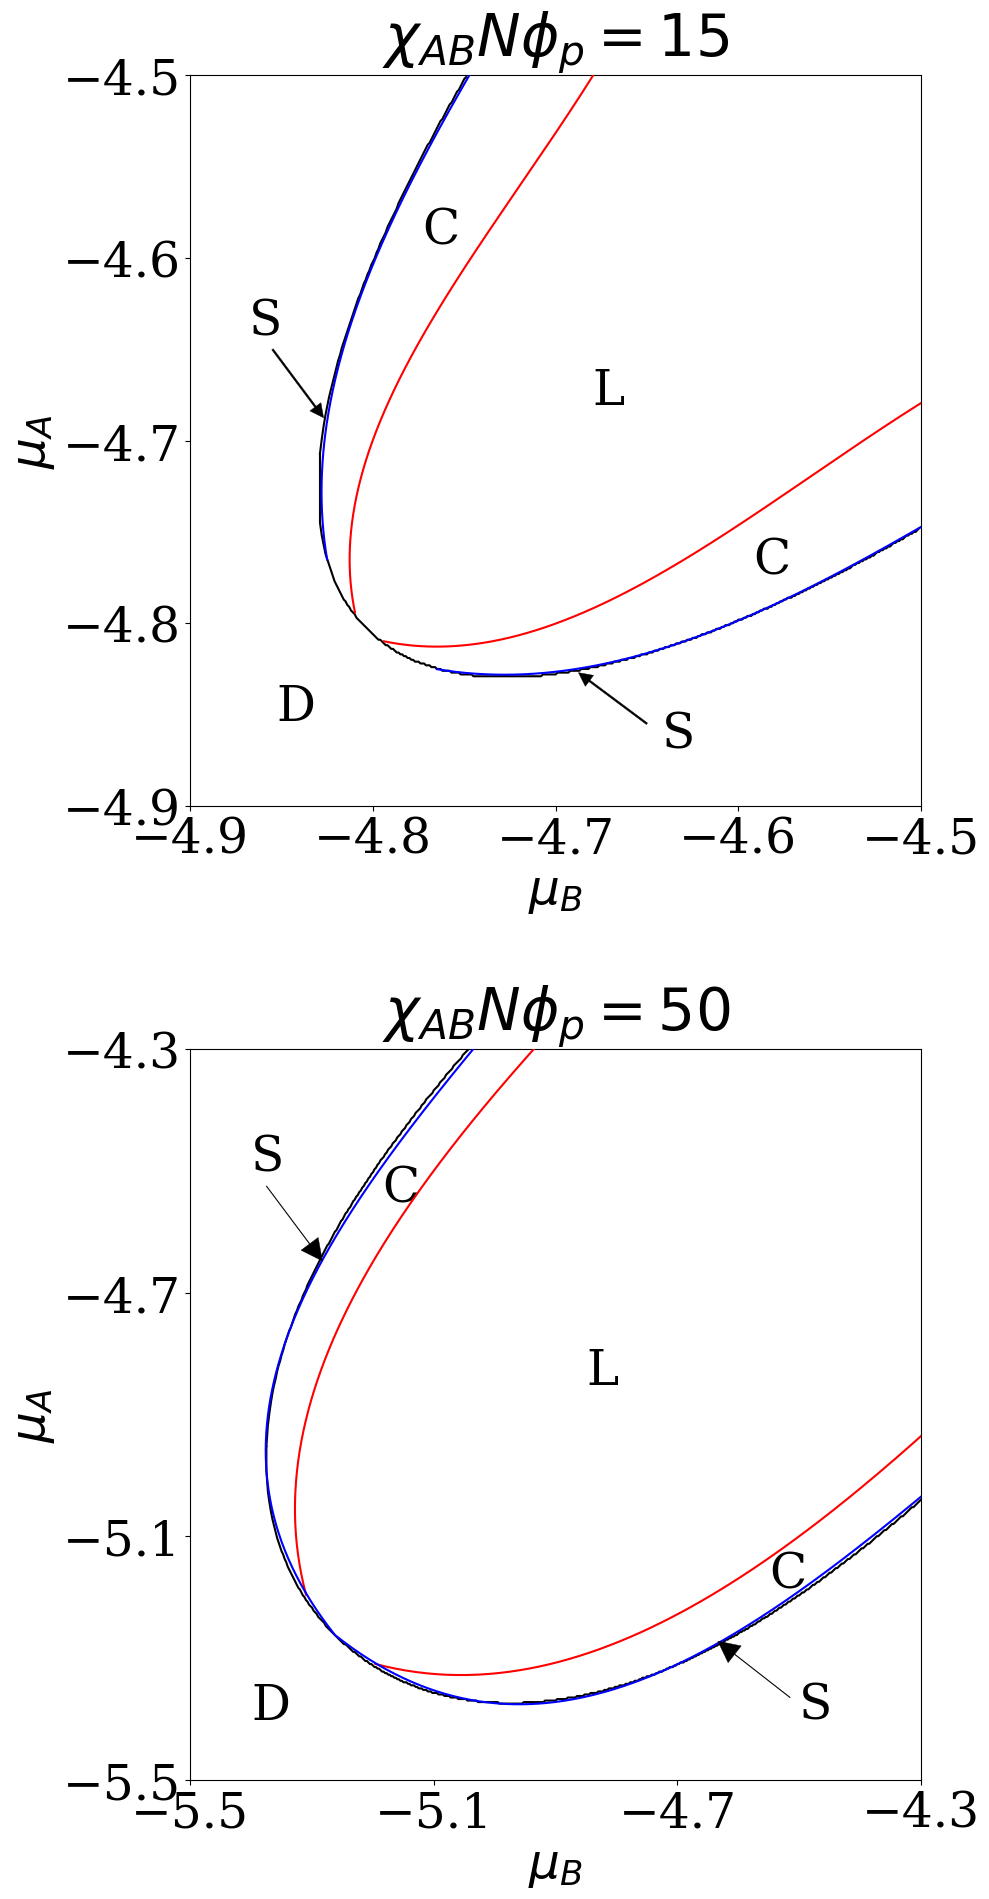

In [60]:
font_size = 35
# Set font globally
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': font_size
})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))


mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1
mu1_arr_xn50 = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr_xn50 = np.arange(mu_min_2, mu_max_2, del_mu_2)

mu_max_1 = -3-1.5005#8#0.1 #10
mu_min_1 = -3.4-1.5#-9
del_mu_1 = 0.005# .001#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1
mu1_arr_xn15 = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr_xn15 = np.arange(mu_min_2, mu_max_2, del_mu_2)


mu_max_1 = -2.6-1.5#8#0.1 #10
mu_min_1 = -3-1.5#-9
del_mu_1 = .005#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1
mu1_arr_xn13 = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr_xn13 = np.arange(mu_min_2, mu_max_2, del_mu_2)


# plot_phase_diagram_xn13(ax1, mu1_arr_xn13, mu2_arr_xn13, phases_xn13, spin_left_app_xn13, spin_right_xn13)
plot_phase_diagram_xn15(ax1, mu1_arr_xn15, mu2_arr_xn15, phases_xn15, spin_left_app_xn15, spin_right_xn15)
plot_phase_diagram_xn50(ax2, mu1_arr_xn50, mu2_arr_xn50, phases_xn50, spin_left_app, spin_right)

plt.tight_layout()

plt.savefig("phase_diag_comp_fig5_ALT.eps", format = "eps")
plt.savefig("phase_diag_comp_fig5_ALT.png")
plt.savefig("phase_diag_comp_fig5_ALT.pdf", format = "pdf")


plt.show()


In [366]:
def plot_phase_diagram_xn15(ax, mu1_arr, mu2_arr, phases_xn15, spin_left_app_xn15, spin_right_xn15):
    # TSTING
    
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.segmentation import find_boundaries
    
    
    mu_max_1 = -3-1.5005#8#0.1 #10
    mu_min_1 = -3.4-1.5#-9
    del_mu_1 = 0.005# .001#.5 #0.25
    mu_max_2 = mu_max_1
    mu_min_2 = mu_min_1
    del_mu_2 = del_mu_1
    
    mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
    mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)
    
    mu1_array = mu1_arr
    mu2_array = mu2_arr
    
    # font = {'family' : 'serif',
    #         'weight':'normal',
    #         'size': 25}
    # plt.rc('font', **font)
    # # plt.figure(figsize=(8, 6))
    # fig, ax = plt.subplots(figsize=(10, 8))
    
    
    
    manual_points = {
        # 2: [(-4.429, -4.429)],  # (mu_B, mu_A)
        # 4: [(-4.429, -4.429), (-4.42, -4.435), (-4.415, -4.436), (-4.41, -4.437)]
    }
    
    # phase_map = phases
    phase_map = phases_xn15
    
    # Get boundaries
    boundaries = find_boundaries(phase_map, mode='outer')
    boundary_coords = np.array(np.where(boundaries)).T  # (row=y, col=x)
    
    # Get unique nonzero phases
    unique_phases = np.unique(phase_map)
    unique_phases = unique_phases[unique_phases != 0]  # skip background phase if 0
    
    
    
    # fig.patch.set_facecolor('white')   # Figure background
    # ax.set_facecolor('white')          # Axes background
    color_set = ["red", "blue", "red", "blue", "blue"]
    for phase in unique_phases:
        if phase == 3:
            continue
    
        # Mask of the current phase
        mask = phase_map == phase
    
        # Get boundary coords that belong to this phase
        phase_boundary_pts = []
        for y, x in boundary_coords:
            if mask[y, x]:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                        if phase_map[ny, nx] != phase:
                            if y < x:  # upper diagonal condition
                                phase_boundary_pts.append((y, x))
                            break
    
        if len(phase_boundary_pts) == 0:
            continue
    
        phase_boundary_pts = np.array(phase_boundary_pts)
        rows = phase_boundary_pts[:, 0]
        cols = phase_boundary_pts[:, 1]
    
        # Convert to coordinate values
        mu1_vals = mu1_arr[rows]
        mu2_vals = mu2_arr[cols]
    
            # Add manual points if available
        if phase in manual_points:
            extra = np.array(manual_points[phase])
            mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
            mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])
    
        sort_idx = np.argsort(mu2_vals)
        mu2_vals = mu2_vals[sort_idx]
        mu1_vals = mu1_vals[sort_idx]
        # if phase ==2: 
        #     print(mu2_vals[7]) 
        #     mu1_vals[7]+=0.02
        #     mu1_vals[8]+=0.02
    
    
        x = mu2_vals
        y = mu1_vals
        # plt.scatter(x, y)
        from scipy.interpolate import UnivariateSpline
        # Spline smoothing: adjust `s` to control smoothness (higher = smoother)
        spline = UnivariateSpline(x, y, s=1e-3)  # Try s=1e-4 to s=1e-2
        
        # Evaluate smoothed curve
        if phase ==2:
            x_fit = np.linspace(x.min()+.006, x.max()+0.005, 300)
        else:
            x_fit = np.linspace(x.min(), x.max()+0.005, 300)
        y_fit = spline(x_fit)
        # if phase ==4:
        #     y_fit += 0.0025
        ax.plot(x_fit, y_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
        ax.plot(y_fit, x_fit, label=f'Phase {phase}', color=color_set[phase], zorder=5)
        
        # ax.plot(mu2_vals, mu1_vals, label=f'Phase {phase}', color=color_set[phase], zorder=5)
        # ax.plot(mu1_vals, mu2_vals, label = "reflected", linestyle = "--", color=color_set[phase], zorder=5)
    
    ax.set_xlabel('$\mu_B$')
    ax.set_ylabel('$\mu_A$')
    ax.axis('equal')
    ax.grid(True)
    # ax.legend()
    # ax.set_title("Fitted & Reflected Phase Boundaries")
    # plt.show()
    ax.grid(False)
    ax.plot(spin_left_app_xn15[:,0], spin_left_app_xn15[:,1], color = "black", label = "spinodal")
    ax.plot(spin_right_xn15[:,0], spin_right_xn15[:,1], color = "black")
    ticks = np.linspace(-5.5, -4.5, 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.tick_params(axis='both', which='major', pad=10)

    # ax.set_xlim(-3.4-1.5, -3-1.5)
    # ax.set_ylim(-3.4-1.5, -3-1.5)

    ax.set_xlim(-5.5, -3-1.5)
    ax.set_ylim(-5.5, -3-1.5)
    
    # plt.scatter(-4.429, -4.429) # -2.77, -2.77
    # plt.scatter(-4.42, -4.435) # -2.77, -2.77
    # plt.scatter(-4.415, -4.436) # -2.77, -2.77
    # plt.scatter(-4.41, -4.437) # -2.77, -2.77
    
    # plt.scatter(-4.42, -4.435) # -2.77, -2.77
    
    fact = 0.38
    # plt.scatter(28.5,18.5, color = "black") # -2.82, -2.72
    # plt.scatter(30.5,16.5, color = "black") # -2.84, -2.7
    ax.text(-2.835-0.02-1.5-fact-0.038-0.01, -2.72-0.03-1.5-fact+0.038, "C")
    ax.text(-2.775-0.025-1.5-fact, -2.775-0.025-1.5-fact, "L")
    ax.text(-2.72-0.03-1.5-fact+0.038, -2.835-0.02-1.5-fact-0.038-0.005, "C")
    
    # plt.text(-2.85, -2.85, "S")
    ax.text(-5.05, -5.05, "D")
    # plt.arrow(-2.935, -2.875, 0.05, 0.05)
    
    ax.text(-2.95-1.5-fact-0.038-0.03, -2.8-1.5-fact+0.038, "S")
    ax.text(-2.8-1.5-fact+0.038, -2.95-1.5-fact-0.038-0.03, "S")
    
    arrow1_origx = -2.94-1.5-fact-0.035
    arrow1_origy = -2.805-1.5-fact+0.035
    
    ax.arrow(arrow1_origx, arrow1_origy, 0.017+0.0065, -0.025-0.0065, zorder=10, linewidth = .3,\
              color = "black", head_width=0.0075, head_length=0.0075)
    ax.arrow(arrow1_origy, arrow1_origx, -0.025-0.0065, 0.017+0.0065, zorder=10, linewidth = .3,\
              color = "black", head_width=0.0075, head_length=0.0075)
    # plt.arrow(arrow1_origy, arrow1_origx,-0.025+0.01,  2.85 -2.935 +0.02, zorder=10,  linewidth = .3, color = "black")
    
    ax.set_adjustable('box')  # Maintain aspect ratio if needed
    ax.set_aspect('equal')    # Force 1:1 aspect ratio
    ax.set_title(r"$\chi_{AB} N \phi_p = 15$")
    # plt.legend()
    # plt.show()


In [368]:
def plot_phase_diagram_xn50(ax, mu1_arr, mu2_arr, phases_xn50, spin_left_app, spin_right):
    from scipy.interpolate import UnivariateSpline
    from skimage.segmentation import find_boundaries
    import numpy as np

    manual_points = {
        2: [(-5.261, -5.261), (-5.231, -5.291), (-5.201, -5.309), (-5.171, -5.329)],
        4: [(-5.261, -5.261), (-5.231, -5.291), (-5.201, -5.309), (-5.171, -5.329)]
    }

    phase_map = phases_xn50
    boundaries = find_boundaries(phase_map, mode='outer')
    boundary_coords = np.array(np.where(boundaries)).T
    unique_phases = np.unique(phase_map)
    unique_phases = unique_phases[unique_phases != 0]
    color_set = ["red", "blue", "red", "blue", "blue"]

    for phase in unique_phases:
        if phase == 3:
            continue
        mask = phase_map == phase
        phase_boundary_pts = []
        for y, x in boundary_coords:
            if mask[y, x]:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < phase_map.shape[0] and 0 <= nx < phase_map.shape[1]:
                        if phase_map[ny, nx] != phase:
                            if y < x:
                                phase_boundary_pts.append((y, x))
                            break
        if not phase_boundary_pts:
            continue
        phase_boundary_pts = np.array(phase_boundary_pts)
        rows, cols = phase_boundary_pts[:, 0], phase_boundary_pts[:, 1]
        mu1_vals = mu1_arr[rows]
        mu2_vals = mu2_arr[cols]
        if phase in manual_points:
            extra = np.array(manual_points[phase])
            mu2_vals = np.concatenate([mu2_vals, extra[:, 0]])
            mu1_vals = np.concatenate([mu1_vals, extra[:, 1]])
        sort_idx = np.argsort(mu2_vals)
        mu2_vals, mu1_vals = mu2_vals[sort_idx], mu1_vals[sort_idx]
        if phase == 2:
            mu1_vals[7] += 0.02
            mu1_vals[8] += 0.02
        x, y = mu2_vals, mu1_vals
        spline = UnivariateSpline(x, y, s=1e-2)
        x_fit = np.linspace(x.min() + (0.065 if phase == 2 else 0), x.max(), 300)
        y_fit = spline(x_fit)
        if phase == 4:
            y_fit += 0.0025
        ax.plot(x_fit, y_fit, color=color_set[phase], zorder=5)
        ax.plot(y_fit, x_fit, color=color_set[phase], zorder=5)
    ax.axis('equal')

    ax.set_xlabel('$\mu_B$')
    ax.set_ylabel('$\mu_A$')
    ax.grid(False)
    ax.plot(spin_left_app[:,0], spin_left_app[:,1], color="black")
    ax.plot(spin_right[:,0], spin_right[:,1], color="black")
    # ax.set_xlim(-5.5, -4.3)
    # ax.set_ylim(-5.5, -4.3)

    ax.set_xlim(-5.5, -3-1.5)
    ax.set_ylim(-5.5, -3-1.5)
    
    ax.set_adjustable('box')  # Maintain aspect ratio if needed
    ax.set_aspect('equal')    # Force 1:1 aspect ratio
    ticks = np.linspace(-5.5, -4.5, 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.tick_params(axis='both', which='major', pad=10)
    ax.text(-4.55-0.165+0.000, -5.185-0.115+0.0095, "C")
    ax.text(-4.85-0.15, -4.85-0.15, "L")
    ax.text(-5.185-0.115+0.0095,-4.55-0.165+0.000, "C")
    ax.text(-5.4, -5.4, "D")
    ax.text(-5.4, -4.58, "S")
    ax.text(-4.59, -5.4, "S")
    
    # ax.arrow(-5.375, -4.525, .071, -0.095, zorder=10, linewidth=0.3, color="black", head_width=0.035, head_length=0.035)
    ax.arrow(-5.4+0.05, -4.55-0.05, .0315, -0.055, zorder=10, linewidth=0.3, color="black", head_width=0.035, head_length=0.035)
    ax.arrow( -4.55-0.05, -5.4+0.05, -0.055, .0315, zorder=10, linewidth=0.3, color="black", head_width=0.035, head_length=0.035)

    # ax.arrow(-4.515, -5.365, -0.105 + 0.014, .071, zorder=10, linewidth=0.3, color="black", head_width=0.035, head_length=0.035)
    ax.set_title(r"$\chi_{AB} N \phi_p = 50$")


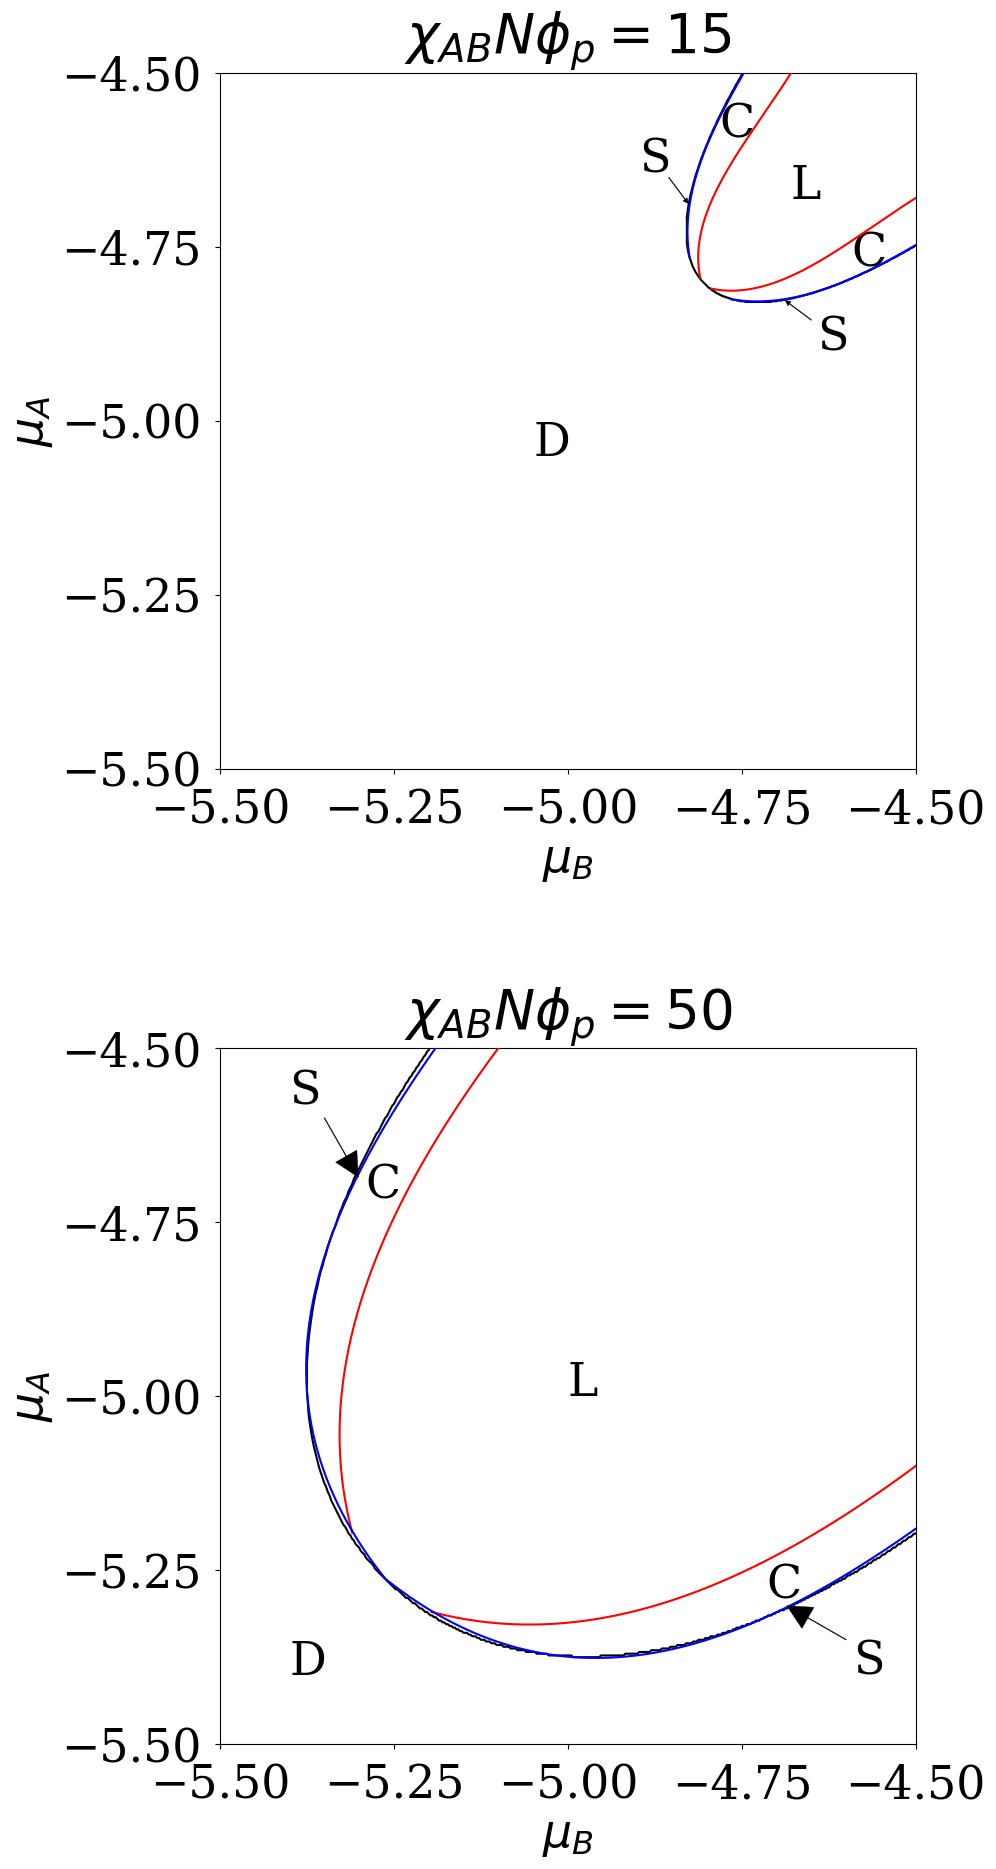

In [370]:
font_size = 33
# Set font globally
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': font_size
})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))


mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
del_mu_1 = .025#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1
mu1_arr_xn50 = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr_xn50 = np.arange(mu_min_2, mu_max_2, del_mu_2)

# mu_max_1 = -3-1.5005#8#0.1 #10
# mu_min_1 = -3.4-1.5#-9
# del_mu_1 = 0.005# .001#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1
mu1_arr_xn15 = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr_xn15 = np.arange(mu_min_2, mu_max_2, del_mu_2)


# mu_max_1 = -2.6-1.5#8#0.1 #10
# mu_min_1 = -3-1.5#-9
# del_mu_1 = .005#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1
mu1_arr_xn13 = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr_xn13 = np.arange(mu_min_2, mu_max_2, del_mu_2)


# plot_phase_diagram_xn13(ax1, mu1_arr_xn13, mu2_arr_xn13, phases_xn13, spin_left_app_xn13, spin_right_xn13)
plot_phase_diagram_xn15(ax1, mu1_arr_xn15, mu2_arr_xn15, phases_xn15, spin_left_app_xn15, spin_right_xn15)
plot_phase_diagram_xn50(ax2, mu1_arr_xn50, mu2_arr_xn50, phases_xn50, spin_left_app, spin_right)

plt.tight_layout()

plt.savefig("phase_diag_comp_fig5_ALT.eps", format = "eps")
plt.savefig("phase_diag_comp_fig5_ALT.png")
plt.savefig("phase_diag_comp_fig5_ALT.pdf", format = "pdf")


plt.show()
